# Part B: CA1 CIFAR100 image classification

## Name: Quah Johnnie
## Admin No: 2007476
## Class: DAAA/FT/2B/04

<br>

## Intro:
In this assignment I have explored creating my own models from scratch and also explored many different architectures and have implemented it into my CA1 Deep Learning assignment these architecture includes, ResNet, DenseNet, ResNeXt and CoAtNet.  <br><br>(Part A: ResNet, DenseNet) | <b>(Part B: ResNeXt, CoAtNet)</b>

<br>

### What's [CIFAR100](https://www.cs.toronto.edu/~kriz/cifar.html)?
The CIFAR100 dataset also known as, Candian Institute for Advanced Research 100, is a subset of the  [Tiny Images](https://groups.csail.mit.edu/vision/TinyImages/) dataset and consists of 60000 32x32 color images. The 100 classes in the CIFAR-100 are grouped into 20 superclasses with 5 subclasses for each superclass.

### Goal
The goal is to build, analyze and evaluate multiple models using the CIFAR100 dataset and eventually settle on a model that is able to generalize well to new data without overfitting.
<br><br>

**All code is original unless attributed**

# 0.0: Imports & Configuration

In [ ]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3080 Ti (UUID: GPU-0e42f8c3-6223-f1d6-5ca0-57d93c5a3520)
GPU 1: NVIDIA GeForce RTX 3080 Ti (UUID: GPU-ce810bb2-3e47-b722-613a-d3358dbf87ba)


In [ ]:
!pip install matplotlib
!pip install seaborn
!pip install torch-summary
!pip install -U scikit-learn
!pip install -U matplotlib
!pip install einops
!pip install tensorflow
# !pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

In [ ]:
import torch, re, time, gc, itertools, random, os ,sys, random
from IPython.display import clear_output
import torch.optim as optim
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
from copy import copy, deepcopy
import pandas as pd
from collections import OrderedDict
from typing import Any, Callable, List, Optional, Type, Union, Tuple
from sklearn.metrics import classification_report, confusion_matrix
from torchsummary import summary
from einops import rearrange
from einops.layers.torch import Rearrange

# Tensorflow for the coarse labelled data only
from tensorflow.keras.datasets.cifar100 import load_data

# from sklearn.preprocessing import OneHotEncoder

sns.set(style="ticks")

# Device configuration

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Again, this is a relative high batch size (chosen for faster computation). Stronger and better data augmentation has to be done

In [ ]:
BATCH_SIZE = 512

Turning raw data into torch.TensorFloat so I can use it for EDA

# 1.0: Dataset Preparation & EDA & Data Understanding
- Importing dataset
- What does each fine classes of CIFAR look like?
- What does CIFAR look like with coarse labels?
- What does the 'average' fine classes of CIFAR look like?
- What does the 'average' RGB value look like for each superclass of CIFAR
- Are there any outliers within each class, what do the outliers look like?
- Summary of analysis from EDA.

## 1.1: Dataset Preparation

### Metadata from [Kaggle](https://www.kaggle.com/datasets/fedesoriano/cifar100)

Class Labels from Metadata: <br>
Format **(class number range): Superclass - Subclasses**:
- (classes 1-5): aquatic mammals - beaver, dolphin, otter, seal, whale
- (classes 6-10): fish - aquarium fish, flatfish, ray, shark, trout
- (classes 11-15): flowers - orchids, poppies, roses, sunflowers, tulips
- (classes 16-20): food containers - bottles, bowls, cans, cups, plates
- (classes 21-25): fruit and vegetables - apples, mushrooms, oranges, pears, sweet peppers
- (classes 26-30): household electrical devices - clock, computer keyboard, lamp, telephone, television
- (classes 31-35): household furniture - bed, chair, couch, table, wardrobe
- (classes 36-40): insects - bee, beetle, butterfly, caterpillar, cockroach
- (classes 41-45): large carnivores - bear, leopard, lion, tiger, wolf
- (classes 46-50): large man-made outdoor things - bridge, castle, house, road, skyscraper
- (classes 51-55): large natural outdoor scenes - cloud, forest, mountain, plain, sea
- (classes 56-60): large omnivores and herbivores - camel, cattle, chimpanzee, elephant, kangaroo
- (classes 61-65): medium-sized mammals - fox, porcupine, possum, raccoon, skunk
- (classes 66-70): non-insect invertebrates - crab, lobster, snail, spider, worm
- (classes 71-75): people - baby, boy, girl, man, woman
- (classes 76-80): reptiles - crocodile, dinosaur, lizard, snake, turtle
- (classes 81-85): small mammals - hamster, mouse, rabbit, shrew, squirrel
- (classes 86-90): trees - maple, oak, palm, pine, willow
- (classes 91-95): vehicles 1 - bicycle, bus, motorcycle, pickup truck, train
- (classes 96-100): vehicles 2 - lawn-mower, rocket, streetcar, tank, tractor
<br>

Just by seeing the labels and with simple domain knownledge, I can tell that this is going to be a much harder classification problem than FashionMNIST. There is a lot more classes, furthermore, some classes are pretty similar to one another, infact subclasses of their superclass will have similar features and our model needs robust enough to be able to extract the minor differences between some of the features.

In [ ]:
training_data = datasets.CIFAR100(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_data = datasets.CIFAR100(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)


class_labels = training_data.classes

train_loader = DataLoader(training_data, batch_size=len(training_data))
test_loader = DataLoader(test_data, batch_size=len(test_data))

train_data = torch.Tensor(next(iter(train_loader))[0].numpy())
test_data = torch.Tensor(next(iter(test_loader))[0].numpy())

train_label = torch.Tensor(next(iter(train_loader))[1].numpy())
test_label = torch.Tensor(next(iter(test_loader))[1].numpy())

del train_loader, test_loader, training_data

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
(_, train_label_coarse), (_, test_label_coarse) = load_data('coarse')
train_label_coarse = train_label_coarse.reshape(len(train_label_coarse))
test_label_coarse = test_label_coarse.reshape(len(test_label_coarse))

# Referenced from Kaggle link[Section 1.1] (official metdadata from toronto university)
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
metadata_path = './meta'
metadata = unpickle(metadata_path)
superclass_labels = list(metadata[b'coarse_label_names'])

### 1.2.1: Overview of images from each classes
- Fine/subclasses dataset
- Coarse/superclasses dataset

Function to plot distribution of dataset with their classes

In [ ]:
def plotDist(y_data,class_labels):
    class_count = ''
    labels, counts = np.unique(y_data, return_counts=True)
    c = 0
    for label, count in zip(labels, counts):
        c += 1
        class_count += f"{class_labels[int(label)]}: {count}, "
        if c % 5 ==0:
            class_count += '\n'
    print(class_count)
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 4)
    g = sns.barplot(x=class_labels, y=counts, ax=ax)
    ax.tick_params(axis='x', rotation=90)
    g.tick_params(labelsize=7)
    plt.grid()
    plt.tight_layout()    

Fine/subclasses classes

apple: 500, aquarium_fish: 500, baby: 500, bear: 500, beaver: 500, 
bed: 500, bee: 500, beetle: 500, bicycle: 500, bottle: 500, 
bowl: 500, boy: 500, bridge: 500, bus: 500, butterfly: 500, 
camel: 500, can: 500, castle: 500, caterpillar: 500, cattle: 500, 
chair: 500, chimpanzee: 500, clock: 500, cloud: 500, cockroach: 500, 
couch: 500, crab: 500, crocodile: 500, cup: 500, dinosaur: 500, 
dolphin: 500, elephant: 500, flatfish: 500, forest: 500, fox: 500, 
girl: 500, hamster: 500, house: 500, kangaroo: 500, keyboard: 500, 
lamp: 500, lawn_mower: 500, leopard: 500, lion: 500, lizard: 500, 
lobster: 500, man: 500, maple_tree: 500, motorcycle: 500, mountain: 500, 
mouse: 500, mushroom: 500, oak_tree: 500, orange: 500, orchid: 500, 
otter: 500, palm_tree: 500, pear: 500, pickup_truck: 500, pine_tree: 500, 
plain: 500, plate: 500, poppy: 500, porcupine: 500, possum: 500, 
rabbit: 500, raccoon: 500, ray: 500, road: 500, rocket: 500, 
rose: 500, sea: 500, seal: 500, shark: 500, shrew: 500, 
sk

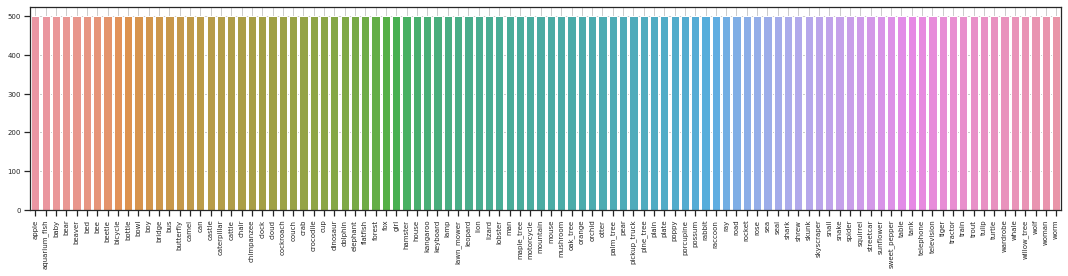

In [ ]:
plotDist(train_label,class_labels)

Coarse/superclasses

b'aquatic_mammals': 2500, b'fish': 2500, b'flowers': 2500, b'food_containers': 2500, b'fruit_and_vegetables': 2500, 
b'household_electrical_devices': 2500, b'household_furniture': 2500, b'insects': 2500, b'large_carnivores': 2500, b'large_man-made_outdoor_things': 2500, 
b'large_natural_outdoor_scenes': 2500, b'large_omnivores_and_herbivores': 2500, b'medium_mammals': 2500, b'non-insect_invertebrates': 2500, b'people': 2500, 
b'reptiles': 2500, b'small_mammals': 2500, b'trees': 2500, b'vehicles_1': 2500, b'vehicles_2': 2500, 



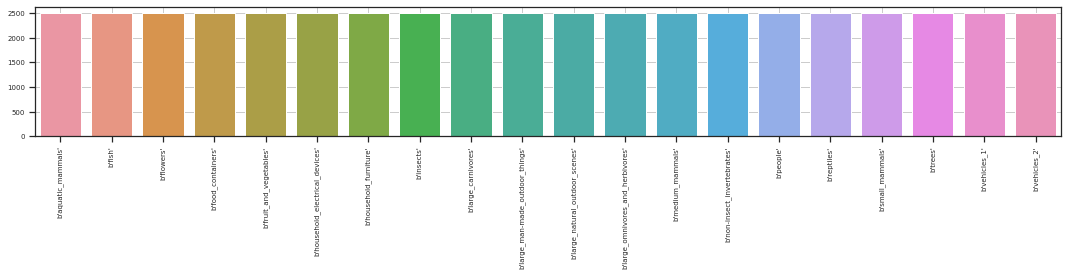

In [ ]:
plotDist(train_label_coarse,superclass_labels)

#### Observation to point out:
Off the bat, I can tell that there is the same number of datapoints for each class. It has a uniform distribution in terms of type of datapoints. With a sample of only 500 samples per subclassesclass and 2500 samples per superclasses it might be hard to make a model that can generalize well to unseen data, especially for the subclasses (fine classes) and after train-validation split as well. More important techniques to improve our model would be our data augmentation, since our data is very limited we need to replicate our dataset and perhaps use a much lower batch_size compared to Part A (FashionMNIST Classification).

In [ ]:
train_data.numpy().shape

(50000, 3, 32, 32)

The data is not in the right shape & datatype to display using imshow so we will have a function to transpose our data

In [ ]:
def img4np(tensor):
    tensor = np.swapaxes(tensor.numpy(),1,-1)
    return np.swapaxes(tensor,1,2)

train_data_np = img4np(train_data)
train_data_np.shape

(50000, 32, 32, 3)

Lets take a look at an image from every class
- Coarse labels applied first

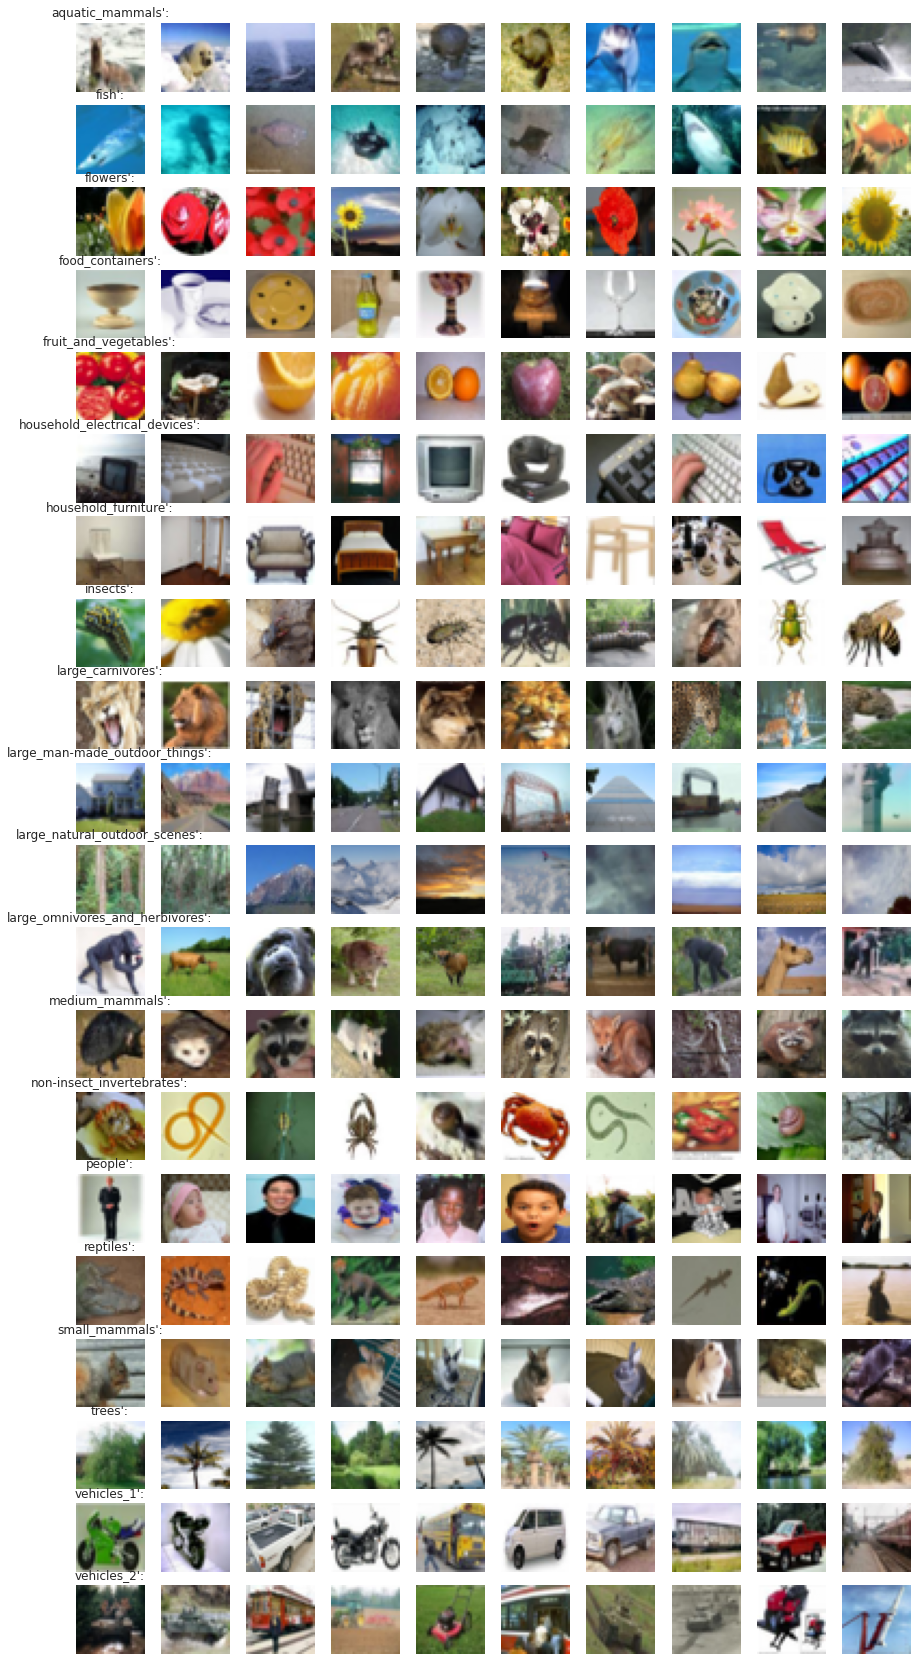

In [ ]:
fig, ax = plt.subplots(20, 10, figsize=(15, 30))
for i in range(20):
    for j in range(10):
        label = superclass_labels[i]
        images = train_data_np[np.squeeze(train_label_coarse == i)]
        subplot = ax[i, j]
        subplot.axis("off")
        subplot.imshow(images[i+j])
        if j == 0:
            subplot.set_title(f"{label}: "[2:-1])
        else:
            pass

Lets take a look at superclasses of our dataset (fine)

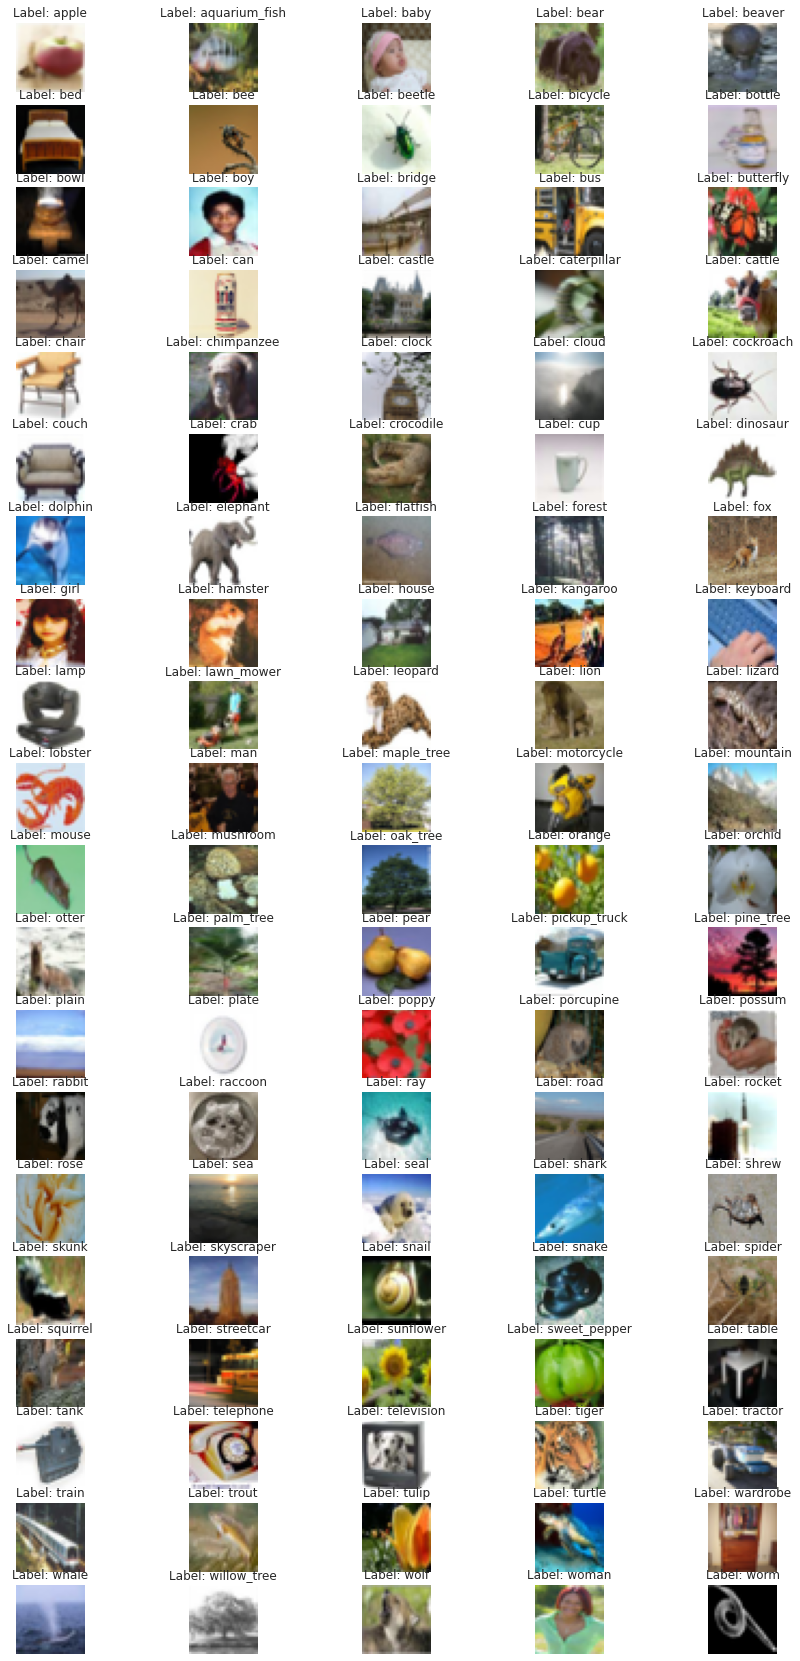

In [ ]:
fig, ax = plt.subplots(20, 5, figsize=(15, 30))
for i in range(20):
    for j in range(5):
        label = class_labels[i*5+j]
        images = train_data_np[np.squeeze(train_label == (i)*5+j)]
        subplot = ax[i, j]
        subplot.axis("off")
        subplot.imshow(images[0])
        subplot.set_title(f"Label: {label}")

Displaying the average image for subclasses

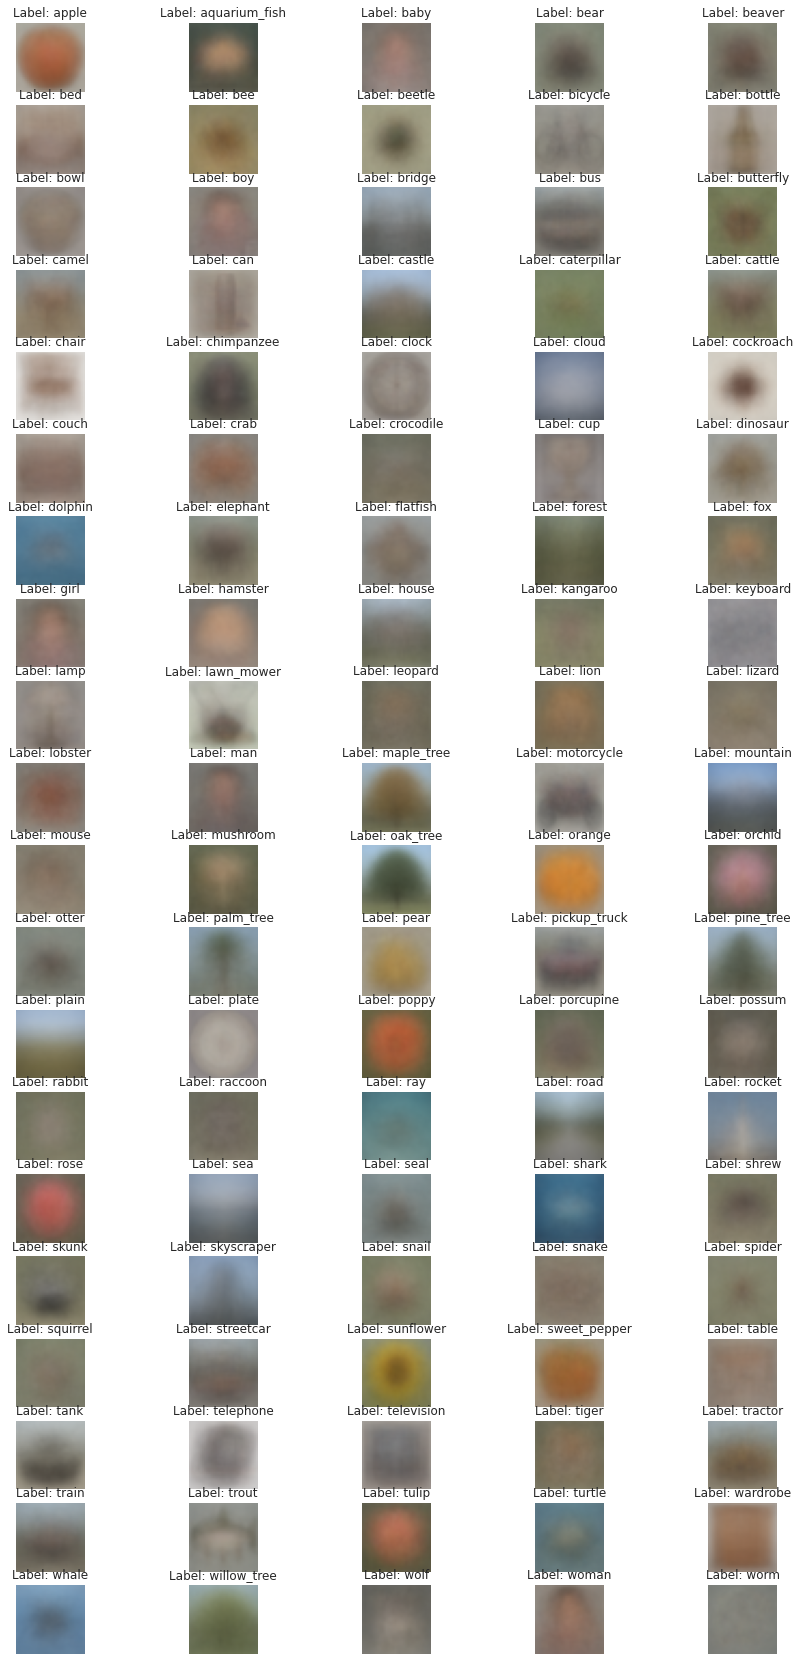

In [ ]:
fig, ax = plt.subplots(20, 5, figsize=(15, 30))
for i in range(20):
    for j in range(5):
        label = class_labels[i*5+j]
#         images = train_data_np[np.squeeze(train_label == (i)*5+j)]
        avg_image = np.mean(train_data_np[np.squeeze(train_label == (i)*5+j)], axis=0)
        subplot = ax[i, j]
        subplot.axis("off")
        subplot.imshow(avg_image)
        subplot.set_title(f"Label: {label}")

Displaying the average image for superclasses

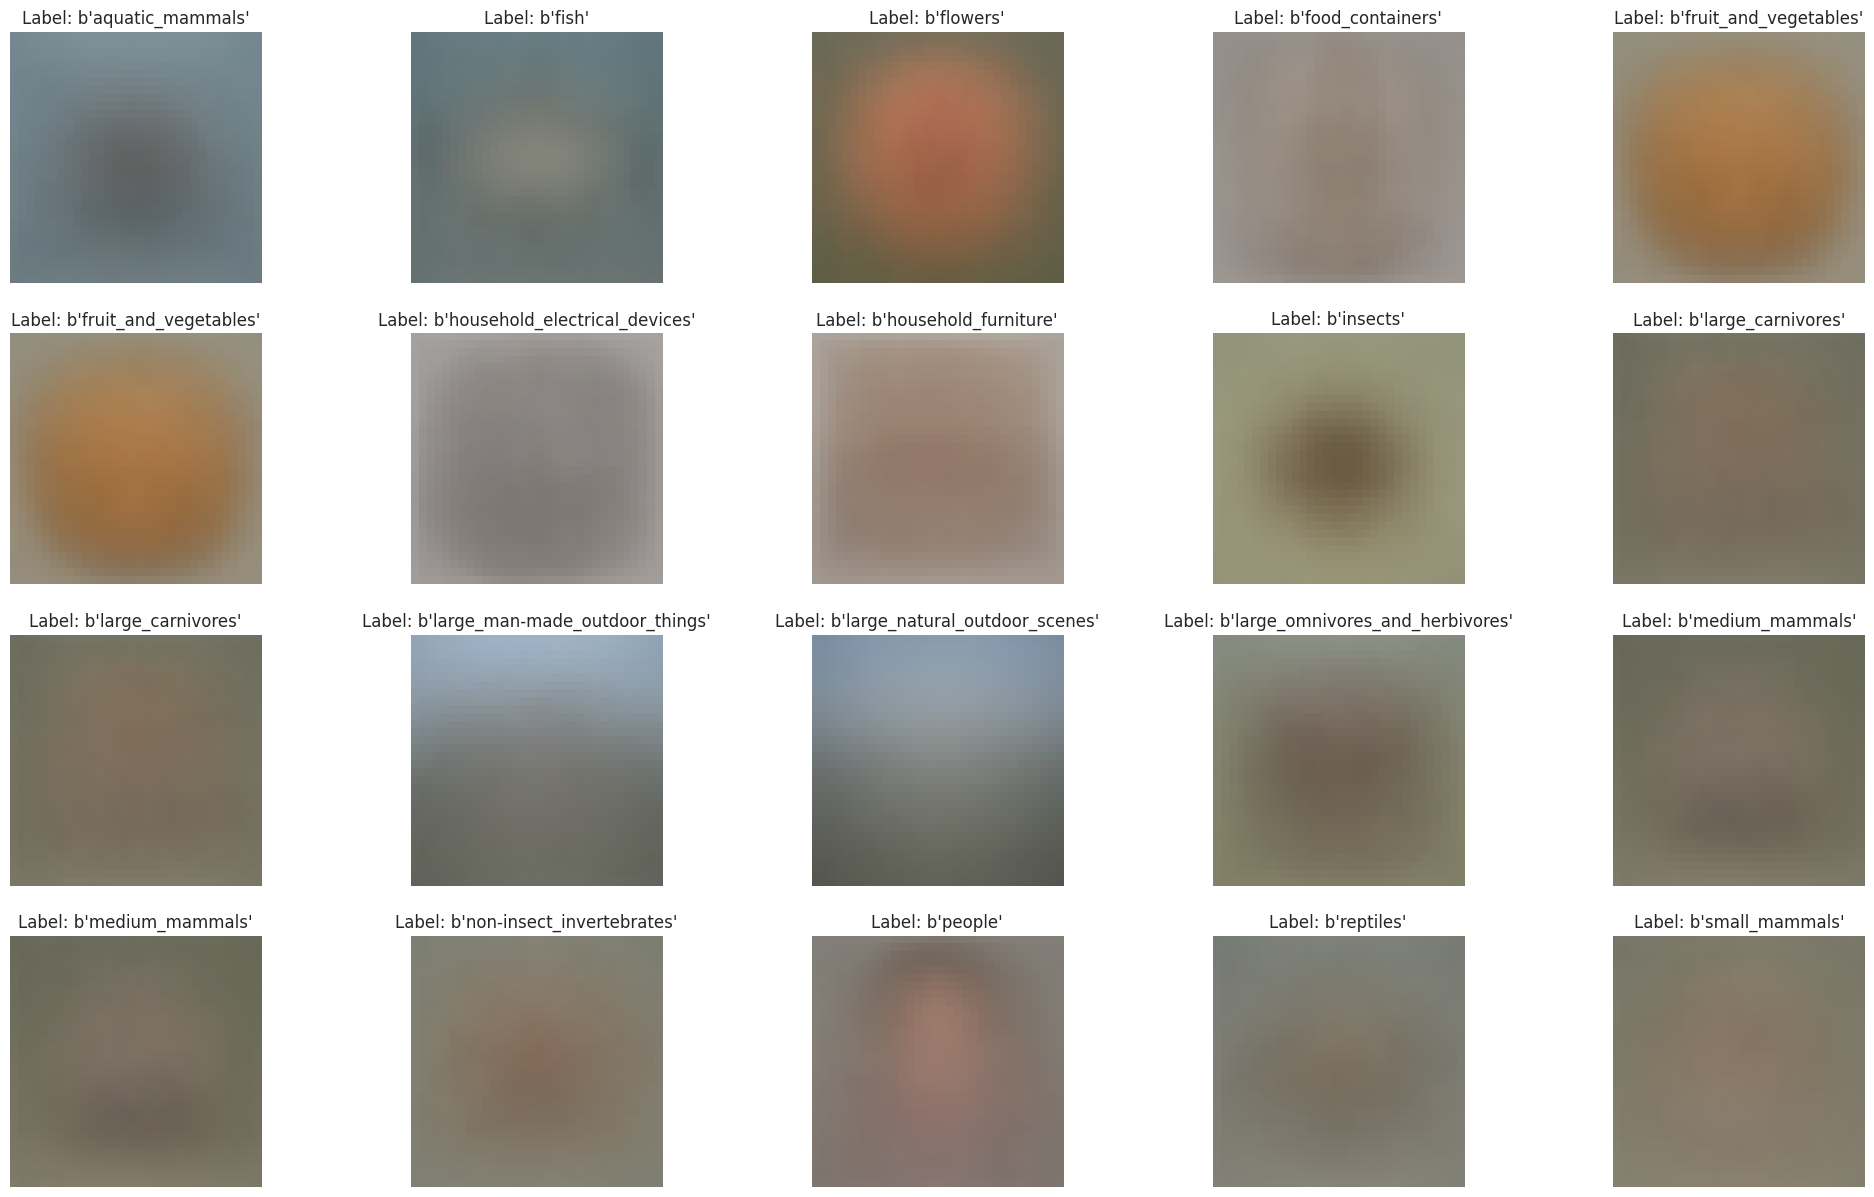

In [ ]:
fig, ax = plt.subplots(4, 5, figsize=(25, 15))
for i in range(4):
    for j in range(5):
        label = superclass_labels[i*4+j]
        avg_image = np.mean(train_data_np[np.squeeze(train_label_coarse == i*4+j)], axis=0)
        subplot = ax[i, j]
        subplot.axis("off")
        subplot.imshow(avg_image)
        subplot.set_title(f"Label: {label}")

Displaying the RGB average for all 20 superclasses or 100 subclasses is too much and rather incomprehensible. Therefore, I will just display the average as a whole(CIFAR100 images) and see whether there is any insightful analysis to get out off

From all the images that I have shown above. This is definitely going to be a much harder dataset to deal with compared to FashionMNIST. It has more classes and the images within classes differ quite a lot with one another, infact from the average images we could barely make out some of the images, especially on the fine classes. Furthermore, the images between classes do not differ much as well, infact there is at least 5 classes categorised under the same superclass (coarse label). However, the dataset also provide much more details compared to the greyscaled FashionMNIST, CIFAR100 has 3 channels and 32x32 and with 3 channels we can make out much more details in our images. All in all, although CIFAR100 images provide more information it also provided a much more complex problem compared to FashionMNIST, more complex models and stronger data augmentation are expected

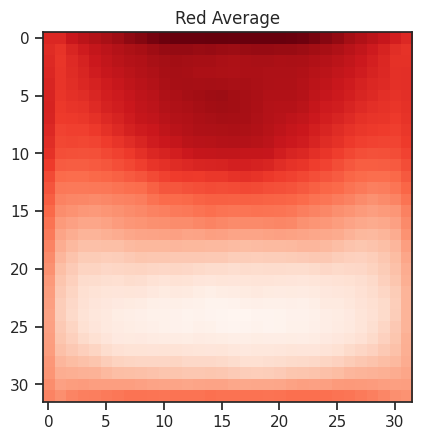

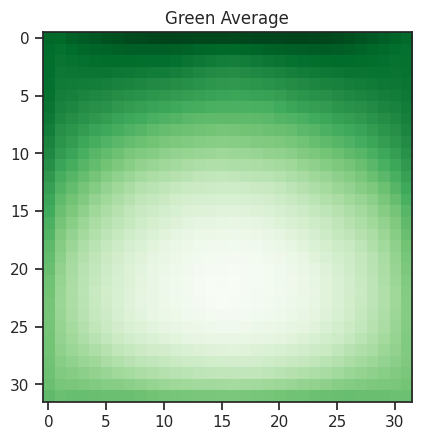

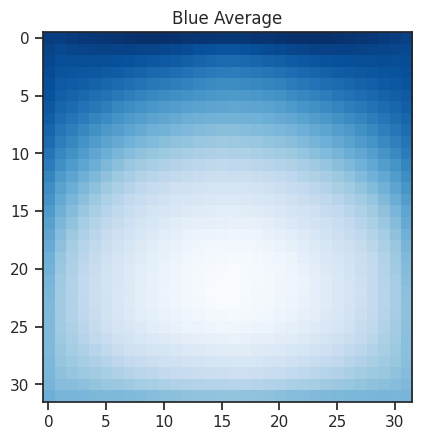

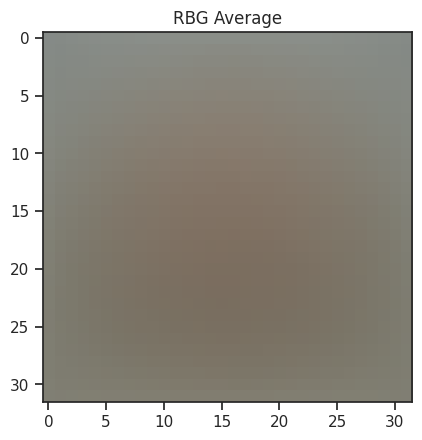

In [ ]:
plt.imshow(np.mean(train_data_np[:,:,:,0], axis=0),cmap=mpl.colormaps['Reds'])
plt.title('Red Average')
plt.show()

plt.imshow(np.mean(train_data_np[:,:,:,1], axis=0),cmap=mpl.colormaps['Greens'])
plt.title('Green Average')
plt.show()

plt.imshow(np.mean(train_data_np[:,:,:,2], axis=0),cmap=mpl.colormaps['Blues'])
plt.title('Blue Average')
plt.show()

plt.imshow(np.mean(train_data_np, axis=0))
plt.title('RBG Average')
plt.show()

The overall RGB looks exactly like a grey blank image with maybe something abit more red-orange at the middle as seen by the higher red value in the middle in the Red value image. A grey image is not unsurprising as there are so many diferent kind of classes in our CIFAR100 images that the overall average image would just be an incomprehensible mess. This also sort of tells me that using one general autoencoder might be hard to identify true outliers especially with 100 classes, since there is a lot of classes to compress and generalize by the autoencoder. One way to overcome this is to train multiple autoencoders on seperate classes. However, to cut down on time I will still use one general but robust autoencoder to identify outliers.

It would quite impractical to view all outliers of 100 classes so I will just view the top 25 outliers of our dataset and observe their features and class as well. 
- I am only making 1 autoencoder for the whole training set to display which are the types of images that are generally most different from our dataset.

In [ ]:
# This autoencoder is original
class SimpleAutoEncoder(nn.Module):
    def __init__(self):
        super(SimpleAutoEncoder, self).__init__()
        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, 5,1,padding=1), nn.BatchNorm2d(128), nn.ReLU(True),
            nn.Conv2d(128, 64,3), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.Conv2d(64, 32, 3), nn.BatchNorm2d(32), nn.ReLU(True),
            nn.Conv2d(32, 16, 3), nn.BatchNorm2d(16), nn.ReLU(True)
        )
        
        # bottleneck
        self.bottleneck = nn.Sequential(
            nn.Flatten(),
            nn.Linear(9216,384), nn.BatchNorm1d(384), nn.ReLU(True),
            nn.Linear(384,9216), nn.BatchNorm1d(9216), nn.ReLU(True),
            nn.Unflatten(1,(16,24,24)) # 9216 = 16 * 24 * 24 (calculation done manually)
        )
        
        # decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, 3), nn.BatchNorm2d(32), nn.ReLU(True),
            nn.ConvTranspose2d(32, 64, 3), nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, 128, 3), nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 5,1,padding=1), nn.ReLU(True),
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.bottleneck(x)
        x = self.decoder(x)
        return x

model = nn.DataParallel(SimpleAutoEncoder())
model = model.to(device)

print(model)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= 0.0002)

def train_ae(net, trainloader, NUM_EPOCHS, displayEvery=5):
#     train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in trainloader:
            img, _ = data # no need for the labels
            img = img.to(device)
            optimizer.zero_grad()
            outputs = net(img)
            loss = criterion(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(trainloader)
        if (epoch+1)%displayEvery==0:
            print('- Epoch {} of {}, Train Loss: {:.3f}'.format(epoch+1, NUM_EPOCHS, loss))

def get_outliers(net, trainloader):
    net.eval()
    running_loss = np.array([])
    for data in trainloader:
        img, _ = data # no need for the labels
        img = img.to(device)
        optimizer.zero_grad()
        outputs = net(img)
        loss = criterion(outputs, img)
        running_loss = np.append(running_loss,np.array(loss.item()))
        highest6 = np.argsort(running_loss)[::-1][:25] #top 25 highest reconstructed loss
    return highest6

DataParallel(
  (module): SimpleAutoEncoder(
    (encoder): Sequential(
      (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
      (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
      (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
    )
    (bottleneck): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=9216, out_features=384, bias=True)
      (2): BatchNorm1d(384, eps=1e-

In [ ]:
# Since I am making an autoencoder for outlier analysis of our training data, higher batch 
# size is generally better (as I want my autoencoder to overfit on my training data, and also it trains faster)
train_dataloader_autoencode = DataLoader(TensorDataset(train_data.type('torch.FloatTensor'),train_label.type('torch.FloatTensor')),batch_size=2048,shuffle=True)

# Single batch loader to compare RMSE of each image in each class
def single_loader():
    return DataLoader(TensorDataset(train_data.type('torch.FloatTensor'),train_label.type('torch.FloatTensor')),batch_size=1,shuffle=False)

In [ ]:
train_ae(model, train_dataloader_autoencode, 65)

# Remove the dataloader from memory
del train_dataloader_autoencode

- Epoch 5 of 65, Train Loss: 0.053
- Epoch 10 of 65, Train Loss: 0.033
- Epoch 15 of 65, Train Loss: 0.026
- Epoch 20 of 65, Train Loss: 0.023
- Epoch 25 of 65, Train Loss: 0.020
- Epoch 30 of 65, Train Loss: 0.019
- Epoch 35 of 65, Train Loss: 0.018
- Epoch 40 of 65, Train Loss: 0.017
- Epoch 45 of 65, Train Loss: 0.016
- Epoch 50 of 65, Train Loss: 0.015
- Epoch 55 of 65, Train Loss: 0.014
- Epoch 60 of 65, Train Loss: 0.013
- Epoch 65 of 65, Train Loss: 0.014


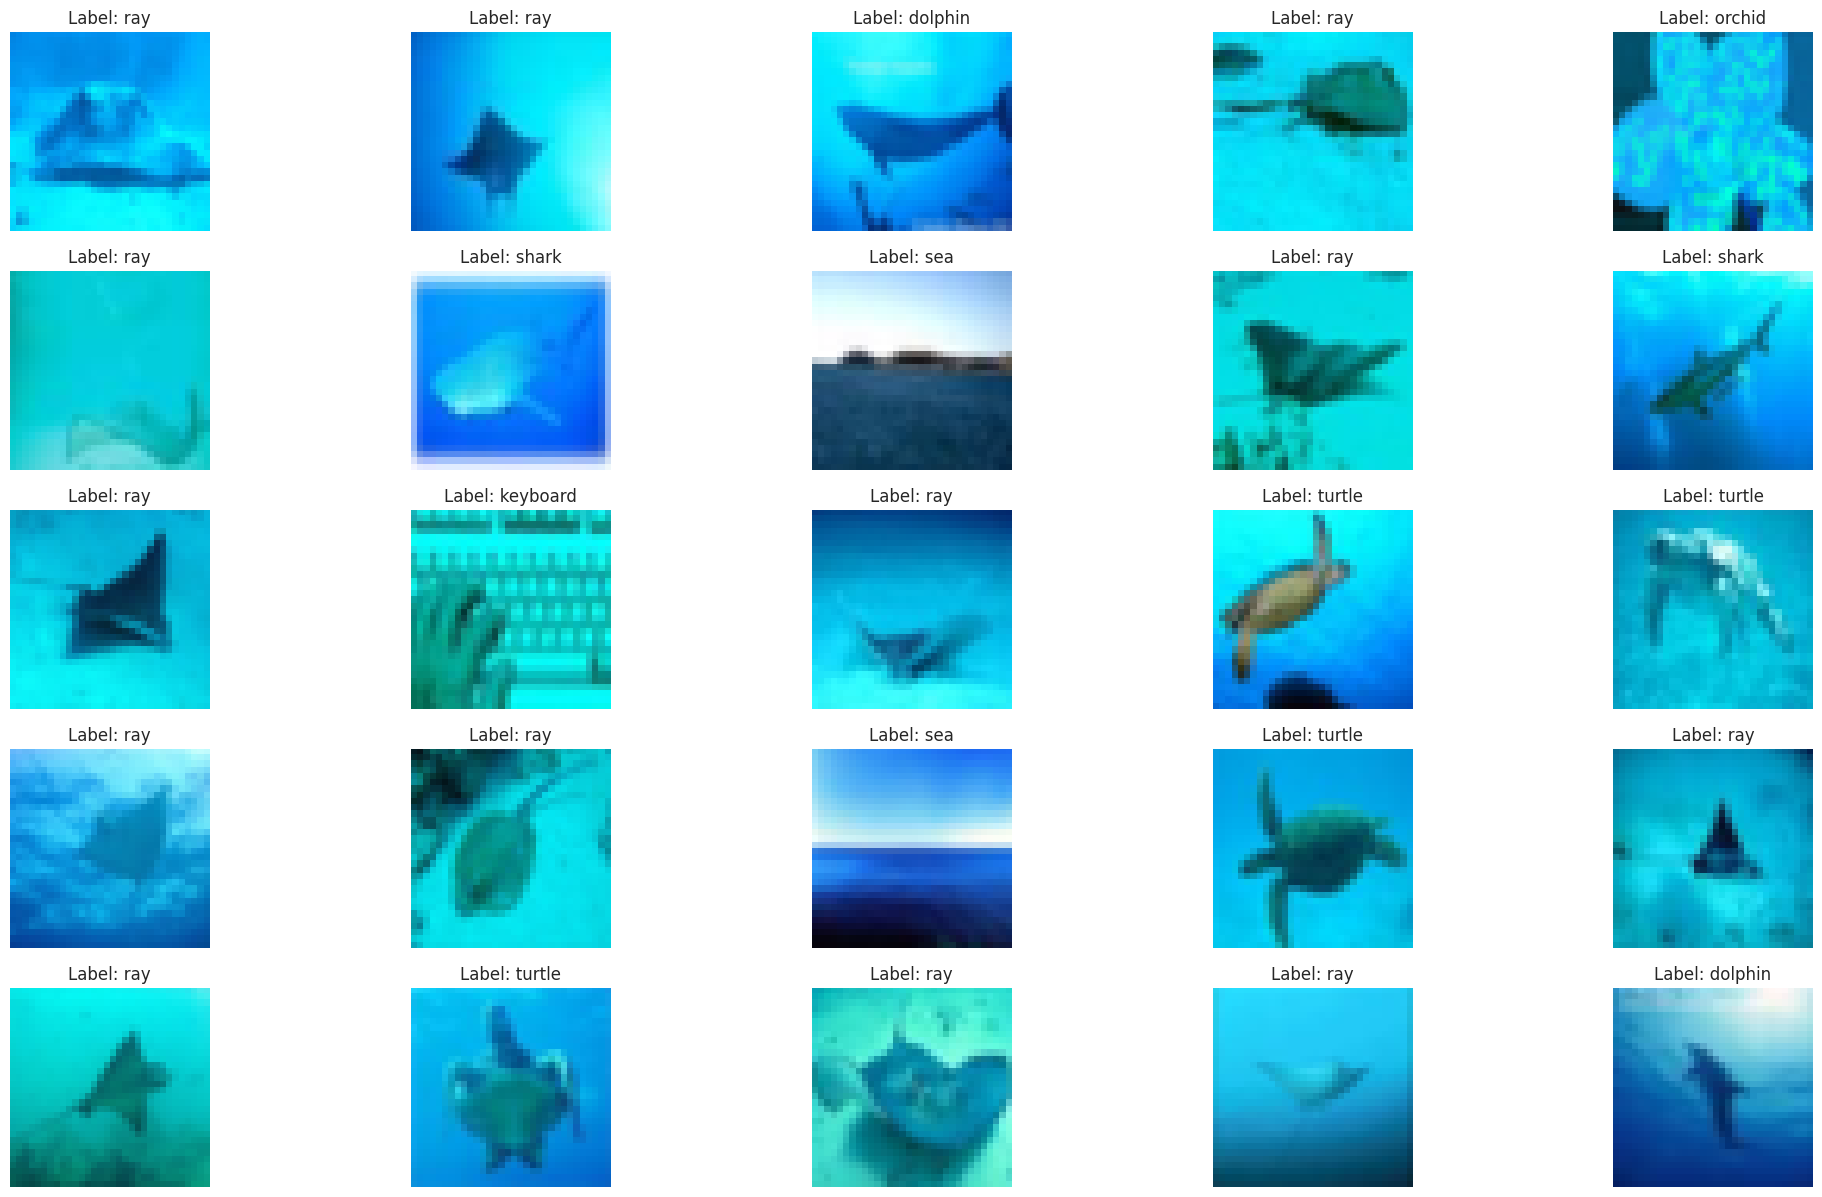

In [ ]:
fig, ax = plt.subplots(5, 5, figsize=(25, 15))
for i in range(5):
    for j in range(5):
        label_idx = train_label.type(torch.LongTensor).numpy()[outleirs_idx[i*5+j]]
        images = train_data_np[outleirs_idx[i*5+j]]
        subplot = ax[i, j]
        subplot.axis("off")
        subplot.imshow(images)
        subplot.set_title(f"Label: {class_labels[label_idx]}")

In [ ]:
# yes...I mispelled outliers
outleirs_idx = get_outliers(model,single_loader()).astype(int)

Here we hit the limitation of using just 1 autoencoder for outlier analysis(explained earlier)...We can tell that aquatic animals (of superclasses) are generally the common outliers as it looks very different from the general features/image of our dataset. However, I would not say that these aquatic animals are outliers even though they theoretically have the biggest RMSE (difference in terms features/image comapred to our general image), as the obvious reason why these aquatic animals are outliers are because they are extremely different by being blue compared to the average image (not blue). To overcome this problem it would make more sense to train an individual autoencoder on every superclass and then observe the outliers (since image being blue for an aquatic animal is obviously common and not an outlier for aquatic animal class itself). However, using just 1 general autoencoder for outlier analysis still tells us that blu-ish images are generally the most different and stand out the most from our general image. In fact, its also a surprise to see keyboard and orchid being shown here and they can easily be misidenitifed as aquatic animal super or subclasses. This gives me insight on what type of data augmentation to use too.<br>

*Making an autoencoder for every superclass is too time consuming...Therefore it is not done here*

# 2.0) Feature Engineering/Data Augmentation & More Data Preparation

| Split | Size |
|---|---|
| Training | 40K   |
| Validation | 10K  |
| Testing |  10k   |

- Based on how little data we have for our model and how complex our predictions will likely be (compared to Part A;FashionMNIST), I might want to look into a different data loading technique which augments my data every N epoch (instead of replicating and data augmenting just once before data loading in Part A). However, this will take much more time depending of how I want to apply my augmentation onto the image



### Some data leakage rules to apply (Same as Part A):

- Only the training set should be augmented. The only augmentation that I can apply on the validation/test set would be Normalization (either min-max or z-scaled), note that the values used for Normalization must also be from the _training_ dataset only, this is to minimize data leakage since we should not know any values from the testing data (the difference should be quite eligible but good practice).

- The testing data cannot be used for evaluation at any point only until the final evaluation. These remove any decision making made by using testing data hence removing overfitting of the testing data.

- No information from testing data can be used for training or validation data, and no information from validation data should be used for training data.

## 2.1) Data Preparation:
- Quick overview of our current dataset we have

In [ ]:
print('Fine data min:',train_data.min())
print('Fine data max:',train_data.max())
print(train_data.shape,'\n\n')

Fine data min: tensor(0.)
Fine data max: tensor(1.)
torch.Size([50000, 3, 32, 32]) 




- Input data already min-max normalized

min-max scaling: <br>

${x'}$ = $\frac{x - min(x)}{max(x) - min(x)}$<br><br>

simplifying to:<br>
${x'}$ = $\frac{x}{1}$<br><br>
...seems like my dataset is already normalized though...so no normalization is needed

Swap some axes, and change data type to torch tensor

In [ ]:
def npToTensor(np_):
    np_ = np.swapaxes(np_,1,-1)
    np_ = np.swapaxes(np_,2,-1)
    return torch.Tensor(np_)

More data preparation here:
- Splitting train data into training and validation data (20% split -> 40K Training, 10K Validation)
- One hot encoding training, validation and test labels

In [ ]:
traindata_input = train_data[:40000]
valdata_input = train_data[40000:]

# One hot encoded labels
traindata_label = F.one_hot(train_label.type('torch.LongTensor')[:40000],100)
valdata_label = F.one_hot(train_label.type('torch.LongTensor')[40000:],100)

train_label = F.one_hot(train_label.type('torch.LongTensor'),100)
# del train_label

test_label = F.one_hot(test_label.type('torch.LongTensor'),100)

display(traindata_input.shape)
display(valdata_input.shape)

# One hot encoded labels
train_label_coarse = F.one_hot(torch.Tensor(train_label_coarse).type('torch.LongTensor'),20)
trainlabel_coarse = train_label_coarse[:40000]
vallabel_coarse = train_label_coarse[40000:]

test_label_coarse = F.one_hot(torch.Tensor(test_label_coarse).type('torch.LongTensor'),20)

torch.Size([40000, 3, 32, 32])

torch.Size([10000, 3, 32, 32])

## 2.2) Composing our data augmentation methods
- AutoAugment (CIFAR10 Policy)
- Custom Augmentation Composition
- CutMix Augmentation
- AugMix Augmentation
- Function to replicate data and apply augmentation
- Visualizing some augmentations

CutMix source code from: [Github - idoonet](https://github.com/ildoonet/cutmix), Original Paper: [[Yun, 2019]](https://arxiv.org/abs/1905.04899)
- Class/function can be copied over from github or downloaded from link given

Code is reference from the given link. However, I added a function to augment images in different batch sizes.

In [ ]:
def rand_bbox(size, lamb):
    """ Generate random bounding box 
    Args:
        - size: [width, breadth] of the bounding box
        - lamb: (lambda) cut ratio parameter, sampled from Beta distribution
    Returns:
        - Bounding box
    """
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lamb)
    cut_w = np.int32(W * cut_rat)
    cut_h = np.int32(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def generate_cutmix_image(image_batch, image_batch_labels, beta=1):
    """ Generate a CutMix augmented image from a batch 
    Args:
        - image_batch: a batch of input images
        - image_batch_labels: labels corresponding to the image batch
        - beta: a parameter of Beta distribution.
    Returns:
        - CutMix image batch, updated labels
    """
    # generate mixed sample
    lam = np.random.beta(beta, beta)
    rand_index = np.random.permutation(len(image_batch))
    target_a = image_batch_labels
    target_b = image_batch_labels[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(image_batch[0].shape, lam)
    image_batch_updated = image_batch.copy()
    image_batch_updated[:, bbx1:bbx2, bby1:bby2, :] = image_batch[rand_index, bbx1:bbx2, bby1:bby2, :]
    
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (image_batch.shape[1] * image_batch.shape[2]))
    label = target_a * lam + target_b * (1. - lam)
    
    return image_batch_updated, label

def CutMixBatches(data,label,batch_size=1,classNum=100,beta= 1):
    stack = np.empty([0,32,32,3])
    stack_label = np.empty([0,classNum])
    for i in range(int(len(data)/batch_size)):
        start_slice = i*batch_size
        end_slice = (i+1)*batch_size
        data_batch, label_batch = generate_cutmix_image(data[start_slice:end_slice], label[start_slice:end_slice], beta=beta)
        stack = np.concatenate((stack,data_batch))
        stack_label = np.concatenate((stack_label,label_batch))
    stack = npToTensor(stack)
    stack_label = torch.Tensor(stack_label)
    return stack, stack_label

In [ ]:
def DataAugment(train_set,composeAug,batch_size=1):
    train_set = train_set * 255
    train_set = train_set.type(torch.ByteTensor)
    stack = torch.tensor([], dtype=torch.float)
    for i in range(int(len(train_set)/batch_size)):
        stack = torch.cat((stack,composeAug((train_set[i*batch_size:(i+1)*batch_size]))))

    stack = stack / 255
    return stack

# Augmentation Composition from scratch
imageColorTrans = transforms.Compose([transforms.RandomHorizontalFlip(0.825),
                            transforms.RandomRotation((-10,10)),
                            transforms.ColorJitter(brightness=0.5, contrast=0.4, saturation=0.1, hue=0.1),
                            transforms.RandomPerspective(0.0825,0.25),
                            transforms.RandomSolarize(0.985, p=0.15),
                            ])

imageColorTrans2 = transforms.Compose([transforms.RandomRotation((-10,10)),
                            transforms.ColorJitter(brightness=0.5, contrast=0.4, saturation=0.1, hue=0.1),
                            transforms.RandomPerspective(0.0825,0.25),
                            transforms.RandomSolarize(0.985, p=0.15),
                            ])


# Augmentation to compare to my scratch CIFAR10 policy chosen
imageAutoAugment = transforms.Compose([transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
                                       transforms.RandomHorizontalFlip(0.825)])
imageAutoAugment2 = transforms.Compose([transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10)])

imageAutoAugmentImageNet = transforms.Compose([transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
                                       transforms.RandomHorizontalFlip(0.825)])
imageAutoAugmentImageNet2 = transforms.Compose([transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET)])

imageAugMix = transforms.Compose([transforms.AugMix(),
                                 transforms.RandomHorizontalFlip(0.825)])

imageAugMix2 = transforms.Compose([transforms.AugMix()])

flipImage = transforms.Compose([transforms.RandomHorizontalFlip(1)])

Pre-replicate my data

In [ ]:
traindata_input_flipped = DataAugment(traindata_input,flipImage,batch_size=20000)
traindata_input_replicated = torch.cat((traindata_input,traindata_input_flipped))
traindata_label_replicated = torch.cat((traindata_label,traindata_label))

## 2.3) Augmentation visualization
- Lets visualize the augmentation we have

In [ ]:
def displayAugment(augmentCompose=imageColorTrans):
    train_data_test = DataAugment(traindata_input,augmentCompose,batch_size=1000)
    train_data_test_np = train_data_test.numpy()
    train_data_test_np = np.swapaxes(train_data_test_np,1,-1)
    train_data_test_np = np.swapaxes(train_data_test_np,1,2)


    fig, ax = plt.subplots(10, 5, figsize=(15, 30))
    for i in range(10):
        for j in range(5):
            label = class_labels[i*5+j]
            images = train_data_test_np[np.squeeze(traindata_label.argmax(-1) == (i)*5+j)]
            subplot = ax[i, j]
            subplot.axis("off")
            subplot.imshow(images[random.randint(0,350)])
            subplot.set_title(f"Label: {label}")

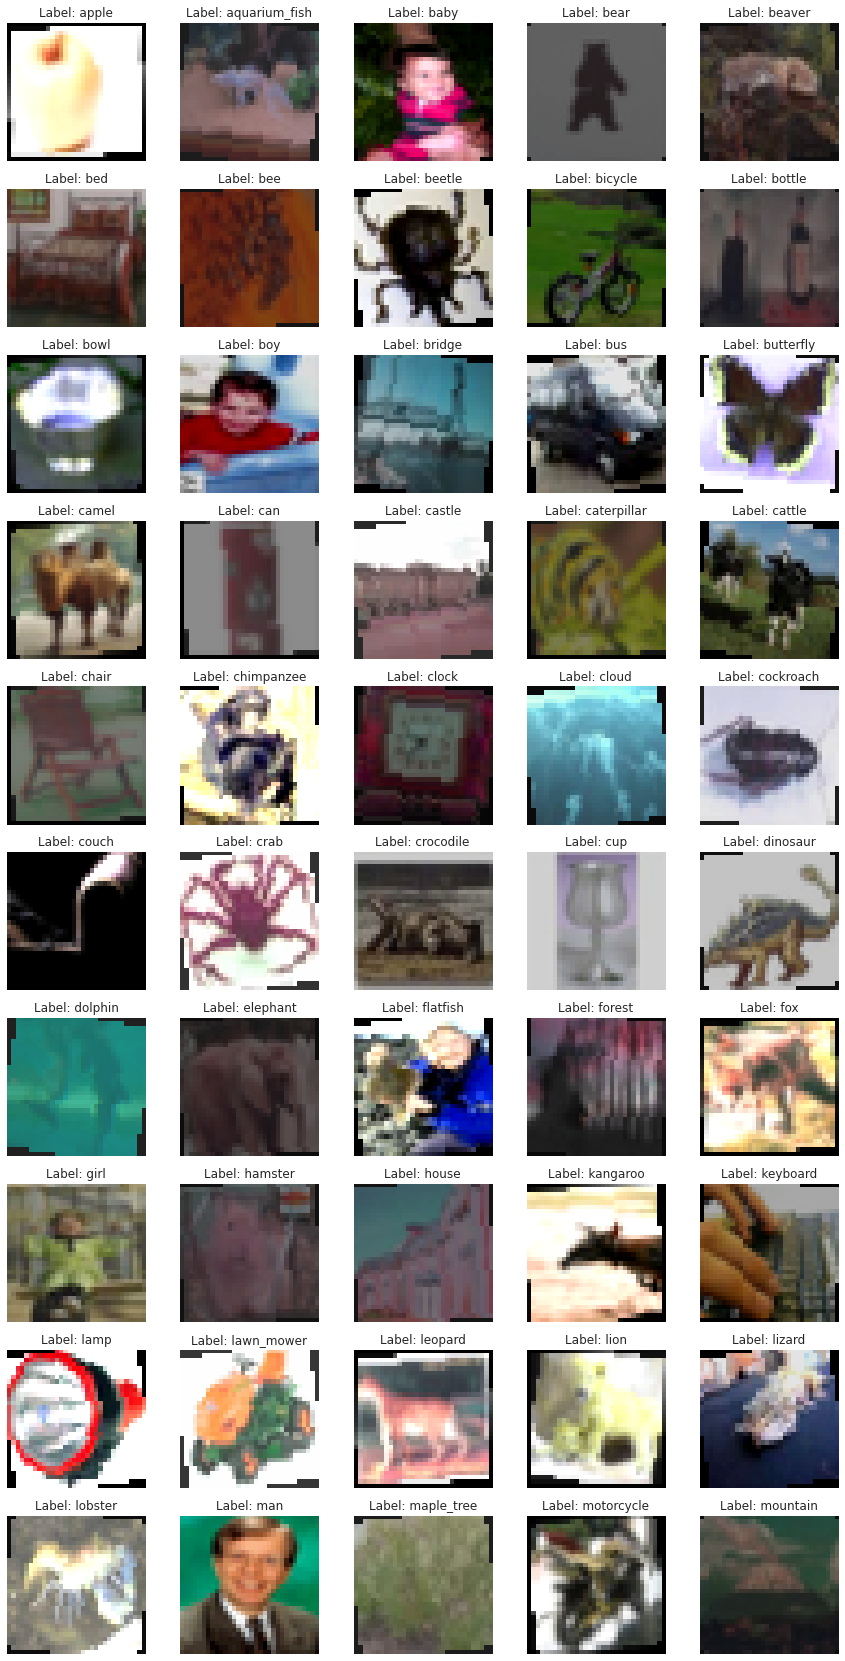

In [ ]:
displayAugment()

ImageNet Augmentation Policy

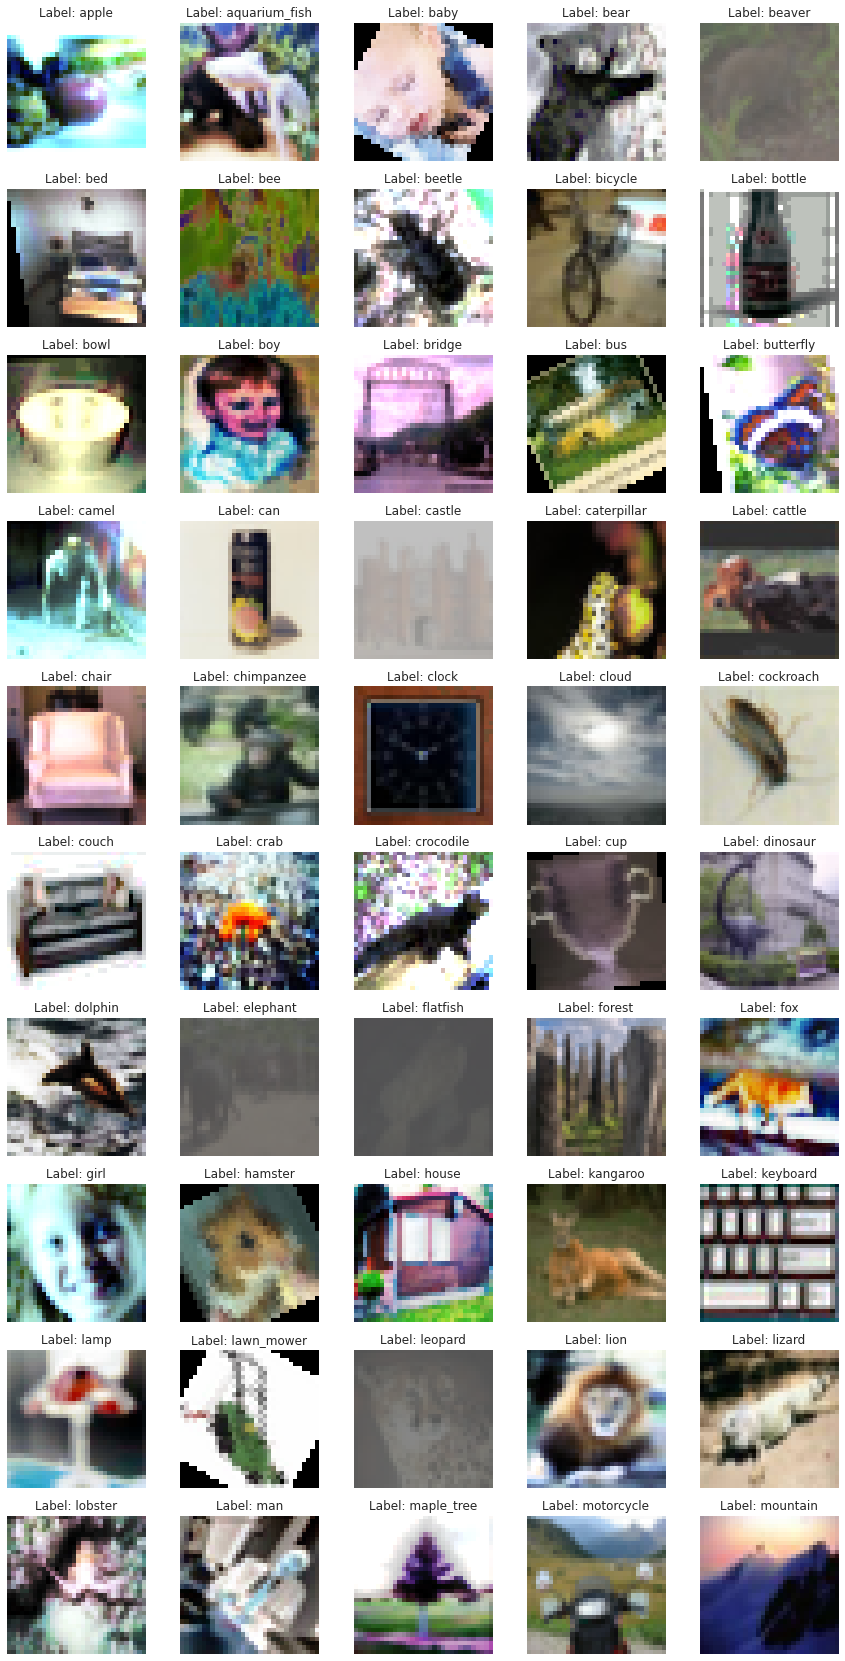

In [ ]:
displayAugment(imageAutoAugmentImageNet2)

CIFAR10 Augmmentation Policy

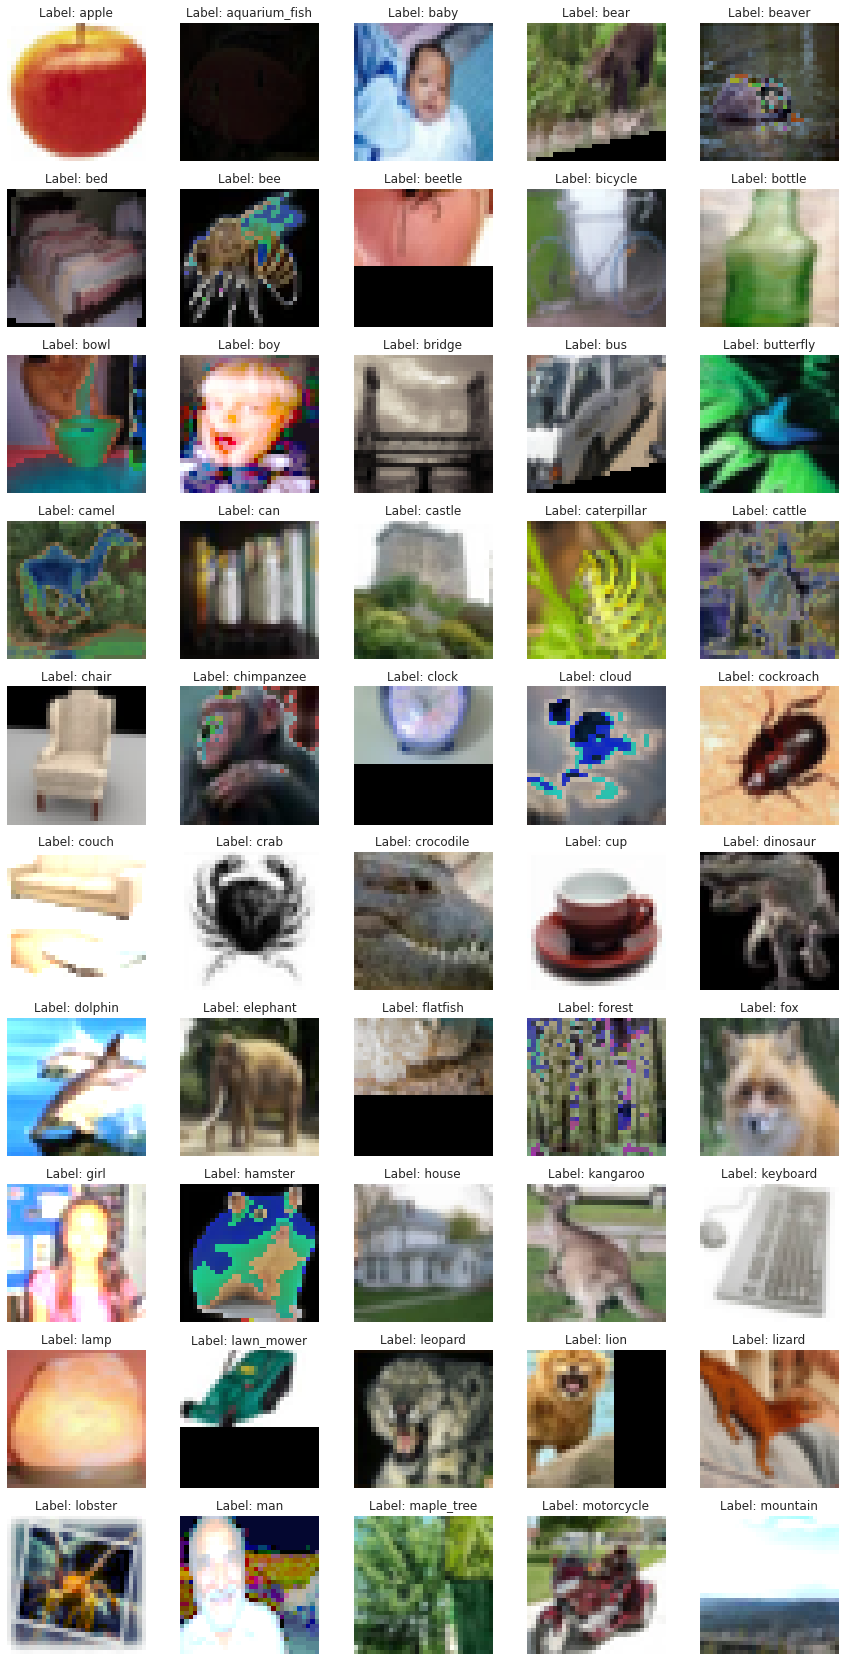

In [ ]:
displayAugment(imageAutoAugment2)

AugMix Augmentation

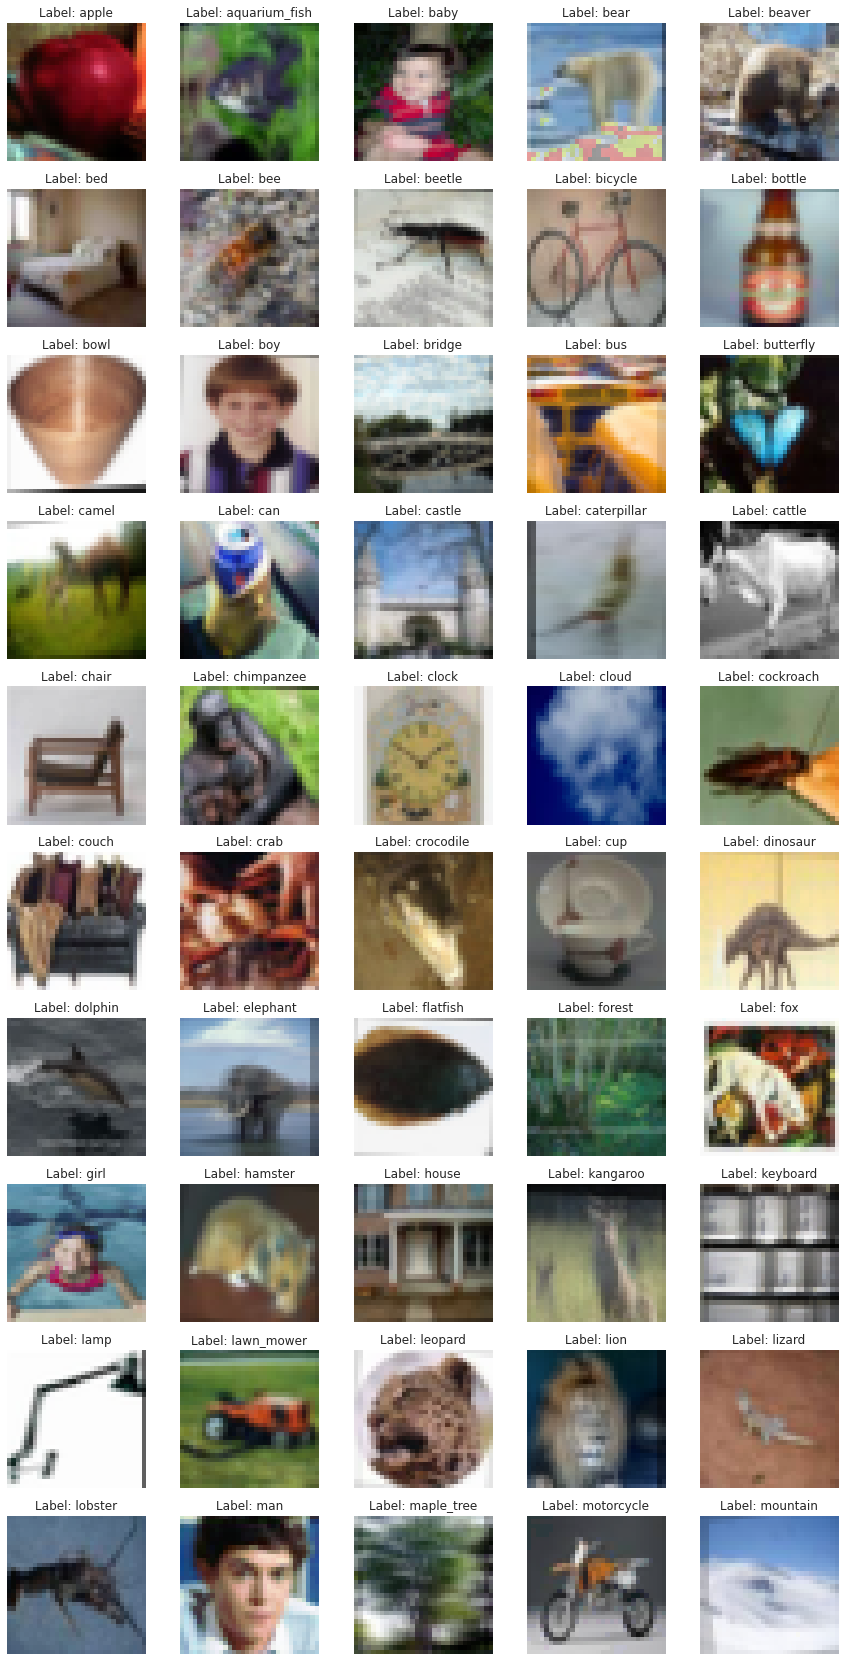

In [ ]:
displayAugment(imageAugMix2)

Let's visualize our CutMix data next

Original Images


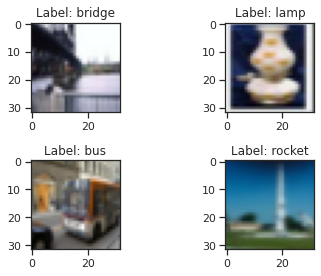

CutMix Images


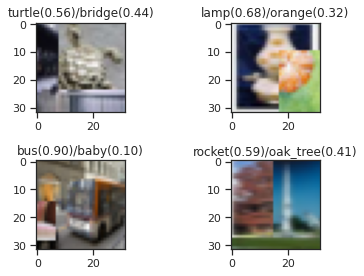

Original labels:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Updated labels
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.68359375 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [ ]:
image_batch = img4np(traindata_input)
image_batch_labels = traindata_label.numpy()


image_batch_updated, image_batch_labels_updated = CutMixBatches(image_batch,image_batch_labels,batch_size=2000,beta= 1)


image_batch_updated = img4np(image_batch_updated)
image_batch_labels_updated = image_batch_labels_updated.numpy()
randomIdx = random.sample(range(40000), 4)

# Show original images
print("Original Images")
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,2*i+j+1)
        plt.imshow(image_batch[randomIdx[2*i+j]])
        plt.title(f'Label: {class_labels[image_batch_labels[randomIdx[2*i+j]].argmax(-1)]}')
plt.tight_layout()
plt.show()


# Show CutMix images
print("CutMix Images")
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,2*i+j+1)
        plt.imshow(image_batch_updated[randomIdx[2*i+j]])
        highestIdx = image_batch_labels_updated[randomIdx[2*i+j]].argmax(-1)
        secondhighestIdx = image_batch_labels_updated[randomIdx[2*i+j]].argsort()[-2]
        plt.title(f'{class_labels[highestIdx]}({image_batch_labels_updated[randomIdx[2*i+j]][highestIdx]:.2f})/{class_labels[secondhighestIdx]}({image_batch_labels_updated[randomIdx[2*i+j]][secondhighestIdx]:.2f})')
plt.tight_layout()
plt.show()

# Print labels
print('Original labels:')
print(image_batch_labels)
print('Updated labels')
print(image_batch_labels_updated)
del image_batch_updated, image_batch, image_batch_labels, image_batch_labels_updated

As we can observed, CutMix is working as there are 2 labels after our CutMix augmentation and their label probability are also updated accordingly. The setting chosen is the default setting in the original paper of CutMix. Of course more advanced versions of CutMix has been produced and would be good to explore as well, such as MixUp & FMix.<br><br> Original Paper: [[Yun, 2019]](https://arxiv.org/abs/1905.04899)

### Lets setup functions to replicate and augment our data.
- replicateData1 -> Replicates 120K samples where 40K will be original, 40K CutMix and 40K is whatever augmentation is used in parameter
- replicateData2 -> Replicates 80K samples where 40K will be original, and 40K will be whatever augmentation is used in parameter
- replicateData3 -> Replicates 120K samples where 40K will be original, 40K will be the first augmentation composition added and another 40K is the second augmentation composition added.

In [ ]:
# Also replicates the training data and shuffle for us
def replicateData1(traindata=traindata_input, trainlabel=traindata_label,augCompose=imageColorTrans,augBatch=1250,beta=1,classNum_=100):
    traindata2 = DataAugment(traindata,augCompose,batch_size=augBatch)
    traindata3, adjustedLabel3 = CutMixBatches(img4np(traindata_input),trainlabel.numpy(),batch_size=augBatch,beta=beta,classNum=classNum_)
    inputComb = torch.cat((traindata,traindata2,traindata3))
    labelComb = torch.cat((trainlabel,trainlabel,adjustedLabel3))
    # shuffle dataset
    indices = np.arange(inputComb.shape[0])
    np.random.shuffle(indices)
    inputComb = inputComb[indices]
    labelComb = labelComb[indices]
    return inputComb, labelComb

# Also replicates the training data and shuffle for us
def replicateData2(traindata=traindata_input, trainlabel=traindata_label,augCompose=imageAutoAugment,augBatch=2500):
    traindata2 = DataAugment(traindata,augCompose,batch_size=augBatch)
    inputComb = torch.cat((traindata,traindata2))
    labelComb = torch.cat((trainlabel,trainlabel))
    # shuffle dataset
    indices = np.arange(inputComb.shape[0])
    np.random.shuffle(indices)
    inputComb = inputComb[indices]
    labelComb = labelComb[indices]
    return inputComb, labelComb

# Also replicates the training data and shuffle for us
def replicateData3(traindata=traindata_input, trainlabel=traindata_label,augCompose1=imageColorTrans,augCompose2=imageAutoAugment,augBatch=2500):
    traindata2 = DataAugment(traindata,augCompose1,batch_size=augBatch)
    traindata3 = DataAugment(traindata,augCompose2,batch_size=augBatch)
    inputComb = torch.cat((traindata,traindata2,traindata3))
    labelComb = torch.cat((trainlabel,trainlabel,trainlabel))
    # shuffle dataset
    indices = np.arange(inputComb.shape[0])
    np.random.shuffle(indices)
    inputComb = inputComb[indices]
    labelComb = labelComb[indices]
    return inputComb, labelComb

def replicateData4(traindata=traindata_input, trainlabel=traindata_label,augCompose1=imageColorTrans,augCompose2=imageAutoAugment,augBatch=2500):
    traindata2 = DataAugment(traindata,augCompose1,batch_size=augBatch)
    traindata3 = DataAugment(traindata,augCompose2,batch_size=augBatch)
    inputComb = torch.cat((traindata2,traindata3))
    labelComb = torch.cat((trainlabel,trainlabel))
    # shuffle dataset
    indices = np.arange(inputComb.shape[0])
    np.random.shuffle(indices)
    inputComb = inputComb[indices]
    labelComb = labelComb[indices]
    return inputComb, labelComb

def replicateData5(trainlabel=traindata_label,augCompose1=imageColorTrans,augBatch=2500):
    inputComb = DataAugment(traindata_input_replicated,augCompose1,batch_size=augBatch)
    labelComb = torch.cat((trainlabel,trainlabel))
    # shuffle dataset
    indices = np.arange(inputComb.shape[0])
    np.random.shuffle(indices)
    inputComb = inputComb[indices]
    labelComb = labelComb[indices]
    return inputComb, labelComb

test_1, test_2 = replicateData1(augBatch=5000)

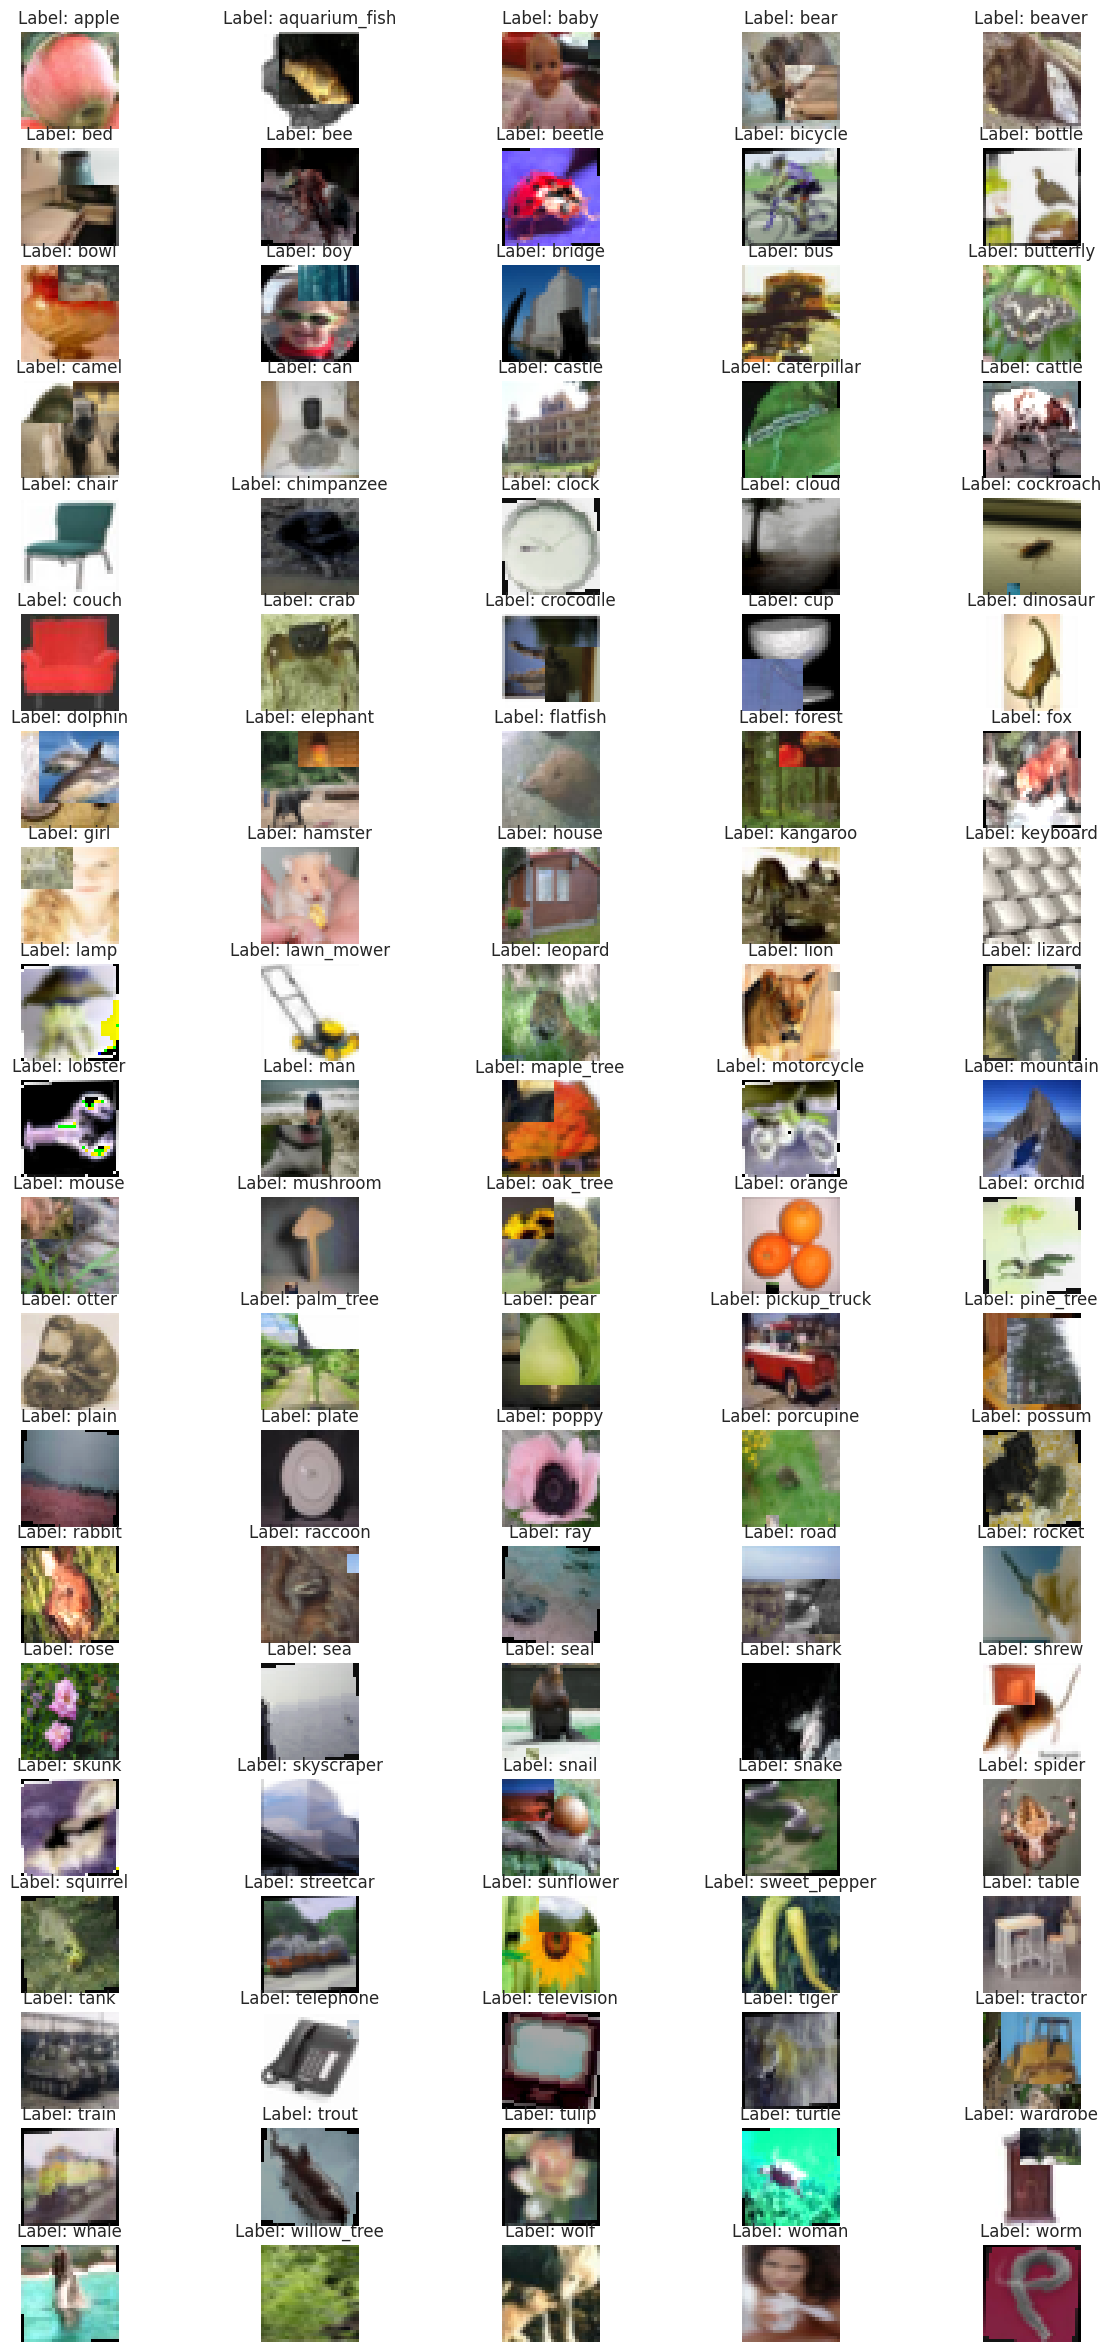

In [ ]:
test_1 = img4np(test_1)
test_2 = test_2.numpy()


fig, ax = plt.subplots(20, 5, figsize=(15, 30))
for i in range(20):
    for j in range(5):
        label = class_labels[i*5+j]
        images = test_1[np.squeeze(test_2.argmax(-1) == (i)*5+j)]
        subplot = ax[i, j]
        subplot.axis("off")
        subplot.imshow(images[random.randint(0,350)])
        subplot.set_title(f"Label: {label}")
del test_1, test_2

Collective dataset containing all augmentation. The same augmentation will be applied to the coarse dataset just different labels.

# 3.0) Modeling
- The main focus of Part B would be ResNeXt and CoAtNet architecture. 
- I will still make a few models from scratch. There after, I will include ResNeXt and CoAtNet architecture, and pick the models with the best accuracy as candidates for my model improvement
- DenseNet will also be evaluated since it was used in Part A, so it would be easy to just copy and paste the code...

I will try something different from Part A as well. I will resize my image to the original default input size of the model instead of editing the model input size to 32x32. Even though, it takes a lot more computational power to resize and train a model with image of 224x224

## 3.1) Ultility functions
- Loss & Accuracy Plotter: Function to plot the history between training and validation set to observe the rate of loss decrease or accuracy increase between training and validation set, this can help us look for outliers as well. It also indicates the point where validation loss & accuracy is the highest.
- Early Stopper: Used to track validation loss and accuracy. If validation loss or accuracy does not increase over N epochs, the model will stop training. This is to prevent overfitting of the training data.
- Model History Logger: A simple function to keep track of different models and their highest validation loss and accuracy. Easy to evaluate many different types of models.
- Train & Validate Function: A function to train & validation our model on training and validation sets

In [ ]:
def plot_history(train_loss, train_acc, val_loss, val_acc, epoch_his,title):
    fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(16, 6))
    sns.lineplot(x=epoch_his,y=train_loss, ax=ax1, label='Train Loss')
    sns.lineplot(x=epoch_his,y=val_loss, ax=ax1, label='Validation Loss')
    sns.lineplot(x=epoch_his,y=train_acc, ax=ax2, label='Train Accuracy')
    sns.lineplot(x=epoch_his,y=val_acc, ax=ax2, label='Test Accuracy')
    ax1.title.set_text(f'Lowest val loss @{min(val_loss):.4f} @Epoch {epoch_his[val_loss.index(min(val_loss))]}')
    ax2.title.set_text(f'Highest val acc @{max(val_acc):.4f} @Epoch {epoch_his[val_acc.index(max(val_acc))]}')
    ax1.axvline(epoch_his[val_loss.index(min(val_loss))],color='r',ls='--',alpha=0.75)
    ax2.axvline(epoch_his[val_acc.index(max(val_acc))],color='r',ls='--',alpha=0.75)
    ax1.axhline(min(val_loss),color='r',ls='--',alpha=0.75)
    ax2.axhline(max(val_acc),color='r',ls='--',alpha=0.75)
    fig.suptitle(title)
    plt.show()
def classification_rep(model,criterion,loader,train_loss, train_acc, val_loss, val_acc, epoch_his ,title, plot=True):
    print(title)
    if plot:
        plot_history(train_loss, train_acc, val_loss, val_acc, epoch_his,title)
    y_pred = []                                   
    y_true = []
    model.eval()
    for i, data in enumerate(loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        y_pred.extend(outputs.argmax(-1).tolist())
        y_true.extend(labels.argmax(-1).tolist())
    model.train()
    print(classification_report(y_true, y_pred,target_names=class_labels))
    return

In [ ]:
def keep_history(df,train_acc,train_loss,val_loss, val_acc, epoch_his,model_desc='NIL',desc='NIL'):
    return pd.concat([df,pd.DataFrame([[min(val_loss),max(val_acc),min(train_loss),max(train_acc),epoch_his[val_acc.index(max(val_acc))],model_desc,desc]],columns=['Lowest Val Loss','Highest Val Acc','Lowest Train Loss','Highest Train Acc','Epoch (Highest Val Acc)', 'Model Description', 'Parameter'])])

hist_df = pd.DataFrame([],columns=['Lowest Val Loss','Highest Val Acc','Lowest Train Loss','Highest Train Acc','Epoch (Highest Val Acc)', 'Model Description', 'Parameter'])

In [ ]:
class EarlyStopping():
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.early_stop = False
        self.lowest_val_loss = 99999999
        self.highest_val_accuracy = 0
    def __call__(self, val_acc, val_loss):
        if val_loss >= self.lowest_val_loss and val_acc <= self.highest_val_accuracy:
            self.counter +=1
        else:
            self.counter = 0
            if val_acc > self.highest_val_accuracy:
                self.highest_val_accuracy = val_acc
            if val_loss < self.lowest_val_loss:
                self.lowest_val_loss = val_loss
        if self.counter >= self.patience:  
            self.early_stop = True
        return self.early_stop
    def reset(self):
        self.counter = 0
        self.lowest_val_loss = 99999999
        self.highest_val_accuracy = 0
        self.early_stop = False

In [ ]:
def train(model, input_, label_ , optimizer, NUM_EPOCHS, criterion, valloader=None,earlystopper=None,showEpoch=True,scheduler=None,displayEvery=1,augmentEvery=None,augCompose=imageAutoAugment,augBatch=2000):
    train_loss_his = []
    train_accuracy_his = []
    val_loss_his = []
    val_accuracy_his = []
    epoch_his = []
    earlystopper.reset()
    model.train()
    for epoch in range(NUM_EPOCHS):
        t0 = time.time()
        total = 0
        correct = 0
        running_loss = 0.0
        if augmentEvery != None:
            if epoch % augmentEvery == 0:
                input_rep, label_rep = replicateData2(traindata=input_,augCompose=augCompose,augBatch=augBatch,trainlabel=label_)
                # The augmented dataset is already shuffled
                loader = DataLoader(TensorDataset(input_rep.type('torch.FloatTensor'),label_rep.type('torch.FloatTensor')), shuffle=False, batch_size=BATCH_SIZE)
        else:
            loader = DataLoader(TensorDataset(input_.type('torch.FloatTensor'),label.type('torch.FloatTensor')), shuffle=True, batch_size=BATCH_SIZE)
        for data in loader:
            img, label = data 
            img = img.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            outputs = model(img)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
            # _, predicted = torch.max(outputs.data, 1)
            correct += (outputs.argmax(-1) == label.argmax(-1)).sum().item()
            total += label.size(0)
            running_loss += loss.item()
        if scheduler is not None:
            scheduler.step()
        accuracy = 100 * correct / total
        loss = running_loss / len(loader)
        train_loss_his.append(loss)
        train_accuracy_his.append(accuracy)
        val_loss, val_accuracy = validate(model, criterion, valloader)
        val_loss_his.append(val_loss)
        val_accuracy_his.append(val_accuracy)
        epoch_his.append(epoch+1)
        if showEpoch and (epoch+1)%displayEvery == 0:
            print(f'- [Epoch {epoch+1}/{NUM_EPOCHS}] | Train Loss: {loss:.3f}| Train Accuracy: {accuracy} | Val Loss: {val_loss:.3f} | Val Accuracy: {val_accuracy} | Est: {(time.time() - t0)*displayEvery:.2f}s')
        if earlyStopper(val_accuracy,val_loss):
            print(f'EarlyStopper triggered at epochs: {epoch+1} \n*No improvement to validation loss and accuracy could be seen for the past {earlyStopper.patience} epochs')
            break
    print(f'Highest Val Accuracy: {max(val_accuracy_his)}  @ epoch {epoch_his[val_accuracy_his.index(max(val_accuracy_his))]} | Lowest Val Loss: {min(val_loss_his)}  @ epoch {epoch_his[val_loss_his.index(min(val_loss_his))]}')
    return train_loss_his, train_accuracy_his, val_loss_his, val_accuracy_his,epoch_his
 
def validate(model, criterion, loader=None):                     
    correct = 0                                               
    total = 0
    running_loss = []
    model.eval()
    for i, data in enumerate(loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # _, predicted = torch.max(outputs.data, 1)
        correct += (outputs.argmax(-1) == labels.argmax(-1)).sum().item()
        running_loss.append(loss.item())
        total += labels.size(0)
    mean_val_accuracy = (100 * correct / total)
    mean_val_loss = sum(running_loss) / len(running_loss)
    model.train()
    return mean_val_loss, mean_val_accuracy

## 3.2) Modelling
- Goal is to make a few models of different architecture and evaluate them eventually and use it for hyperparameter tuning

### 3.2.1) Simple baseline model
Layers inspired by the VGG16 architecture [[VGG16 Architecture](https://viso.ai/deep-learning/vgg-very-deep-convolutional-networks/)]

In [ ]:
def simpleBlock(inp_channel, layers, maxpoolStride1 = False):
    block = nn.Sequential()
    for i in range(layers-1):
        block.add_module(f'conv_layer_{i+1}', nn.Conv2d(inp_channel, inp_channel,kernel_size=3,stride=1,padding=1))
        block.add_module(f'batch_norm_{i+1}',nn.BatchNorm2d(inp_channel))
        block.add_module(f'ReLU_{i+1}',nn.ReLU(inplace=True))
    if layers-1 > 0 and not maxpoolStride1:
        block.add_module('max_pool2x2',nn.MaxPool2d(2, 2))
    elif layers-1 > 0 and maxpoolStride1:
        block.add_module('max_pool2x2',nn.MaxPool2d(2, 1))
    return block

class SimpleNet(nn.Module):
    def __init__(self,layer_config,inp,out,growthRate=2,fc_neurons=2048,classes=100):
        super(SimpleNet, self).__init__()
        # Implement the sequential module for feature extraction
        self.start = nn.Sequential(nn.Conv2d(in_channels=inp, out_channels=out, kernel_size=5, stride=1, padding=1), nn.BatchNorm2d(out), nn.ReLU(inplace=True))
        inp = out
        out = out * growthRate
        self.block1 = simpleBlock(inp,layer_config[0])
        self.block2 = nn.Sequential(nn.Conv2d(in_channels=inp, out_channels=out, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(out), nn.ReLU(inplace=True))
        self.block2_add = simpleBlock(out, layer_config[1])
        #Expand
        inp = out
        out = out * growthRate
        self.block3 = nn.Sequential(nn.Conv2d(in_channels=inp, out_channels=out, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(out), nn.ReLU(inplace=True))
        self.block3_add = simpleBlock(out, layer_config[2])
        #Expand
        inp = out
        out = out * growthRate
        self.block4 = nn.Sequential(nn.Conv2d(in_channels=inp, out_channels=out, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(out), nn.ReLU(inplace=True))
        self.block4_add = simpleBlock(out, layer_config[3], True)
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(out *2 * 2, fc_neurons), nn.BatchNorm1d(fc_neurons), nn.ReLU(inplace=True), nn.Dropout(p=0.5),
            nn.Linear(fc_neurons, fc_neurons), nn.BatchNorm1d(fc_neurons), nn.ReLU(inplace=True),
            nn.Linear(fc_neurons, classes)
            )
        # CrossEntropyLoss already have softmax activation
    def forward(self, x):
    	# Features extraction
        x = self.start(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block2_add(x)
        x = self.block3(x)
        x = self.block3_add(x)
        x = self.block4(x)
        x = self.block4_add(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

### 3.2.2) ResNeXt
- The ResNeXt architecture is an extension of the deep residual network which replaces the standard residual block with one that leverages a "split-transform-merge" strategy (ie. branched paths within a cell) used in the Inception models.
- Code from [Github [Official]](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py) Original paper: [[Xie, 2016](https://arxiv.org/abs/1611.05431)]<br>

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-06_at_4.32.52_PM.png" width="750" alt='ResNeXt infographic'><br>

[Image source: [Xie, 2016](https://arxiv.org/abs/1611.05431)]

<br>
More explanation:<br>

- ResNeXt is a homogeneous neural network which reduces the number of hyperparameters required by conventional ResNet. This is achieved by their use of "cardinality", an additional dimension on top of the width and depth of ResNet. Cardinality defines the size of the set of transformations.
- The use of cardinality have shown improvement over the traditional ResNet and Inceptionmodel

Greatly reduced the original source code by:
- Removing weights
- Removing pre-made models
- I will building models from scratch by allowing myself to add the numbers of layers to each block, "width" per cardinality and number of cardinality
- Enabling zero initialization for residual weights. Would be good to zero/one initialize all weights, not just for the residual branch's weight. Recently in Jul 2022, zero and ones initialization for all weights in a neural netowrk using batch normalization have shown consitent improvements [[Zhao el at., 2022](https://openreview.net/forum?id=1AxQpKmiTc)]
- Comments will be original to show understanding of network

In [ ]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    #3x3 convolution with padding
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    #1x1 convolution - frequently used for downsample/bottleneck
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int, #input
        planes: int, #output
        stride: int = 1,
        downsample: Optional[nn.Module] = None, #optional conv layer (see forward to see where downsample takes place)
        groups: int = 1, #cardinality - horizontal group
        base_width: int = 64, #'width' per cardinality - no. of filter each cardinality
        dilation: int = 1, #"inflation" rate of the kernel by inserting holes between the kernel element
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        #use custom norm_layer if exist, otherwise just use BatchNorm2d
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        
        #if downsample layer exist, downsample x (aka identity)
        if self.downsample is not None:
            identity = self.downsample(x)
        
        #add identity to output after running the layers in Bottleneck
        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 100,
        zero_init_residual: bool = True,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: torch.Tensor) -> torch.Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self._forward_impl(x)

### 3.2.3) CoAtNet (Attentional based model)
- CoAtNet is a family of hybrid models built from two main ideas, convolution and self-attention.
- Original paper: [[Dai el at., 2021](https://arxiv.org/abs/2106.04803)]

<img src="https://user-images.githubusercontent.com/67839539/138133065-337bb5ac-3dca-4ce8-af51-990c5ff23316.png" width="750" alt='ResNeXt infographic'><br>

[Image source: [Wu, 2021](https://github.com/chinhsuanwu/coatnet-pytorch)]

<br><br>
This model has achieved state-of-the-art performance in image classification tasks when used with the benchmark datasets like ImageNet.<br>

Greatly reduced the original source code by:
- Removing weights
- Removing pre-made models
- I will building models from scratch by allowing myself to add the numbers of layers to each block, "width" per cardinality and number of cardinality

In [ ]:
#CoAtNet basic 3x3 conv 'structure'
def conv_3x3_bn(inp, oup, image_size, downsample=False):
    stride = 1 if downsample == False else 2
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.GELU() 
        #Gaussian Error Linear Units(GELU) - similar to RELU, for resources see (https://pytorch.org/docs/stable/generated/torch.nn.GELU.html)
    )


class PreNorm(nn.Module):
    def __init__(self, dim, fn, norm):
        super().__init__()
        self.norm = norm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

#squeeze-excitation - to downsample the spartial size of the global attention and get a relative global attention
class SE(nn.Module):
    def __init__(self, inp, oup, expansion=0.25):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(oup, int(inp * expansion), bias=False),
            nn.GELU(),
            nn.Linear(int(inp * expansion), oup, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class MBConv(nn.Module):
    def __init__(self, inp, oup, image_size, downsample=False, expansion=4):
        super().__init__()
        self.downsample = downsample
        stride = 1 if self.downsample == False else 2
        hidden_dim = int(inp * expansion)

        if self.downsample:
            self.pool = nn.MaxPool2d(3, 2, 1)
            self.proj = nn.Conv2d(inp, oup, 1, 1, 0, bias=False)

        if expansion == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride,
                          1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                # down-sample in the first conv
                nn.Conv2d(inp, hidden_dim, 1, stride, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, 1, 1,
                          groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                SE(inp, hidden_dim),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        
        self.conv = PreNorm(inp, self.conv, nn.BatchNorm2d)

    def forward(self, x):
        if self.downsample:
            return self.proj(self.pool(x)) + self.conv(x)
        else:
            return x + self.conv(x)


class Attention(nn.Module):
    def __init__(self, inp, oup, image_size, heads=8, dim_head=32, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == inp)

        self.ih, self.iw = image_size

        self.heads = heads
        self.scale = dim_head ** -0.5

        # parameter table of relative position bias
        self.relative_bias_table = nn.Parameter(
            torch.zeros((2 * self.ih - 1) * (2 * self.iw - 1), heads))

        coords = torch.meshgrid((torch.arange(self.ih), torch.arange(self.iw)))
        coords = torch.flatten(torch.stack(coords), 1)
        relative_coords = coords[:, :, None] - coords[:, None, :]

        relative_coords[0] += self.ih - 1
        relative_coords[1] += self.iw - 1
        relative_coords[0] *= 2 * self.iw - 1
        relative_coords = rearrange(relative_coords, 'c h w -> h w c')
        relative_index = relative_coords.sum(-1).flatten().unsqueeze(1)
        self.register_buffer("relative_index", relative_index)

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(inp, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, oup),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(
            t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        # Use "gather" for more efficiency on GPUs
        relative_bias = self.relative_bias_table.gather(
            0, self.relative_index.repeat(1, self.heads))
        relative_bias = rearrange(
            relative_bias, '(h w) c -> 1 c h w', h=self.ih*self.iw, w=self.ih*self.iw)
        dots = dots + relative_bias

        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out


class Transformer(nn.Module):
    def __init__(self, inp, oup, image_size, heads=8, dim_head=32, downsample=False, dropout=0.):
        super().__init__()
        hidden_dim = int(inp * 4)

        self.ih, self.iw = image_size
        self.downsample = downsample

        if self.downsample:
            self.pool1 = nn.MaxPool2d(3, 2, 1)
            self.pool2 = nn.MaxPool2d(3, 2, 1)
            self.proj = nn.Conv2d(inp, oup, 1, 1, 0, bias=False)

        self.attn = Attention(inp, oup, image_size, heads, dim_head, dropout)
        self.ff = FeedForward(oup, hidden_dim, dropout)

        self.attn = nn.Sequential(
            Rearrange('b c ih iw -> b (ih iw) c'),
            PreNorm(inp, self.attn, nn.LayerNorm),
            Rearrange('b (ih iw) c -> b c ih iw', ih=self.ih, iw=self.iw)
        )

        self.ff = nn.Sequential(
            Rearrange('b c ih iw -> b (ih iw) c'),
            PreNorm(oup, self.ff, nn.LayerNorm),
            Rearrange('b (ih iw) c -> b c ih iw', ih=self.ih, iw=self.iw)
        )

    def forward(self, x):
        if self.downsample:
            x = self.proj(self.pool1(x)) + self.attn(self.pool2(x))
        else:
            x = x + self.attn(x)
        x = x + self.ff(x)
        return x


class CoAtNet(nn.Module):
    def __init__(self, image_size, in_channels, num_blocks, channels, num_classes=1000, block_types=['C', 'C', 'T', 'T']):
        super().__init__()
        ih, iw = image_size
        block = {'C': MBConv, 'T': Transformer}

        self.s0 = self._make_layer(
            conv_3x3_bn, in_channels, channels[0], num_blocks[0], (ih // 2, iw // 2))
        self.s1 = self._make_layer(
            block[block_types[0]], channels[0], channels[1], num_blocks[1], (ih // 4, iw // 4))
        self.s2 = self._make_layer(
            block[block_types[1]], channels[1], channels[2], num_blocks[2], (ih // 8, iw // 8))
        self.s3 = self._make_layer(
            block[block_types[2]], channels[2], channels[3], num_blocks[3], (ih // 16, iw // 16))
        self.s4 = self._make_layer(
            block[block_types[3]], channels[3], channels[4], num_blocks[4], (ih // 32, iw // 32))

        self.pool = nn.AvgPool2d(ih // 32, 1)
        self.fc = nn.Linear(channels[-1], num_classes, bias=False)

    def forward(self, x):
        x = self.s0(x)
        x = self.s1(x)
        x = self.s2(x)
        x = self.s3(x)
        x = self.s4(x)

        x = self.pool(x).view(-1, x.shape[1])
        x = self.fc(x)
        return x

    def _make_layer(self, block, inp, oup, depth, image_size):
        layers = nn.ModuleList([])
        for i in range(depth):
            if i == 0:
                layers.append(block(inp, oup, image_size, downsample=True))
            else:
                layers.append(block(oup, oup, image_size))
        return nn.Sequential(*layers)

### 3.2.4) DenseNet [[Huang et al, 2016](https://arxiv.org/abs/1608.06993v5)]  (Ported from Part A)

DenseNet is similar to ResNet where its residual is also passed down as layers are increased but what makes DenseNet different from ResNet would be the connectivity pattern its residual. What does this mean?<br><br>

<img src="https://i.imgur.com/z3n0Afg.png" width="750" alt='DenseNet_ResNet comparision'>

<br>

Basically the idea behind DenseNet is that the input of the next layer is a combination of the input and residual from <b><u>all</u></b> the pervious layers

<br>

This connectivity pattern has shown improvements over ResNet architecture.

Code referenced from https://github.com/pytorch/vision/blob/main/torchvision/models/densenet.py <br><br>
Edits made to original source code by:
- Removed weights
- Removed pre-made models
- Remove prebuilt models
- Building models from scratch, but making use of their architecture

In [ ]:
class _DenseLayer(nn.Module):
    def __init__(
        self, num_input_features: int, growth_rate: int, bn_size: int, drop_rate: float, memory_efficient: bool = False
    ) -> None:
        super().__init__()
        self.norm1 = nn.BatchNorm2d(num_input_features)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)

        self.norm2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)

        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs: List[torch.Tensor]) -> torch.Tensor:
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    # todo: rewrite when torchscript supports any
    def any_requires_grad(self, input: List[torch.Tensor]) -> bool:
        for tensor in input:
            if tensor.requires_grad:
                return True
        return False

    @torch.jit.unused  # noqa: T484
    def call_checkpoint_bottleneck(self, input: List[torch.Tensor]) -> torch.Tensor:
        def closure(*inputs):
            return self.bn_function(inputs)

        return cp.checkpoint(closure, *input)

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input: List[torch.Tensor]) -> torch.Tensor:  # noqa: F811
        pass

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input: torch.Tensor) -> torch.Tensor:  # noqa: F811
        pass

    # torchscript does not yet support *args, so we overload method
    # allowing it to take either a List[Tensor] or single Tensor
    def forward(self, input: torch.Tensor) -> torch.Tensor:  # noqa: F811
        if isinstance(input, torch.Tensor):
            prev_features = [input]
        else:
            prev_features = input

        if self.memory_efficient and self.any_requires_grad(prev_features):
            if torch.jit.is_scripting():
                raise Exception("Memory Efficient not supported in JIT")

            bottleneck_output = self.call_checkpoint_bottleneck(prev_features)
        else:
            bottleneck_output = self.bn_function(prev_features)

        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return new_features


class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(
        self,
        num_layers: int,
        num_input_features: int,
        bn_size: int,
        growth_rate: int,
        drop_rate: float,
        memory_efficient: bool = False,
    ) -> None:
        super().__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module("denselayer%d" % (i + 1), layer)

    def forward(self, init_features: torch.Tensor) -> torch.Tensor:
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features: int, num_output_features: int) -> None:
        super().__init__()
        self.norm = nn.BatchNorm2d(num_input_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)


class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_.
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_.
    """

    def __init__(
        self,
        growth_rate: int = 32,
        block_config: Tuple[int, int, int, int] = (6, 12, 24, 16),
        num_init_features: int = 64,
        bn_size: int = 4,
        drop_rate: float = 0,
        num_classes: int = 100,
        memory_efficient: bool = False,
    ) -> None:

        super().__init__()

        # First convolution
        self.features = nn.Sequential(
            OrderedDict(
                [
                    ("conv0", nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
                    ("norm0", nn.BatchNorm2d(num_init_features)),
                    ("relu0", nn.ReLU(inplace=True)),
                    ("pool0", nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
                ]
            )
        )

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.features.add_module("denseblock%d" % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module("transition%d" % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module("norm5", nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

In [ ]:
# init early stopper with patience of 18
earlyStopper = EarlyStopping(18)

Initializing models for fine labeled dataset

In [ ]:
# Baseline VGG inspired model
print('\nSimpleNet')
Baseline = SimpleNet([2,3,4,4],3,32,2,2048,100)
summary(Baseline,(3,32,32))

# ResNet architectures
ResNet34 = ResNet(Bottleneck,[3,4,6,3]) #
print('\nResNet34 - Medium')
summary(ResNet34,(3,32,32))

ResNeXtCustom1 = ResNet(Bottleneck,[3,4,6,3] ,groups=32,width_per_group=4) #
print('\nResNeXt Custom 2 -> ResNet34 + cardinality(32), 4 "width" per cardinality - High Complexity')
summary(ResNeXtCustom1,(3,32,32))

# Attention architectures
CoAtNetCustom1 = CoAtNet((32, 32), 3, [2, 2, 6, 14, 2], [64, 96, 192, 384, 768], num_classes=100)
print('\nCoAtNet Simple')
summary(CoAtNetCustom1,(3,32,32))


# DenseNet architectures
DenseNetCustom1 = DenseNet(32, (6, 12, 48, 32), 64, num_classes=100)
print('\nDenseNet - Complex')
summary(DenseNetCustom1,(3,32,32))


SimpleNet
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 30, 30]          --
|    └─Conv2d: 2-1                       [-1, 32, 30, 30]          2,432
|    └─BatchNorm2d: 2-2                  [-1, 32, 30, 30]          64
|    └─ReLU: 2-3                         [-1, 32, 30, 30]          --
├─Sequential: 1-2                        [-1, 32, 15, 15]          --
|    └─Conv2d: 2-4                       [-1, 32, 30, 30]          9,248
|    └─BatchNorm2d: 2-5                  [-1, 32, 30, 30]          64
|    └─ReLU: 2-6                         [-1, 32, 30, 30]          --
|    └─MaxPool2d: 2-7                    [-1, 32, 15, 15]          --
├─Sequential: 1-3                        [-1, 64, 15, 15]          --
|    └─Conv2d: 2-8                       [-1, 64, 15, 15]          18,496
|    └─BatchNorm2d: 2-9                  [-1, 64, 15, 15]          128
|    └─ReLU: 2-10                        [-1, 64, 15, 15]      

/opt/conda/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643016022/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]



CoAtNet Simple
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 16, 16]          --
|    └─Sequential: 2-1                   [-1, 64, 16, 16]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 16, 16]          1,728
|    |    └─BatchNorm2d: 3-2             [-1, 64, 16, 16]          128
|    |    └─GELU: 3-3                    [-1, 64, 16, 16]          --
|    └─Sequential: 2-2                   [-1, 64, 16, 16]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 16, 16]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 16, 16]          128
|    |    └─GELU: 3-6                    [-1, 64, 16, 16]          --
├─Sequential: 1-2                        [-1, 96, 8, 8]            --
|    └─MBConv: 2-3                       [-1, 96, 8, 8]            --
|    |    └─MaxPool2d: 3-7               [-1, 64, 8, 8]            --
|    |    └─Conv2d: 3-8                  [-1, 96, 8, 8]     

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1920, 1, 1]          --
|    └─Conv2d: 2-1                       [-1, 64, 16, 16]          9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 16, 16]          128
|    └─ReLU: 2-3                         [-1, 64, 16, 16]          --
|    └─MaxPool2d: 2-4                    [-1, 64, 8, 8]            --
|    └─_DenseBlock: 2-5                  [-1, 256, 8, 8]           --
|    |    └─_DenseLayer: 3-1             [-1, 32, 8, 8]            45,440
|    |    └─_DenseLayer: 3-2             [-1, 32, 8, 8]            49,600
|    |    └─_DenseLayer: 3-3             [-1, 32, 8, 8]            53,760
|    |    └─_DenseLayer: 3-4             [-1, 32, 8, 8]            57,920
|    |    └─_DenseLayer: 3-5             [-1, 32, 8, 8]            62,080
|    |    └─_DenseLayer: 3-6             [-1, 32, 8, 8]            66,240
|    └─_Transition: 2-6                  [-1, 128, 4, 4] 

Initializing models for coarsed labeled dataset

In [ ]:
# Baseline VGG inspired model
print('\nSimpleNet Coarse')
BaselineCoarse = SimpleNet([2,3,4,4],3,32,2,2048,20)
summary(Baseline,(3,32,32))

# ResNet architectures
ResNet34Coarse = ResNet(Bottleneck,[3,4,6,3], num_classes=20) #
print('\nResNet34 Coarse - Medium')
summary(ResNet34,(3,32,32))

ResNeXtCustom1Coarse = ResNet(Bottleneck,[3,4,6,3] ,groups=32,width_per_group=4, num_classes=20) #
print('\nResNeXt Custom 2 Coarse -> ResNet34 + cardinality(32), 4 "width" per cardinality - High Complexity')
summary(ResNeXtCustom1,(3,32,32))

# Attention architectures
CoAtNetCustom1Coarse = CoAtNet((32, 32), 3, [2, 2, 6, 14, 2], [64, 96, 192, 384, 768], num_classes=20)
print('\nCoAtNet Simple Coarse')
summary(CoAtNetCustom1,(3,32,32))


# DenseNet architectures
DenseNetCustom1Coarse = DenseNet(32, (6, 12, 48, 32), 64, num_classes=20)
print('\nDenseNet Coarse - Complex')
summary(DenseNetCustom1,(3,32,32))


SimpleNet Coarse
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 30, 30]          --
|    └─Conv2d: 2-1                       [-1, 32, 30, 30]          2,432
|    └─BatchNorm2d: 2-2                  [-1, 32, 30, 30]          64
|    └─ReLU: 2-3                         [-1, 32, 30, 30]          --
├─Sequential: 1-2                        [-1, 32, 15, 15]          --
|    └─Conv2d: 2-4                       [-1, 32, 30, 30]          9,248
|    └─BatchNorm2d: 2-5                  [-1, 32, 30, 30]          64
|    └─ReLU: 2-6                         [-1, 32, 30, 30]          --
|    └─MaxPool2d: 2-7                    [-1, 32, 15, 15]          --
├─Sequential: 1-3                        [-1, 64, 15, 15]          --
|    └─Conv2d: 2-8                       [-1, 64, 15, 15]          18,496
|    └─BatchNorm2d: 2-9                  [-1, 64, 15, 15]          128
|    └─ReLU: 2-10                        [-1, 64, 15, 15

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1920, 1, 1]          --
|    └─Conv2d: 2-1                       [-1, 64, 16, 16]          9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 16, 16]          128
|    └─ReLU: 2-3                         [-1, 64, 16, 16]          --
|    └─MaxPool2d: 2-4                    [-1, 64, 8, 8]            --
|    └─_DenseBlock: 2-5                  [-1, 256, 8, 8]           --
|    |    └─_DenseLayer: 3-1             [-1, 32, 8, 8]            45,440
|    |    └─_DenseLayer: 3-2             [-1, 32, 8, 8]            49,600
|    |    └─_DenseLayer: 3-3             [-1, 32, 8, 8]            53,760
|    |    └─_DenseLayer: 3-4             [-1, 32, 8, 8]            57,920
|    |    └─_DenseLayer: 3-5             [-1, 32, 8, 8]            62,080
|    |    └─_DenseLayer: 3-6             [-1, 32, 8, 8]            66,240
|    └─_Transition: 2-6                  [-1, 128, 4, 4] 

From the above summaries I have given each baseline model an alies and compiled the numbers of parameters they all have.
<br>

| Model | Layers (Conv+FC) | Parameters |
|---|---|---|
| Baseline | 13  | 9,198,276 |
| ResNet34 |  34  | 23,712,932 |
| ResNeXtCustom1 |  50  | 23,184,804 |
| CoAtNetCustom1 |  26  | 32,396,096 |
| DenseNetCustom1 |  171  | 20,013,928 |

In [ ]:
criterion = nn.CrossEntropyLoss()

My learning rate decay is rather slow. However, note that I will be using momentum, which contributes to more "learning rate decay".

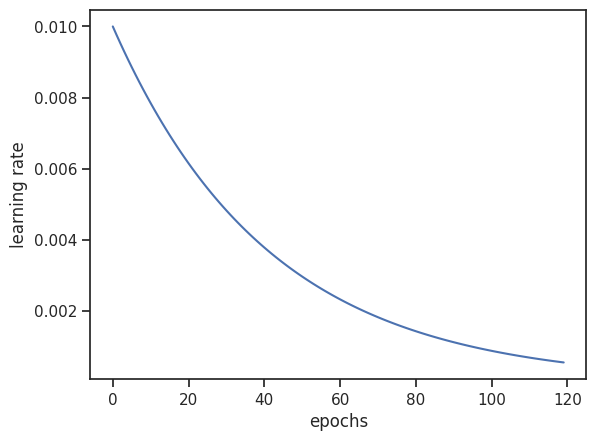

In [ ]:
epoch=120
model = torch.nn.Linear(2, 1)
opt = optim.Adam(model.parameters(),lr=0.01)
lambda1 = lambda epoch: 0.976 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda1)


lrs = []
for i in range(epoch):
    opt.step()
    lrs.append(opt.param_groups[0]["lr"])
    scheduler.step()
plt.xlabel('epochs')
plt.ylabel('learning rate')
plt.plot(range(epoch),lrs)
plt.show()
del model, opt

In [ ]:
valloader = DataLoader(TensorDataset(valdata_input.type('torch.FloatTensor'),valdata_label.type('torch.FloatTensor')), shuffle=False, batch_size=BATCH_SIZE)

valloader_coarse = DataLoader(TensorDataset(valdata_input.type('torch.FloatTensor'),vallabel_coarse.type('torch.FloatTensor')), shuffle=False, batch_size=BATCH_SIZE)


In [ ]:
def _train(model,model_desc,parameters_desc,fast=False,df=hist_df,labels = traindata_label,val_loader = valloader):
    global hist_df
    if fast:
        optimizer = optim.AdamW(model.parameters(),lr=0.001,weight_decay=0.00001)
    else:
        optimizer = optim.AdamW(model.parameters(),lr=0.0008,weight_decay=0.00001)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
        model.to(device)
    else:
        model = model.to(device)
    train_loss, train_acc, val_loss, val_acc, epoch_his = train(model, traindata_input,labels, optimizer, 125, criterion,val_loader,earlyStopper,scheduler=scheduler,augmentEvery=2,displayEvery=10)
    df = keep_history(df,train_acc,train_loss, val_loss, val_acc, epoch_his,model_desc,parameters_desc)
    return train_loss, train_acc, val_loss, val_acc, epoch_his, df

## 3.3) Model Training
- For model training, only simple augmentation (AutoAugment CIFAR10) is used.
- During model improvement other augmentations will be evaluated

### 3.3.1) Model Training for fine labels

Training Baseline model

In [ ]:
print('Baseline - VGGNet inspired')
train_loss1, train_acc1, val_loss1, val_acc1, epoch_his1, hist_df = _train(Baseline,'Baseline (VGG inspired)','9,198,276',False,df=hist_df)

Baseline - VGGNet inspired
- [Epoch 10/125] | Train Loss: 1.535| Train Accuracy: 57.02 | Val Loss: 2.123 | Val Accuracy: 46.58 | Est: 76.95s
- [Epoch 20/125] | Train Loss: 0.849| Train Accuracy: 76.31375 | Val Loss: 2.652 | Val Accuracy: 48.88 | Est: 76.94s
- [Epoch 30/125] | Train Loss: 0.453| Train Accuracy: 87.94125 | Val Loss: 2.942 | Val Accuracy: 50.29 | Est: 77.06s
- [Epoch 40/125] | Train Loss: 0.500| Train Accuracy: 87.27125 | Val Loss: 2.985 | Val Accuracy: 51.85 | Est: 77.02s
- [Epoch 50/125] | Train Loss: 0.230| Train Accuracy: 94.5325 | Val Loss: 3.210 | Val Accuracy: 52.07 | Est: 77.02s
- [Epoch 60/125] | Train Loss: 0.263| Train Accuracy: 93.105 | Val Loss: 3.321 | Val Accuracy: 52.06 | Est: 76.95s
- [Epoch 70/125] | Train Loss: 0.242| Train Accuracy: 94.1975 | Val Loss: 3.150 | Val Accuracy: 52.97 | Est: 77.00s
- [Epoch 80/125] | Train Loss: 0.254| Train Accuracy: 94.27 | Val Loss: 3.015 | Val Accuracy: 52.76 | Est: 76.96s
EarlyStopper triggered at epochs: 89 
*No impro

Lowest Val Loss                           1.981114
Highest Val Acc                              53.37
Lowest Train Loss                         0.095882
Highest Train Acc                          97.5875
Epoch (Highest Val Acc)                         71
Model Description          Baseline (VGG inspired)
Parameter                                9,198,276
Name: 0, dtype: object

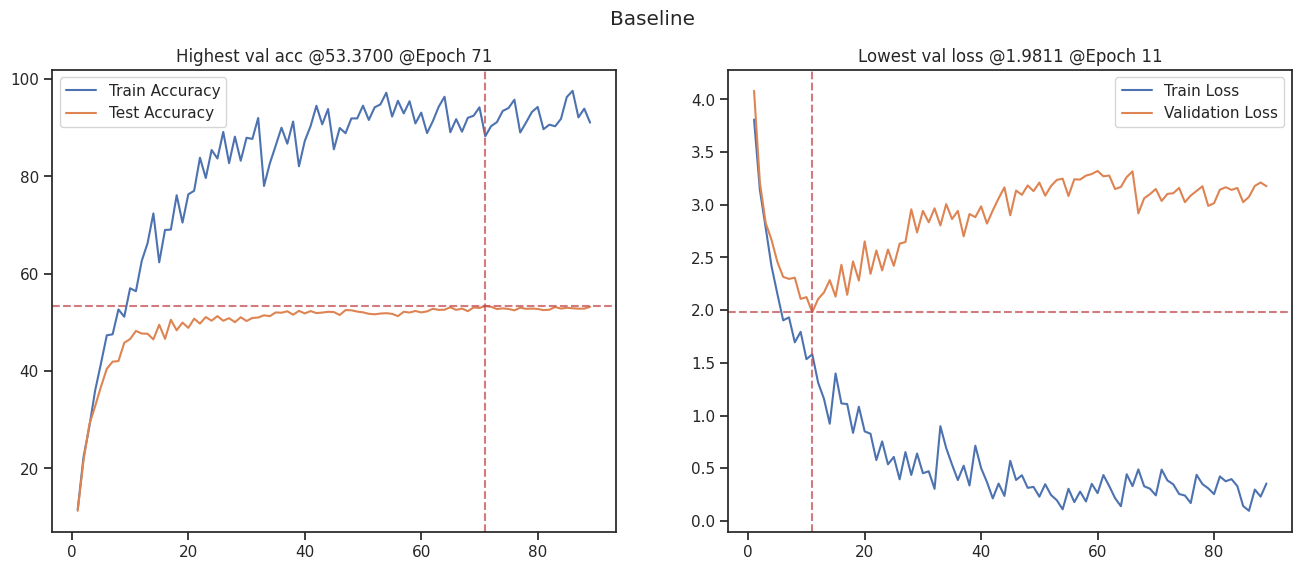

In [ ]:
display(hist_df.iloc[0])
plot_history(train_loss1, train_acc1, val_loss1, val_acc1, epoch_his1,'Baseline')
# del train_loss1, train_acc1, val_loss1, val_acc1, epoch_his1,Baseline

Training ResNet and ResNeXt models

In [ ]:
print('ResNet34')
train_loss3, train_acc3, val_loss3, val_acc3, epoch_his3, hist_df = _train(ResNet34,'ResNet34','23,712,932',True,df=hist_df)
print('ResNeXtCustom1')
train_loss5, train_acc5, val_loss5, val_acc5, epoch_his5, hist_df = _train(ResNeXtCustom1,'ResNeXt-M','23,184,804',True,df=hist_df)

# del train_loss2, train_acc2, val_loss2, val_acc2, epoch_his2,ResNet18

ResNet34
- [Epoch 10/125] | Train Loss: 0.701| Train Accuracy: 81.52625 | Val Loss: 3.055 | Val Accuracy: 38.55 | Est: 178.14s
- [Epoch 20/125] | Train Loss: 0.385| Train Accuracy: 90.585 | Val Loss: 3.497 | Val Accuracy: 41.33 | Est: 178.28s
- [Epoch 30/125] | Train Loss: 0.046| Train Accuracy: 99.10125 | Val Loss: 3.293 | Val Accuracy: 45.22 | Est: 179.91s
- [Epoch 40/125] | Train Loss: 0.116| Train Accuracy: 97.31875 | Val Loss: 3.209 | Val Accuracy: 46.76 | Est: 180.28s
- [Epoch 50/125] | Train Loss: 0.214| Train Accuracy: 94.8975 | Val Loss: 3.260 | Val Accuracy: 47.0 | Est: 178.33s
- [Epoch 60/125] | Train Loss: 0.174| Train Accuracy: 95.78375 | Val Loss: 3.165 | Val Accuracy: 48.19 | Est: 178.31s
- [Epoch 70/125] | Train Loss: 0.339| Train Accuracy: 91.4025 | Val Loss: 3.247 | Val Accuracy: 47.84 | Est: 178.36s
EarlyStopper triggered at epochs: 72 
*No improvement to validation loss and accuracy could be seen for the past 18 epochs
Highest Val Accuracy: 48.86  @ epoch 54 | Lowes

Lowest Val Loss              2.512835
Highest Val Acc                 48.86
Lowest Train Loss            0.045856
Highest Train Acc            99.10125
Epoch (Highest Val Acc)            54
Model Description            ResNet34
Parameter                  23,712,932
Name: 0, dtype: object

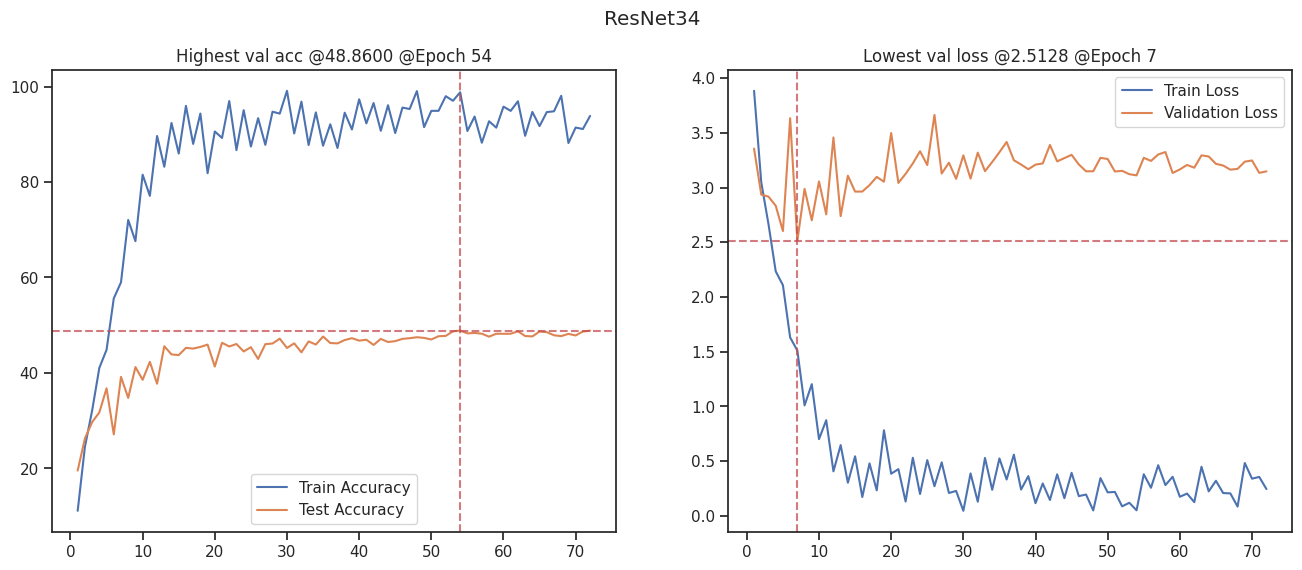

Lowest Val Loss              2.481324
Highest Val Acc                 48.89
Lowest Train Loss            0.034021
Highest Train Acc             99.3575
Epoch (Highest Val Acc)            49
Model Description           ResNeXt-M
Parameter                  23,184,804
Name: 0, dtype: object

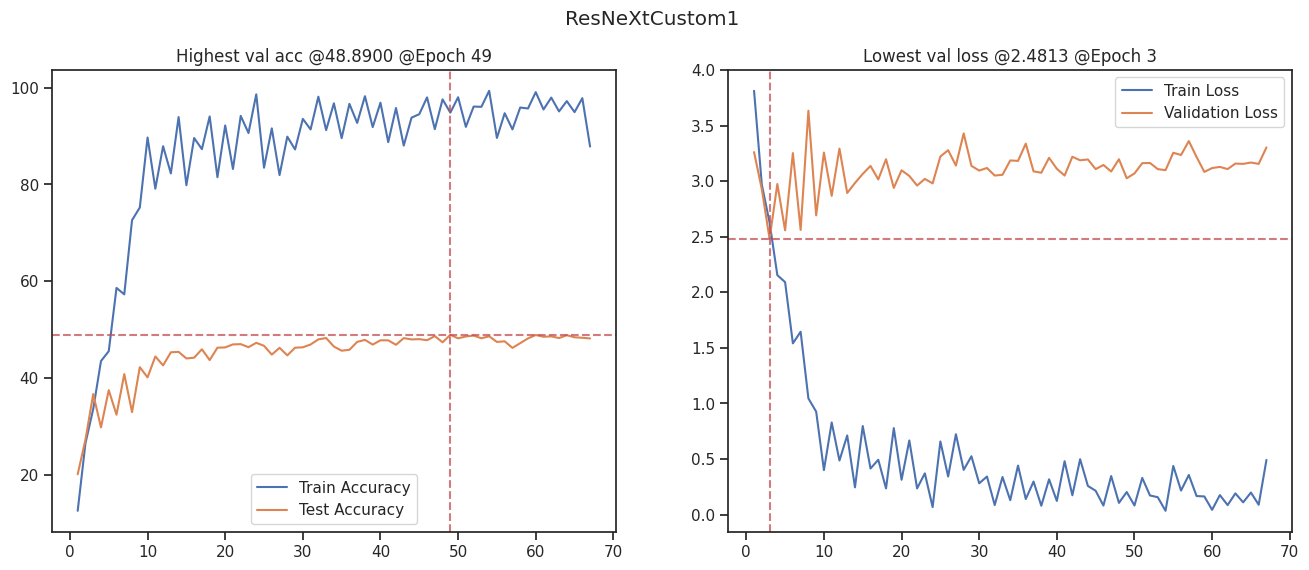

In [ ]:
display(hist_df.iloc[1])
plot_history(train_loss3, train_acc3, val_loss3, val_acc3, epoch_his3,'ResNet34')
display(hist_df.iloc[2])
plot_history(train_loss5, train_acc5, val_loss5, val_acc5, epoch_his5,'ResNeXtCustom1')

Training CoAtNet models

In [ ]:
print('CoAtNetCustom1')
train_loss6, train_acc6, val_loss6, val_acc6, epoch_his6, hist_df = _train(CoAtNetCustom1,'CoAtNet-S','32,396,096',True,df=hist_df)

CoAtNetCustom1
- [Epoch 10/125] | Train Loss: 0.542| Train Accuracy: 84.01125 | Val Loss: 2.978 | Val Accuracy: 45.76 | Est: 268.74s
- [Epoch 20/125] | Train Loss: 0.279| Train Accuracy: 92.30125 | Val Loss: 3.093 | Val Accuracy: 50.5 | Est: 266.50s
- [Epoch 30/125] | Train Loss: 0.065| Train Accuracy: 98.24875 | Val Loss: 3.200 | Val Accuracy: 52.15 | Est: 266.81s
- [Epoch 40/125] | Train Loss: 0.124| Train Accuracy: 97.165 | Val Loss: 3.048 | Val Accuracy: 52.74 | Est: 266.91s
- [Epoch 50/125] | Train Loss: 0.122| Train Accuracy: 97.245 | Val Loss: 3.028 | Val Accuracy: 52.99 | Est: 266.80s
- [Epoch 60/125] | Train Loss: 0.017| Train Accuracy: 99.6875 | Val Loss: 3.175 | Val Accuracy: 53.16 | Est: 266.68s
- [Epoch 70/125] | Train Loss: 0.029| Train Accuracy: 99.395 | Val Loss: 3.122 | Val Accuracy: 54.01 | Est: 265.22s
- [Epoch 80/125] | Train Loss: 0.020| Train Accuracy: 99.64625 | Val Loss: 3.046 | Val Accuracy: 54.66 | Est: 266.51s
- [Epoch 90/125] | Train Loss: 0.034| Train Accur

Lowest Val Loss              2.202396
Highest Val Acc                 54.66
Lowest Train Loss            0.004562
Highest Train Acc            99.94875
Epoch (Highest Val Acc)            80
Model Description           CoAtNet-S
Parameter                  32,396,096
Name: 0, dtype: object

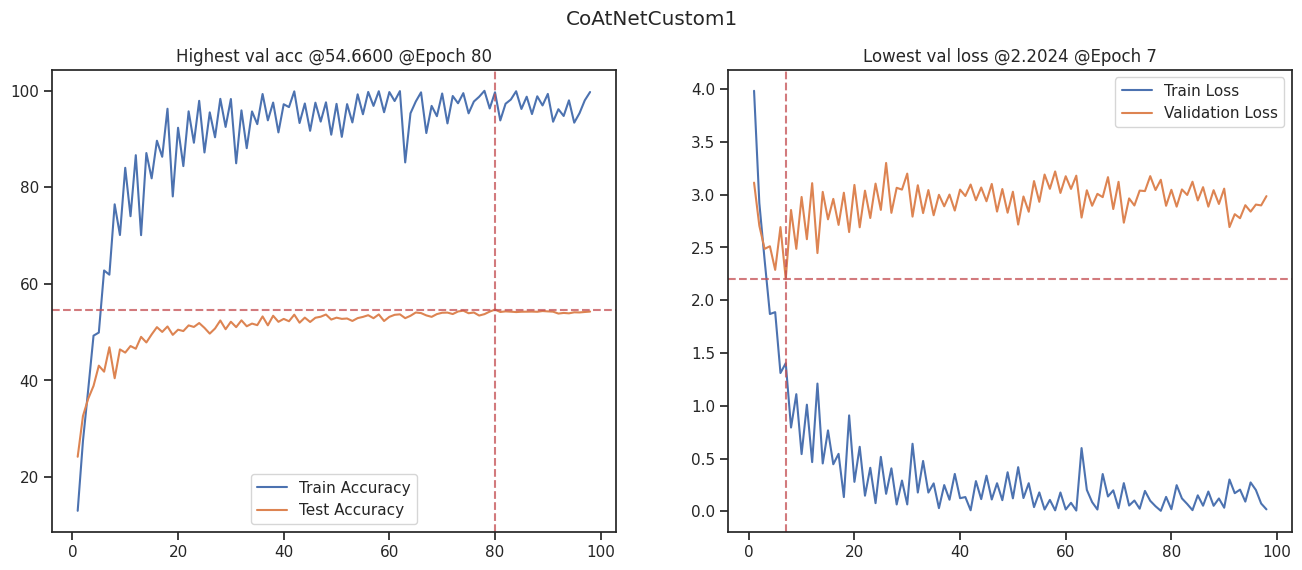

In [ ]:
display(hist_df.iloc[3])
plot_history(train_loss6, train_acc6, val_loss6, val_acc6, epoch_his6,'CoAtNetCustom1')

Training DenseNet models

In [ ]:
print('DenseNetCustom1')
train_loss10, train_acc10, val_loss10, val_acc10, epoch_his10, hist_df = _train(DenseNetCustom1,'DenseNet-M','20,013,928',True,df=hist_df)

DenseNetCustom1
- [Epoch 10/125] | Train Loss: 0.856| Train Accuracy: 76.645 | Val Loss: 3.126 | Val Accuracy: 38.89 | Est: 358.35s
- [Epoch 20/125] | Train Loss: 0.291| Train Accuracy: 92.66875 | Val Loss: 3.058 | Val Accuracy: 45.33 | Est: 358.03s
- [Epoch 30/125] | Train Loss: 0.270| Train Accuracy: 93.2875 | Val Loss: 3.005 | Val Accuracy: 47.64 | Est: 355.57s
- [Epoch 40/125] | Train Loss: 0.123| Train Accuracy: 97.0375 | Val Loss: 3.013 | Val Accuracy: 48.38 | Est: 355.84s
- [Epoch 50/125] | Train Loss: 0.162| Train Accuracy: 96.18625 | Val Loss: 3.087 | Val Accuracy: 47.93 | Est: 353.68s
- [Epoch 60/125] | Train Loss: 0.248| Train Accuracy: 93.7425 | Val Loss: 3.084 | Val Accuracy: 48.43 | Est: 356.63s
- [Epoch 70/125] | Train Loss: 0.243| Train Accuracy: 94.015 | Val Loss: 3.065 | Val Accuracy: 48.89 | Est: 357.46s
- [Epoch 80/125] | Train Loss: 0.217| Train Accuracy: 94.63625 | Val Loss: 3.013 | Val Accuracy: 49.37 | Est: 357.55s
- [Epoch 90/125] | Train Loss: 0.100| Train Acc

Lowest Val Loss              2.366959
Highest Val Acc                 49.75
Lowest Train Loss            0.030436
Highest Train Acc               99.52
Epoch (Highest Val Acc)            72
Model Description          DenseNet-M
Parameter                  20,013,928
Name: 0, dtype: object

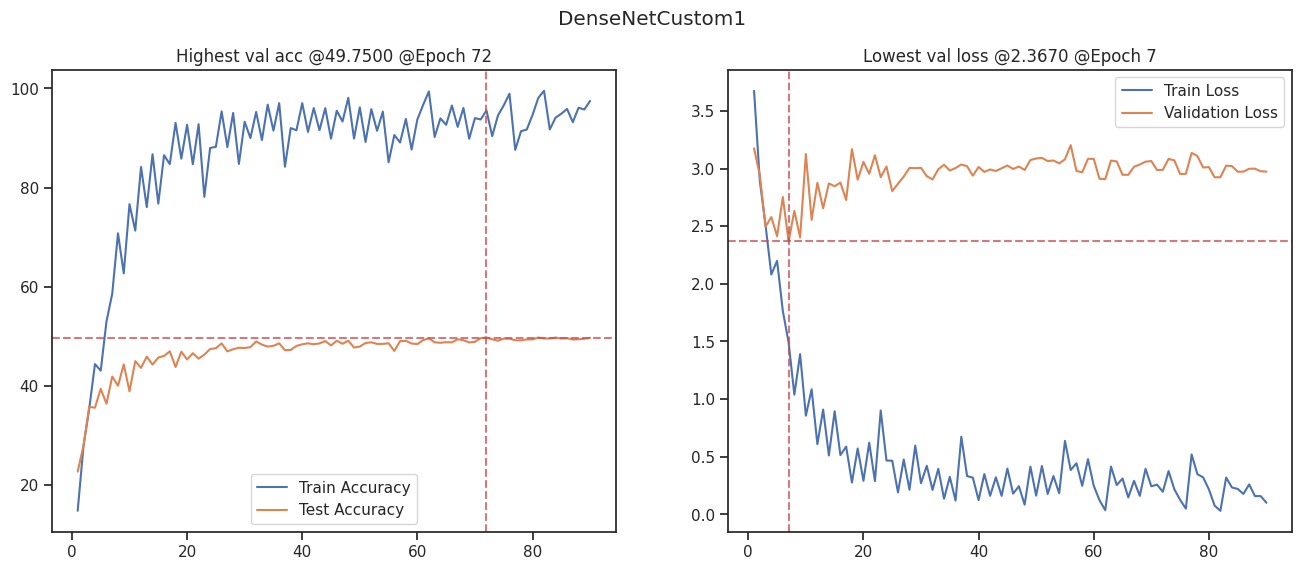

In [ ]:
display(hist_df.iloc[4])
plot_history(train_loss10, train_acc10, val_loss10, val_acc10, epoch_his10,'DenseNetCustom1')

### 3.3.2) Model Training for coarse labels
- I will cut down on the models used, by using those models that work well when training fine labelled models.

In [ ]:
print('Baseline - VGGNet inspired (Coarse)')
train_loss11, train_acc11, val_loss11, val_acc11, epoch_his11, hist_df = _train(BaselineCoarse,'Baseline (VGG inspired) - Coarse','9,198,276',False,df=hist_df,labels=trainlabel_coarse,val_loader=valloader_coarse)

Baseline - VGGNet inspired (Coarse)
- [Epoch 10/125] | Train Loss: 0.903| Train Accuracy: 70.94 | Val Loss: 1.465 | Val Accuracy: 59.79 | Est: 76.26s
- [Epoch 20/125] | Train Loss: 0.265| Train Accuracy: 91.56 | Val Loss: 1.842 | Val Accuracy: 64.08 | Est: 78.72s
- [Epoch 30/125] | Train Loss: 0.271| Train Accuracy: 91.88 | Val Loss: 1.806 | Val Accuracy: 66.77 | Est: 76.36s
- [Epoch 40/125] | Train Loss: 0.189| Train Accuracy: 94.23875 | Val Loss: 1.979 | Val Accuracy: 67.61 | Est: 76.52s
- [Epoch 50/125] | Train Loss: 0.136| Train Accuracy: 95.94375 | Val Loss: 1.853 | Val Accuracy: 67.96 | Est: 76.38s
- [Epoch 60/125] | Train Loss: 0.092| Train Accuracy: 97.36 | Val Loss: 1.906 | Val Accuracy: 67.58 | Est: 76.43s
EarlyStopper triggered at epochs: 65 
*No improvement to validation loss and accuracy could be seen for the past 18 epochs
Highest Val Accuracy: 68.8  @ epoch 47 | Lowest Val Loss: 1.2529150903224946  @ epoch 13


Lowest Val Loss                                    1.252915
Highest Val Acc                                        68.8
Lowest Train Loss                                  0.092217
Highest Train Acc                                     97.36
Epoch (Highest Val Acc)                                  47
Model Description          Baseline (VGG inspired) - Coarse
Parameter                                         9,198,276
Name: 0, dtype: object

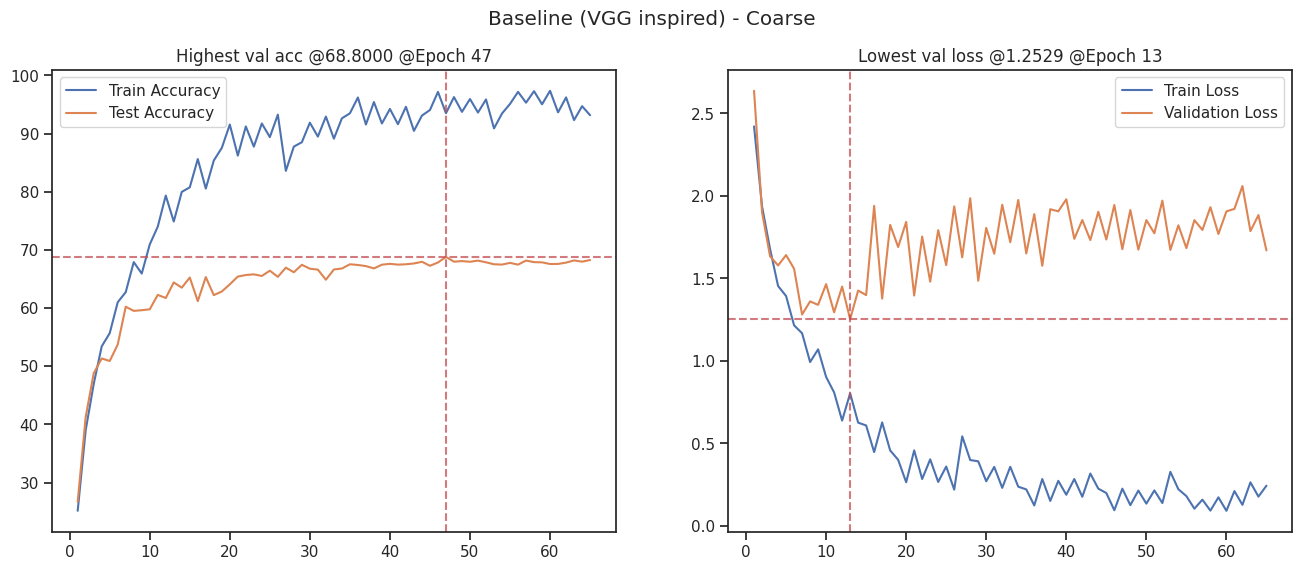

In [ ]:
display(hist_df.iloc[5])
plot_history(train_loss11, train_acc11, val_loss11, val_acc11, epoch_his11,'Baseline (VGG inspired) - Coarse')

In [ ]:
print('ResNeXtCustom1 (Coarse)')
train_loss12, train_acc12, val_loss12, val_acc12, epoch_his12, hist_df = _train(ResNeXtCustom1Coarse,'ResNeXt-M - Coarse','23,184,804',True,df=hist_df,labels=trainlabel_coarse,val_loader=valloader_coarse)

ResNeXtCustom1 (Coarse)
- [Epoch 10/125] | Train Loss: 0.372| Train Accuracy: 88.43875 | Val Loss: 2.317 | Val Accuracy: 54.61 | Est: 209.10s
- [Epoch 20/125] | Train Loss: 0.215| Train Accuracy: 93.38875 | Val Loss: 2.516 | Val Accuracy: 57.86 | Est: 209.42s
- [Epoch 30/125] | Train Loss: 0.134| Train Accuracy: 96.2 | Val Loss: 2.405 | Val Accuracy: 56.64 | Est: 211.34s
- [Epoch 40/125] | Train Loss: 0.153| Train Accuracy: 95.32875 | Val Loss: 2.650 | Val Accuracy: 57.73 | Est: 209.39s
- [Epoch 50/125] | Train Loss: 0.163| Train Accuracy: 95.3125 | Val Loss: 2.430 | Val Accuracy: 59.71 | Est: 209.08s
- [Epoch 60/125] | Train Loss: 0.060| Train Accuracy: 98.35125 | Val Loss: 2.255 | Val Accuracy: 60.49 | Est: 211.36s
EarlyStopper triggered at epochs: 64 
*No improvement to validation loss and accuracy could be seen for the past 18 epochs
Highest Val Accuracy: 60.92  @ epoch 46 | Lowest Val Loss: 1.5609867513179778  @ epoch 7


Lowest Val Loss                      1.560987
Highest Val Acc                         60.92
Lowest Train Loss                    0.026511
Highest Train Acc                     99.3425
Epoch (Highest Val Acc)                    46
Model Description          ResNeXt-M - Coarse
Parameter                          23,184,804
Name: 0, dtype: object

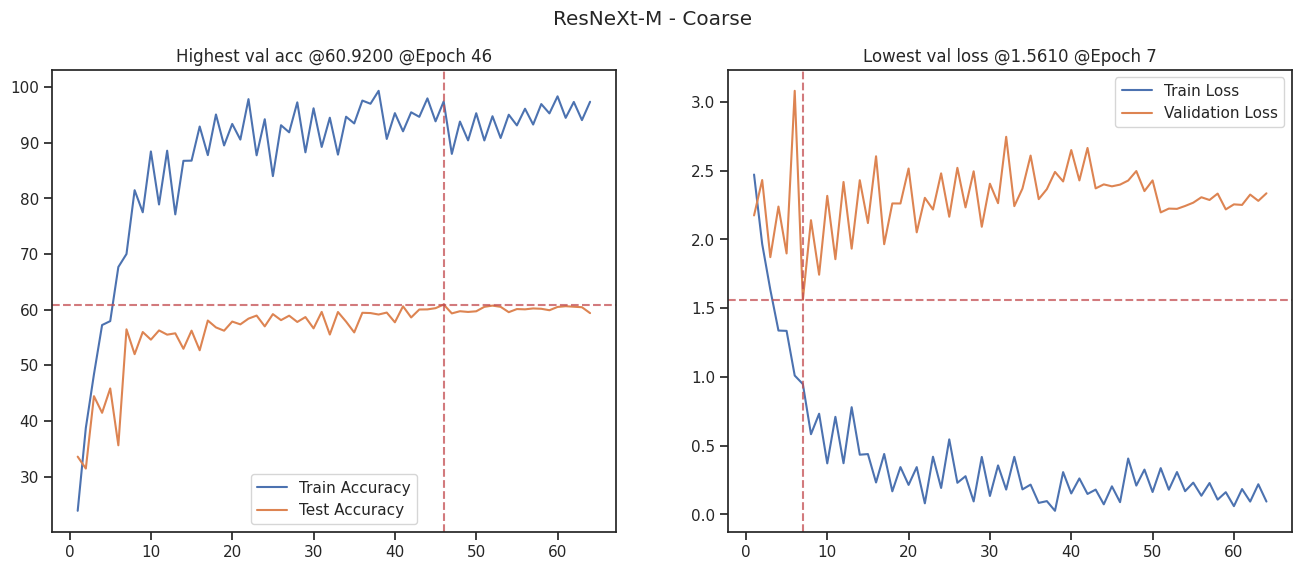

In [ ]:
display(hist_df.iloc[6])
plot_history(train_loss12, train_acc12, val_loss12, val_acc12, epoch_his12,'ResNeXt-M - Coarse')

In [ ]:
print('CoAtNetCustom1 - Coarse')
train_loss13, train_acc13, val_loss13, val_acc13, epoch_his13, hist_df = _train(CoAtNetCustom1Coarse,'CoAtNet-S - Coarse','32,396,096',True,df=hist_df,labels=trainlabel_coarse,val_loader=valloader_coarse)

CoAtNetCustom1 - Coarse
- [Epoch 10/125] | Train Loss: 0.531| Train Accuracy: 82.5525 | Val Loss: 1.981 | Val Accuracy: 53.36 | Est: 271.33s
- [Epoch 20/125] | Train Loss: 0.244| Train Accuracy: 92.25125 | Val Loss: 2.402 | Val Accuracy: 58.48 | Est: 271.67s
- [Epoch 30/125] | Train Loss: 0.081| Train Accuracy: 97.5225 | Val Loss: 2.413 | Val Accuracy: 61.57 | Est: 276.92s
- [Epoch 40/125] | Train Loss: 0.166| Train Accuracy: 94.8975 | Val Loss: 2.905 | Val Accuracy: 62.53 | Est: 272.13s
- [Epoch 50/125] | Train Loss: 0.055| Train Accuracy: 98.33875 | Val Loss: 2.843 | Val Accuracy: 63.0 | Est: 270.02s
- [Epoch 60/125] | Train Loss: 0.083| Train Accuracy: 97.69125 | Val Loss: 2.462 | Val Accuracy: 62.67 | Est: 272.40s
- [Epoch 70/125] | Train Loss: 0.049| Train Accuracy: 98.71625 | Val Loss: 2.479 | Val Accuracy: 63.41 | Est: 270.50s
- [Epoch 80/125] | Train Loss: 0.049| Train Accuracy: 98.5975 | Val Loss: 2.400 | Val Accuracy: 63.59 | Est: 277.23s
- [Epoch 90/125] | Train Loss: 0.090|

Lowest Val Loss                      1.475237
Highest Val Acc                         64.04
Lowest Train Loss                    0.001255
Highest Train Acc                      99.995
Epoch (Highest Val Acc)                    85
Model Description          CoAtNet-S - Coarse
Parameter                          32,396,096
Name: 0, dtype: object

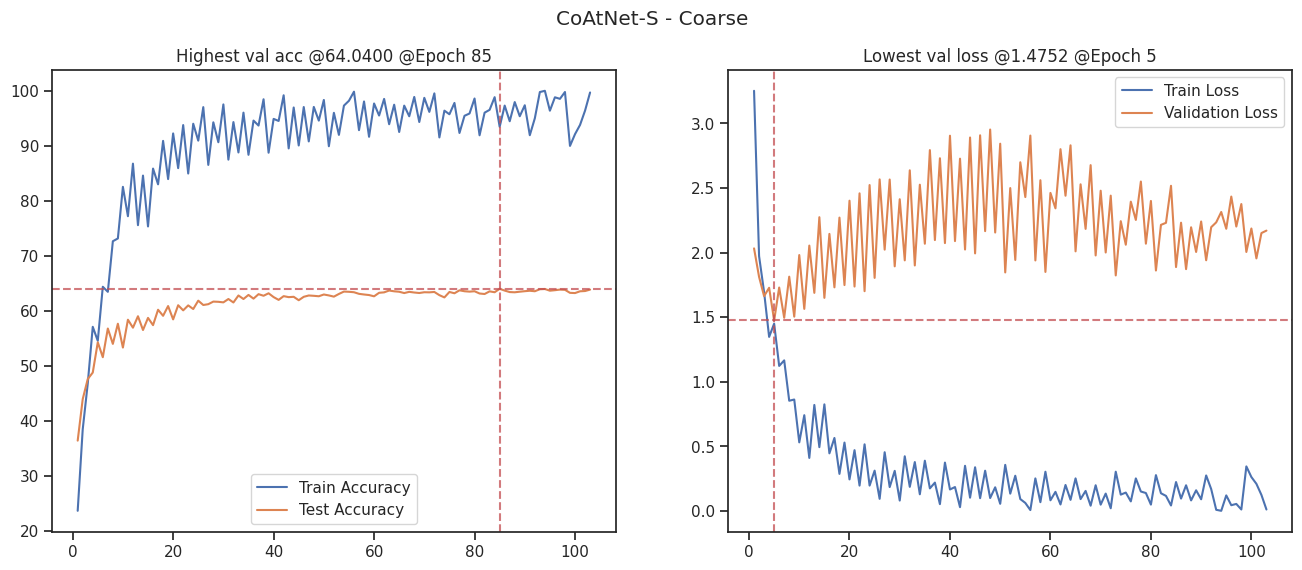

In [ ]:
display(hist_df.iloc[7])
plot_history(train_loss13, train_acc13, val_loss13, val_acc13, epoch_his13,'CoAtNet-S - Coarse')

In [ ]:
hist_df

Lowest Val Loss  Highest Val Acc  Lowest Train Loss  Highest Train Acc  \
0         1.981114            53.37           0.095882           97.58750   
0         2.512835            48.86           0.045856           99.10125   
0         2.481324            48.89           0.034021           99.35750   
0         2.202396            54.66           0.004562           99.94875   
0         2.366959            49.75           0.030436           99.52000   
0         1.252915            68.80           0.092217           97.36000   
0         1.560987            60.92           0.026511           99.34250   
0         1.475237            64.04           0.001255           99.99500   

  Epoch (Highest Val Acc)                 Model Description   Parameter  
0                      71           Baseline (VGG inspired)   9,198,276  
0                      54                          ResNet34  23,712,932  
0                      49                         ResNeXt-M  23,184,804  
0                      80                         CoAtNet-S  32,396,096  
0                      72                        DenseNet-M  20,013,928  
0                      47  Baseline (VGG inspired) - Coarse   9,198,276  
0                      46                ResNeXt-M - Coarse  23,184,804  
0                      85                CoAtNet-S - Coarse  32,396,096

Seems like CoAtNet performs the best for fine labels while the Baseline perform the best for coarse labelled data. I suspect that CoAtNet actually works best for both fine and coarse labelled data. However, it did not perform as well as it is overfitting too much compared to my simpler Baseline model (Training accuracy @ 97+%). Highest training accuracy is always very high (99+%) for our complex models which means our weight decay or more importantly our data augmentation have to be much better and stronger before we see my complex model overtake my baseline model here. I believe with much stronger data augmentation CoAtNet can out perform our Baseline model with no problem. For model improvement, much consideration will be put into augmenting our data.

# 4.0) Model Improvement/Tuning
### **Discussion** (Hyperparameter tuning):
Can we still do hyperparameter tuning even when our models become more and more complex with the current computational power I have? All in all yes. However, unlike Part A, my hyperparameter tuning method has to be more efficient. In Part A (FashionMNIST), coarse to fine is perfect as our model is not too complex and I can search about 150 trials every 10 hours. However, with millions upon millions of parameters a more efficient hyperparameter tuning technique is needed.<br>

What makes hyperparameter tuning a complex model extremely time and computationally intensive? It is the number of epochs, FLOPS (computational power) and time it takes to reach anywhere close to the local minima. Say, I need an average 250 epochs to reach the local minima of my complex model, and hyperparameter tuning 150 trials for 250 epochs would take extremely long that it would become impractical, even for a hyperparameter technique like coarse to fine in Part A [[Kiddon et al., 2010](http://turing.cs.washington.edu/papers/aaai11-kiddon.pdf)]. However, I can cut down the number of epochs, FLOPS and time of each trial by cutting down the most time intensive part of training a complex model which is the start. If I train a model with a slightly lower learning rate with relatively higher weight decay for the first 200 epoch, I can just simply start my hyperparameter tuning at epoch 200. This will cut down my hyperparameter tuning time by skipping that initial (time consuming) 200 epochs. However some rules have to be applied as followed.<br>

Augmentation have to be reapplied regularly, if augmentation is not done after transfering the weights of my model at epoch 200. The local minima will remain the same, as the training set did not change at all, regardless whether I have applied my augmentation before training. Secondly, I will use a relatively high weight decay during the first 200 epoch, this allow the weights during hyperparameter tuning to fit more to its new parameters that I set.


<br><br>
Models we are tuning:
- CoAtNet for fine labels
- CoAtNet for coarse labels
- SimpleNet/Baseline (alias) for coarse labels


<br>

<u>**What are some ways to improve our models for fine/coarse dataset?**</u>

<br>

1) **Choosing right augmentation & sampling/replication method:**

- Which sets of augmentation shows the most improvement to our model?
- Augmentation batch size and number of times to augment each epoch
- Which sampling method is better?

2) **Tuning model complexity:**
- Change number of filters/layers for our models
- Include dropout
- Inclue downsample

3) **Hyperparameter tuning (see Discussion)**:
- Learning rate
- Weight decay
- Momentum

4) **Transfer learning (between my own models only) - [no external weights]:**
- Transfering weights that are already SOTA would be cheating in my opinion for this assignment, many SOTA models are trained with extra images. I will limit myself to the dataset I currently have. One example I find misleading would be, the current SOTA CIFAR100 model, efficient adaptive ensembling claims to have an accuracy of 96.808% without using any extra training data on [paperswithcode](https://paperswithcode.com/sota/image-classification-on-cifar-100). However, I found it misleading after realising they used pre-trained weights (fine-tuning), which is trained with extra training data...[[Bruno et al., 2022 ](https://arxiv.org/pdf/2206.07394v2.pdf)] - Page 13
- Transferring my fine label model's weights to my coarse label model and see whether is has improvement after training for awhile.


<br><br>
SAM optimizer will used as from seen Part A and the original technical paper [[Foret el at., 2020](https://arxiv.org/abs/2010.01412)], it has shown consitently better generalization over SGD optimizer.

In [ ]:
!git clone https://github.com/davda54/sam.git

Cloning into 'sam'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 200 (delta 73), reused 66 (delta 60), pack-reused 104
Receiving objects: 100% (200/200), 659.65 KiB | 3.58 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [ ]:
from sam.sam import SAM

In [ ]:
df_augmentation = pd.DataFrame([],columns=['Lowest Val Loss','Highest Val Acc','Lowest Train Loss','Epoch (Highest Val Acc)', 'Model Description', 'Parameter'])

New function has to be written for SAM optimizer

In [ ]:
def train_sam(model, input_, label_ , optimizer, NUM_EPOCHS, criterion, valloader=None,earlystopper=None,showEpoch=True,scheduler=None,displayEvery=1,augmentEvery=None,augCompose1_=imageAutoAugment,augCompose2_=imageAutoAugment,sampleMode=2,augBatch=1250,classNo=100):
    train_loss_his = []
    train_accuracy_his = []
    val_loss_his = []
    val_accuracy_his = []
    epoch_his = []
    earlystopper.reset()
    model.train()
    for epoch in range(NUM_EPOCHS):
        t0 = time.time()
        total = 0
        correct = 0
        running_loss = 0.0
        if augmentEvery != None:
            if epoch % augmentEvery == 0 and sampleMode == 1:
                input_rep, label_rep = replicateData1(traindata=input_,augCompose=augCompose1_,augBatch=augBatch,trainlabel=label_,classNum_=classNo)
                loader = DataLoader(TensorDataset(input_rep.type('torch.FloatTensor'),label_rep.type('torch.FloatTensor')), shuffle=False, batch_size=BATCH_SIZE)
                # The augmented dataset is already shuffled
            elif epoch % augmentEvery == 0 and sampleMode == 2:
                input_rep, label_rep = replicateData2(traindata=input_,augCompose=augCompose1_,augBatch=augBatch,trainlabel=label_)
                loader = DataLoader(TensorDataset(input_rep.type('torch.FloatTensor'),label_rep.type('torch.FloatTensor')), shuffle=False, batch_size=BATCH_SIZE)
            elif epoch % augmentEvery == 0 and sampleMode == 3:
                input_rep, label_rep = replicateData3(traindata=input_,augCompose1=augCompose1_,augCompose2=augCompose2_,augBatch=augBatch,trainlabel=label_)
            elif epoch % augmentEvery == 0 and sampleMode == 4:
                input_rep, label_rep = replicateData4(traindata=input_,augCompose1=augCompose1_,augCompose2=augCompose2_,augBatch=augBatch,trainlabel=label_)
                loader = DataLoader(TensorDataset(input_rep.type('torch.FloatTensor'),label_rep.type('torch.FloatTensor')), shuffle=False, batch_size=BATCH_SIZE)
            elif epoch % augmentEvery == 0 and sampleMode == 5:
                input_rep, label_rep = replicateData5(augCompose1=augCompose1_,augBatch=augBatch,trainlabel=label_)
                loader = DataLoader(TensorDataset(input_rep.type('torch.FloatTensor'),label_rep.type('torch.FloatTensor')), shuffle=False, batch_size=BATCH_SIZE)
            
        else:
            loader = DataLoader(TensorDataset(input_.type('torch.FloatTensor'),label.type('torch.FloatTensor')), shuffle=True, batch_size=BATCH_SIZE)
        for data in loader:
            img, label = data 
            img = img.to(device)
            label = label.to(device)
            outputs = model(img)
            loss = criterion(outputs, label)  # use this loss for any training statistics
            loss.backward()
            optimizer.first_step(zero_grad=True)
            outputs = model(img)
          # second forward-backward pass
            criterion(outputs, label).backward()  # make sure to do a full forward pass
            optimizer.second_step(zero_grad=True)
            correct += (outputs.argmax(-1) == label.argmax(-1)).sum().item()
            total += label.size(0)
            running_loss += loss.item()
        scheduler.step()
        accuracy = 100 * correct / total
        loss = running_loss / len(loader)
        train_loss_his.append(loss)
        train_accuracy_his.append(accuracy)
        val_loss, val_accuracy = validate(model, criterion, valloader)
        val_loss_his.append(val_loss)
        val_accuracy_his.append(val_accuracy)
        epoch_his.append(epoch+1)
        if showEpoch and (epoch+1)%displayEvery == 0:
            print(f'- [Epoch {epoch+1}/{NUM_EPOCHS}] | Train Loss: {loss:.3f}| Train Accuracy: {accuracy} | Val Loss: {val_loss:.3f} | Val Accuracy: {val_accuracy} | Est: {(time.time() - t0)*displayEvery:.2f}s')
        if earlyStopper(val_accuracy,val_loss):
            print(f'EarlyStopper triggered at epochs: {epoch+1} \n*No improvement to validation loss and accuracy could be seen for the past {earlyStopper.patience} epochs')
            break
    print(f'Highest Val Accuracy: {max(val_accuracy_his)}  @ epoch {epoch_his[val_accuracy_his.index(max(val_accuracy_his))]} | Lowest Val Loss: {min(val_loss_his)}  @ epoch {epoch_his[val_loss_his.index(min(val_loss_his))]}')
    return train_loss_his, train_accuracy_his, val_loss_his, val_accuracy_his,epoch_his

Initilizing our model for fine and coarse data

In [ ]:
def _train(model_desc,augCompose1, augCompose2,df,sampleMode=3,fine=True,lr_=0.01):
    global df_augmentation
    if fine:
        parameters_desc = "32,396,096"
        model = CoAtNet((32, 32), 3, [2, 2, 6, 14, 2], [64, 96, 192, 384, 768], num_classes=100)
        base_optimizer = optim.SGD
        optimizer = SAM(model.parameters(), base_optimizer, lr = lr_, momentum=0.90, weight_decay=0.0000025)
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
        model = nn.DataParallel(model)
        model.to(device)
        train_loss, train_acc, val_loss, val_acc, epoch_his = train_sam(model, traindata_input,traindata_label, optimizer, 125, criterion,valloader,earlyStopper,augCompose1_=augCompose1, augCompose2_=augCompose2,scheduler=scheduler,augmentEvery=1,displayEvery=10,sampleMode=sampleMode)
    else:
        parameters_desc = "9,198,276"
        model = SimpleNet([2,3,4,4],3,32,2,2048,20)
        base_optimizer = optim.SGD
        optimizer = SAM(model.parameters(), base_optimizer, lr = lr_, momentum=0.90, weight_decay=0.0000025)
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
        model = nn.DataParallel(model)
        model.to(device)
        train_loss, train_acc, val_loss, val_acc, epoch_his = train_sam(model, traindata_input,trainlabel_coarse, optimizer, 125, criterion,valloader_coarse,earlyStopper,augCompose1_=augCompose1, augCompose2_=augCompose2,scheduler=scheduler,augmentEvery=1,displayEvery=10,sampleMode=sampleMode,classNo=20)
    df = keep_history(df,train_acc,train_loss, val_loss, val_acc, epoch_his,model_desc,parameters_desc)
    return train_loss, train_acc, val_loss, val_acc, epoch_his, df

## 4.1) Finding the right augmentation & sampling method
I have made some sampling/replication methods in my train_sam function:<br>
- sampleMode 0: Traditional augmentation every N epoch, no replication is done.
- sampleMode 1: Replicate to 120K samples, apply a selected augmentation for the first replicated 40K samples, and CutMix for the second replicated 40K samples. Augmentation done every N epoch. Last 40K sample will remain untouched. -> 120K samples in total
- sampleMode3: Replicate to 120K samples, apply the first selected augmentation for first 40K samples and the second selected augmentation on the next 40K. Last 40K is untouched. Augmentation done every N epoch. -> 120K samples in total
- sampleMode4: Replicate to 80K samples, apply the first selected augmentation for first 40K samples and the second selected augmentation on the next 40K. -> 80K samples in total
- sampleMode5: Replicate to 80K samples, first 40K samples are all horizontally flipped. Augmentation is then applied to all the samples. -> 80K samples in total
<br><br>

Combinations of augmentation to use will be based on intuition instead of permutation...permutation of every augmentation set will be too time consuming.

sampleMode0: Try all different sets of augmentation I currently have on fine-labelled data
- Depending on the results for our fine-labelled data I will know which augmentation is likely to fit coarse-labelled data as well.

In [ ]:
_,_,_,_,_,df_augmentation = _train("CoAtNet-AutoAugment sample:0", imageAutoAugment2,None, df_augmentation,0,True,lr_=0.014)

- [Epoch 10/125] | Train Loss: 2.287| Train Accuracy: 37.295 | Val Loss: 2.998 | Val Accuracy: 30.36 | Est: 287.67s
- [Epoch 20/125] | Train Loss: 1.742| Train Accuracy: 50.2675 | Val Loss: 2.422 | Val Accuracy: 40.54 | Est: 287.88s
- [Epoch 30/125] | Train Loss: 0.748| Train Accuracy: 77.175 | Val Loss: 2.281 | Val Accuracy: 45.45 | Est: 269.64s
- [Epoch 40/125] | Train Loss: 1.206| Train Accuracy: 66.5575 | Val Loss: 2.535 | Val Accuracy: 40.51 | Est: 299.86s
- [Epoch 50/125] | Train Loss: 0.710| Train Accuracy: 79.505 | Val Loss: 2.469 | Val Accuracy: 42.86 | Est: 277.39s
- [Epoch 60/125] | Train Loss: 0.331| Train Accuracy: 89.025 | Val Loss: 2.255 | Val Accuracy: 47.9 | Est: 294.00s
- [Epoch 70/125] | Train Loss: 0.523| Train Accuracy: 83.77 | Val Loss: 2.217 | Val Accuracy: 48.6 | Est: 281.45s
- [Epoch 80/125] | Train Loss: 0.814| Train Accuracy: 76.7725 | Val Loss: 2.815 | Val Accuracy: 38.67 | Est: 300.41s
- [Epoch 90/125] | Train Loss: 0.517| Train Accuracy: 83.9725 | Val Loss

In [ ]:
_,_,_,_,_,df_augmentation = _train("CoAtNet-AugMix sample:0", imageAugMix2,None, df_augmentation,0,True,lr_=0.005)

- [Epoch 10/125] | Train Loss: 1.667| Train Accuracy: 48.3825 | Val Loss: 2.860 | Val Accuracy: 30.61 | Est: 333.81s
- [Epoch 20/125] | Train Loss: 0.439| Train Accuracy: 81.215 | Val Loss: 3.357 | Val Accuracy: 31.07 | Est: 327.65s
- [Epoch 30/125] | Train Loss: 0.347| Train Accuracy: 86.895 | Val Loss: 3.262 | Val Accuracy: 33.59 | Est: 366.19s
- [Epoch 40/125] | Train Loss: 0.141| Train Accuracy: 94.4025 | Val Loss: 3.276 | Val Accuracy: 34.35 | Est: 334.79s
- [Epoch 50/125] | Train Loss: 0.130| Train Accuracy: 94.48 | Val Loss: 3.238 | Val Accuracy: 34.89 | Est: 310.43s
- [Epoch 60/125] | Train Loss: 0.153| Train Accuracy: 93.7425 | Val Loss: 3.241 | Val Accuracy: 34.8 | Est: 346.01s
- [Epoch 70/125] | Train Loss: 0.080| Train Accuracy: 96.5 | Val Loss: 3.168 | Val Accuracy: 35.44 | Est: 347.28s
- [Epoch 80/125] | Train Loss: 0.143| Train Accuracy: 93.9775 | Val Loss: 3.180 | Val Accuracy: 35.79 | Est: 356.59s
- [Epoch 90/125] | Train Loss: 0.173| Train Accuracy: 93.4125 | Val Loss

Epochs is switched from 125 epochs to 70 epochs as I realised anything improvement after 70 epochs is quite negliable.

In [ ]:
_,_,_,_,_,df_augmentation = _train("CoAtNet-ImageNet sample:0", imageAutoAugmentImageNet2,None, df_augmentation,0,True,lr_=0.008)

- [Epoch 10/70] | Train Loss: 2.791| Train Accuracy: 26.78 | Val Loss: 2.853 | Val Accuracy: 29.48 | Est: 343.69s
- [Epoch 20/70] | Train Loss: 2.194| Train Accuracy: 39.24 | Val Loss: 2.521 | Val Accuracy: 37.46 | Est: 338.53s
- [Epoch 30/70] | Train Loss: 1.657| Train Accuracy: 51.21 | Val Loss: 2.309 | Val Accuracy: 41.61 | Est: 301.34s
- [Epoch 40/70] | Train Loss: 1.153| Train Accuracy: 66.8175 | Val Loss: 2.355 | Val Accuracy: 42.2 | Est: 325.92s
- [Epoch 50/70] | Train Loss: 1.426| Train Accuracy: 58.335 | Val Loss: 2.809 | Val Accuracy: 36.88 | Est: 309.64s
- [Epoch 60/70] | Train Loss: 0.976| Train Accuracy: 70.35 | Val Loss: 2.247 | Val Accuracy: 45.52 | Est: 332.55s
- [Epoch 70/70] | Train Loss: 0.720| Train Accuracy: 76.775 | Val Loss: 2.269 | Val Accuracy: 45.66 | Est: 287.11s
Highest Val Accuracy: 46.17  @ epoch 68 | Lowest Val Loss: 2.238827347755432  @ epoch 42


In [ ]:
_,_,_,_,_,df_augmentation = _train("CoAtNet-CustomAugment sample:0", imageColorTrans2,None, df_augmentation,0,True)

- [Epoch 10/70] | Train Loss: 2.357| Train Accuracy: 34.71 | Val Loss: 2.756 | Val Accuracy: 31.97 | Est: 315.47s
- [Epoch 20/70] | Train Loss: 1.576| Train Accuracy: 52.715 | Val Loss: 2.584 | Val Accuracy: 37.36 | Est: 317.87s
- [Epoch 30/70] | Train Loss: 1.146| Train Accuracy: 63.215 | Val Loss: 2.607 | Val Accuracy: 38.56 | Est: 316.01s
- [Epoch 40/70] | Train Loss: 0.505| Train Accuracy: 80.555 | Val Loss: 2.625 | Val Accuracy: 40.85 | Est: 315.92s
- [Epoch 50/70] | Train Loss: 0.379| Train Accuracy: 86.13 | Val Loss: 2.624 | Val Accuracy: 42.0 | Est: 320.19s
- [Epoch 60/70] | Train Loss: 0.524| Train Accuracy: 82.5 | Val Loss: 3.046 | Val Accuracy: 36.35 | Est: 315.09s
- [Epoch 70/70] | Train Loss: 0.468| Train Accuracy: 83.3225 | Val Loss: 2.898 | Val Accuracy: 39.41 | Est: 316.28s
Highest Val Accuracy: 44.15  @ epoch 69 | Lowest Val Loss: 2.335602509975433  @ epoch 19


In [ ]:
_,_,_,_,_,df_augmentation = _train("CoAtNet-AutoAugment+CutMix sample:1", imageAutoAugment,None, df_augmentation,1,True,lr_=0.0125)

- [Epoch 10/70] | Train Loss: 1.682| Train Accuracy: 59.98416666666667 | Val Loss: 1.946 | Val Accuracy: 49.5 | Est: 773.77s
- [Epoch 20/70] | Train Loss: 1.364| Train Accuracy: 68.8 | Val Loss: 1.823 | Val Accuracy: 53.44 | Est: 775.08s
- [Epoch 30/70] | Train Loss: 1.116| Train Accuracy: 75.86083333333333 | Val Loss: 1.769 | Val Accuracy: 54.96 | Est: 779.38s
- [Epoch 40/70] | Train Loss: 1.038| Train Accuracy: 77.82416666666667 | Val Loss: 1.764 | Val Accuracy: 55.51 | Est: 768.73s
- [Epoch 50/70] | Train Loss: 1.192| Train Accuracy: 73.16666666666667 | Val Loss: 1.721 | Val Accuracy: 55.82 | Est: 807.53s
- [Epoch 60/70] | Train Loss: 1.009| Train Accuracy: 79.55916666666667 | Val Loss: 1.706 | Val Accuracy: 56.87 | Est: 773.27s
- [Epoch 70/70] | Train Loss: 0.998| Train Accuracy: 79.66416666666667 | Val Loss: 1.702 | Val Accuracy: 56.61 | Est: 776.10s
Highest Val Accuracy: 57.16  @ epoch 67 | Lowest Val Loss: 1.6873259544372559  @ epoch 62


output for this cell was accidentally removed here

In [ ]:
_,_,_,_,_,df_augmentation = _train("CoAtNet-ImageNet+CutMix sample:1", imageAutoAugmentImageNet,None, df_augmentation,1,True,lr_=0.014)

In [ ]:
_,_,_,_,_,df_augmentation = _train("CoAtNet-AutoAugment+ImageNet sample:3", imageAutoAugment,imageAutoAugmentImageNet, df_augmentation,1,True,lr_=0.008)

- [Epoch 10/70] | Train Loss: 2.006| Train Accuracy: 51.685 | Val Loss: 2.021 | Val Accuracy: 47.22 | Est: 799.56s
- [Epoch 20/70] | Train Loss: 1.418| Train Accuracy: 68.05416666666666 | Val Loss: 1.891 | Val Accuracy: 51.05 | Est: 756.33s
- [Epoch 30/70] | Train Loss: 1.283| Train Accuracy: 71.29583333333333 | Val Loss: 1.836 | Val Accuracy: 52.88 | Est: 783.18s
- [Epoch 40/70] | Train Loss: 1.239| Train Accuracy: 71.75333333333333 | Val Loss: 1.791 | Val Accuracy: 53.74 | Est: 762.96s
- [Epoch 50/70] | Train Loss: 1.119| Train Accuracy: 77.13833333333334 | Val Loss: 1.788 | Val Accuracy: 54.57 | Est: 773.15s
- [Epoch 60/70] | Train Loss: 1.086| Train Accuracy: 76.675 | Val Loss: 1.767 | Val Accuracy: 54.83 | Est: 774.90s
- [Epoch 70/70] | Train Loss: 1.069| Train Accuracy: 76.88666666666667 | Val Loss: 1.748 | Val Accuracy: 55.14 | Est: 789.00s
Highest Val Accuracy: 55.29  @ epoch 61 | Lowest Val Loss: 1.748326873779297  @ epoch 70


In [ ]:
_,_,_,_,_,df_augmentation = _train("CoAtNet-AutoAugment+ImageNet sample:4", imageAutoAugment,imageAutoAugmentImageNet, df_augmentation,4,True,lr_=0.008)

- [Epoch 10/70] | Train Loss: 2.067| Train Accuracy: 42.42 | Val Loss: 2.157 | Val Accuracy: 43.24 | Est: 567.63s
- [Epoch 20/70] | Train Loss: 1.482| Train Accuracy: 57.215 | Val Loss: 2.007 | Val Accuracy: 47.93 | Est: 594.95s
- [Epoch 30/70] | Train Loss: 0.934| Train Accuracy: 71.0875 | Val Loss: 1.973 | Val Accuracy: 50.31 | Est: 588.70s
- [Epoch 40/70] | Train Loss: 0.787| Train Accuracy: 75.5 | Val Loss: 1.925 | Val Accuracy: 51.61 | Est: 597.81s
- [Epoch 50/70] | Train Loss: 0.854| Train Accuracy: 74.785 | Val Loss: 1.897 | Val Accuracy: 52.39 | Est: 617.75s
- [Epoch 60/70] | Train Loss: 0.705| Train Accuracy: 77.4475 | Val Loss: 1.913 | Val Accuracy: 52.42 | Est: 570.34s
- [Epoch 70/70] | Train Loss: 0.679| Train Accuracy: 78.16375 | Val Loss: 1.862 | Val Accuracy: 53.52 | Est: 569.28s
Highest Val Accuracy: 53.67  @ epoch 67 | Lowest Val Loss: 1.853470641374588  @ epoch 67


In [ ]:
_,_,_,_,_,df_augmentation = _train("CoAtNet-AutoAugment sample:5", imageAutoAugment2,None, df_augmentation,5,True,lr_=0.008)

- [Epoch 20/125] | Train Loss: 1.587| Train Accuracy: 54.36375 | Val Loss: 1.808 | Val Accuracy: 52.15 | Est: 567.60s
- [Epoch 30/125] | Train Loss: 1.112| Train Accuracy: 65.52125 | Val Loss: 1.804 | Val Accuracy: 53.23 | Est: 544.91s
- [Epoch 40/125] | Train Loss: 0.864| Train Accuracy: 72.82625 | Val Loss: 1.782 | Val Accuracy: 54.98 | Est: 568.62s
- [Epoch 50/125] | Train Loss: 0.971| Train Accuracy: 71.1525 | Val Loss: 1.799 | Val Accuracy: 54.8 | Est: 560.19s
- [Epoch 60/125] | Train Loss: 0.301| Train Accuracy: 88.78875 | Val Loss: 1.823 | Val Accuracy: 55.65 | Est: 564.30s
- [Epoch 70/125] | Train Loss: 0.435| Train Accuracy: 84.74875 | Val Loss: 1.801 | Val Accuracy: 55.8 | Est: 586.98s
- [Epoch 80/125] | Train Loss: 0.938| Train Accuracy: 71.675 | Val Loss: 1.798 | Val Accuracy: 56.36 | Est: 535.43s
- [Epoch 90/125] | Train Loss: 0.599| Train Accuracy: 80.85125 | Val Loss: 1.797 | Val Accuracy: 55.91 | Est: 554.43s
- [Epoch 100/125] | Train Loss: 0.630| Train Accuracy: 78.96 

In [ ]:
_,_,_,_,_,df_augmentation = _train("CoAtNet-ImageNet sample:5", imageAutoAugmentImageNet2,None, df_augmentation,5,True,lr_=0.01)

- [Epoch 20/125] | Train Loss: 1.742| Train Accuracy: 48.525 | Val Loss: 1.847 | Val Accuracy: 50.79 | Est: 630.41s
- [Epoch 30/125] | Train Loss: 1.212| Train Accuracy: 61.99625 | Val Loss: 1.760 | Val Accuracy: 53.85 | Est: 612.16s
- [Epoch 40/125] | Train Loss: 1.122| Train Accuracy: 65.38125 | Val Loss: 1.765 | Val Accuracy: 54.53 | Est: 642.32s
- [Epoch 70/125] | Train Loss: 0.648| Train Accuracy: 78.71 | Val Loss: 1.790 | Val Accuracy: 55.62 | Est: 678.14s
- [Epoch 90/125] | Train Loss: 0.623| Train Accuracy: 79.265 | Val Loss: 1.787 | Val Accuracy: 56.25 | Est: 629.20s
- [Epoch 100/125] | Train Loss: 0.612| Train Accuracy: 79.35 | Val Loss: 1.786 | Val Accuracy: 56.05 | Est: 603.89s
- [Epoch 110/125] | Train Loss: 0.649| Train Accuracy: 77.97375 | Val Loss: 1.801 | Val Accuracy: 55.91 | Est: 653.87s
- [Epoch 120/125] | Train Loss: 0.735| Train Accuracy: 74.7725 | Val Loss: 1.815 | Val Accuracy: 55.97 | Est: 622.59s
EarlyStopper triggered at epochs: 120 
*No improvement to valida

In [ ]:
_,_,_,_,_,df_augmentation = _train("CoAtNet-AugMix sample:5", imageAugMix2,None, df_augmentation,5,True,lr_=0.0085)

- [Epoch 10/125] | Train Loss: 1.327| Train Accuracy: 56.74 | Val Loss: 2.359 | Val Accuracy: 40.98 | Est: 685.58s
- [Epoch 20/125] | Train Loss: 0.365| Train Accuracy: 85.13125 | Val Loss: 2.650 | Val Accuracy: 42.86 | Est: 694.14s
- [Epoch 30/125] | Train Loss: 0.199| Train Accuracy: 91.56125 | Val Loss: 2.688 | Val Accuracy: 43.5 | Est: 673.29s
- [Epoch 40/125] | Train Loss: 0.155| Train Accuracy: 93.25875 | Val Loss: 2.655 | Val Accuracy: 44.67 | Est: 651.22s
- [Epoch 50/125] | Train Loss: 0.131| Train Accuracy: 94.5875 | Val Loss: 2.626 | Val Accuracy: 45.1 | Est: 682.66s
- [Epoch 70/125] | Train Loss: 0.109| Train Accuracy: 95.34625 | Val Loss: 2.588 | Val Accuracy: 45.34 | Est: 716.09s


In [ ]:
df_augmentation

Lowest Val Loss  Highest Val Acc  Lowest Train Loss  \
0         2.152134            49.41           0.077599   
0         2.839644            36.12           0.072459   
0         2.238827            46.17           0.626822   
0         2.335603            44.15           0.113020   
0         1.687326            57.16           0.859597   
0         1.718855            55.71           1.011111   
0         1.748327            55.29           0.916276   
0         1.853471            53.67           0.602639   
0         1.766168            56.50           0.301244   
0         1.746079            56.72           0.435966   
0         2.358972            45.45           0.089996   

  Epoch (Highest Val Acc)                      Model Description   Parameter  \
0                      98           CoAtNet-AutoAugment sample:0  32,396,096   
0                      90                CoAtNet-AugMix sample:0  32,396,096   
0                      68              CoAtNet-ImageNet sample:0  32,396,096   
0                      69         CoAtNet-CustomAugment sample:0  32,396,096   
0                      67    CoAtNet-AutoAugment+CutMix sample:1  32,396,096   
0                      55       CoAtNet-ImageNet+CutMix sample:1  32,396,096   
0                      61  CoAtNet-AutoAugment+ImageNet sample:3  32,396,096   
0                      67  CoAtNet-AutoAugment+ImageNet sample:4  32,396,096   
0                      88           CoAtNet-AutoAugment sample:5  32,396,096   
0                     102              CoAtNet-ImageNet sample:5  32,396,096   
0                      53                CoAtNet-AugMix sample:5  32,396,096   

   Highest Train Acc  
0          97.837500  
0          96.557500  
0          79.947500  
0          94.617500  
0          83.082500  
0          79.366667  
0          80.396667  
0          80.353750  
0          88.788750  
0          85.050000  
0          95.651250


- After doing augmentation on our fine labels I will try only the top 4 highest validation accuracy augmentation on my coarse labelled data model.

In [ ]:
df_augmentation2 = pd.DataFrame([],columns=['Lowest Val Loss','Highest Val Acc','Lowest Train Loss','Epoch (Highest Val Acc)', 'Model Description', 'Parameter'])

In [ ]:
_,_,_,_,_,df_augmentation2 = _train("SimpleNet-AutoAugment+CutMix sample:1 (Coarse)", imageAutoAugment,None, df_augmentation2,1,False,lr_=0.0125)

- [Epoch 10/125] | Train Loss: 1.260| Train Accuracy: 62.505 | Val Loss: 1.086 | Val Accuracy: 65.28 | Est: 271.15s
- [Epoch 20/125] | Train Loss: 0.936| Train Accuracy: 71.52666666666667 | Val Loss: 1.009 | Val Accuracy: 70.25 | Est: 260.80s
- [Epoch 30/125] | Train Loss: 0.805| Train Accuracy: 76.92833333333333 | Val Loss: 1.002 | Val Accuracy: 71.47 | Est: 278.16s
- [Epoch 40/125] | Train Loss: 0.884| Train Accuracy: 75.04833333333333 | Val Loss: 0.999 | Val Accuracy: 71.95 | Est: 260.82s
- [Epoch 50/125] | Train Loss: 0.770| Train Accuracy: 79.7675 | Val Loss: 1.045 | Val Accuracy: 71.91 | Est: 271.93s
- [Epoch 60/125] | Train Loss: 0.581| Train Accuracy: 84.30833333333334 | Val Loss: 0.989 | Val Accuracy: 73.09 | Est: 256.20s
- [Epoch 70/125] | Train Loss: 0.666| Train Accuracy: 81.9725 | Val Loss: 0.977 | Val Accuracy: 73.37 | Est: 259.20s
- [Epoch 80/125] | Train Loss: 0.603| Train Accuracy: 85.5975 | Val Loss: 0.986 | Val Accuracy: 73.54 | Est: 265.66s
- [Epoch 90/125] | Train 

In [ ]:
_,_,_,_,_,df_augmentation2 = _train("SimpleNet-ImageNet+CutMix sample:1 (Coarse)", imageAutoAugmentImageNet,None, df_augmentation2,1,False,lr_=0.0125)

- [Epoch 10/125] | Train Loss: 1.399| Train Accuracy: 56.59916666666667 | Val Loss: 1.091 | Val Accuracy: 66.07 | Est: 307.97s
- [Epoch 20/125] | Train Loss: 0.960| Train Accuracy: 73.49333333333334 | Val Loss: 0.996 | Val Accuracy: 70.02 | Est: 297.86s
- [Epoch 30/125] | Train Loss: 0.956| Train Accuracy: 73.64083333333333 | Val Loss: 0.968 | Val Accuracy: 71.97 | Est: 301.09s
- [Epoch 40/125] | Train Loss: 0.791| Train Accuracy: 78.64583333333333 | Val Loss: 0.976 | Val Accuracy: 72.22 | Est: 309.35s
- [Epoch 50/125] | Train Loss: 0.676| Train Accuracy: 81.79 | Val Loss: 1.012 | Val Accuracy: 72.45 | Est: 318.54s
- [Epoch 60/125] | Train Loss: 0.587| Train Accuracy: 86.15333333333334 | Val Loss: 0.994 | Val Accuracy: 72.98 | Est: 269.85s
- [Epoch 70/125] | Train Loss: 0.698| Train Accuracy: 82.6325 | Val Loss: 0.984 | Val Accuracy: 72.72 | Est: 300.34s
- [Epoch 80/125] | Train Loss: 0.710| Train Accuracy: 80.74666666666667 | Val Loss: 0.958 | Val Accuracy: 73.29 | Est: 296.03s
- [Epo

In [ ]:
_,_,_,_,_,df_augmentation2 = _train("SimpleNet-AutoAugment sample:5 (Coarse)", imageAutoAugment2,None, df_augmentation2,5,False,lr_=0.0125)

- [Epoch 10/125] | Train Loss: 1.393| Train Accuracy: 51.97125 | Val Loss: 1.234 | Val Accuracy: 61.34 | Est: 192.51s
- [Epoch 20/125] | Train Loss: 1.013| Train Accuracy: 63.81 | Val Loss: 1.070 | Val Accuracy: 67.01 | Est: 221.98s
- [Epoch 30/125] | Train Loss: 0.661| Train Accuracy: 74.85875 | Val Loss: 1.070 | Val Accuracy: 70.07 | Est: 240.78s
- [Epoch 40/125] | Train Loss: 0.431| Train Accuracy: 82.76375 | Val Loss: 1.086 | Val Accuracy: 70.81 | Est: 243.14s
- [Epoch 50/125] | Train Loss: 0.508| Train Accuracy: 80.76 | Val Loss: 1.053 | Val Accuracy: 71.56 | Est: 227.66s
- [Epoch 60/125] | Train Loss: 0.324| Train Accuracy: 87.61875 | Val Loss: 1.075 | Val Accuracy: 71.23 | Est: 225.57s
- [Epoch 70/125] | Train Loss: 0.282| Train Accuracy: 88.35875 | Val Loss: 1.093 | Val Accuracy: 71.67 | Est: 252.16s
- [Epoch 80/125] | Train Loss: 0.337| Train Accuracy: 86.88125 | Val Loss: 1.083 | Val Accuracy: 72.26 | Est: 197.70s
- [Epoch 90/125] | Train Loss: 0.280| Train Accuracy: 88.18875

In [ ]:
_,_,_,_,_,df_augmentation2 = _train("SimpleNet-ImageNet sample:5 (Coarse)", imageAutoAugmentImageNet2,None, df_augmentation2,5,False,lr_=0.015)

- [Epoch 10/125] | Train Loss: 1.410| Train Accuracy: 51.975 | Val Loss: 1.279 | Val Accuracy: 59.55 | Est: 282.78s
- [Epoch 20/125] | Train Loss: 0.946| Train Accuracy: 65.7675 | Val Loss: 1.089 | Val Accuracy: 66.43 | Est: 307.21s
- [Epoch 30/125] | Train Loss: 0.643| Train Accuracy: 75.1275 | Val Loss: 1.045 | Val Accuracy: 69.34 | Est: 243.33s
- [Epoch 40/125] | Train Loss: 0.507| Train Accuracy: 79.65625 | Val Loss: 1.077 | Val Accuracy: 69.6 | Est: 252.35s
- [Epoch 50/125] | Train Loss: 0.504| Train Accuracy: 80.3 | Val Loss: 1.072 | Val Accuracy: 70.28 | Est: 246.14s
- [Epoch 60/125] | Train Loss: 0.378| Train Accuracy: 84.555 | Val Loss: 1.186 | Val Accuracy: 69.91 | Est: 273.03s
- [Epoch 70/125] | Train Loss: 0.348| Train Accuracy: 85.265 | Val Loss: 1.198 | Val Accuracy: 70.49 | Est: 256.97s
- [Epoch 80/125] | Train Loss: 0.237| Train Accuracy: 89.8875 | Val Loss: 1.206 | Val Accuracy: 70.72 | Est: 289.31s
- [Epoch 90/125] | Train Loss: 0.287| Train Accuracy: 87.77875 | Val L

In [ ]:
df_augmentation2

Lowest Val Loss  Highest Val Acc  Lowest Train Loss  \
0         0.939657            74.06           0.378762   
0         0.938005            73.76           0.535824   
0         0.985341            72.69           0.173510   
0         1.007861            71.22           0.152900   

  Epoch (Highest Val Acc)                               Model Description  \
0                     103  SimpleNet-AutoAugment+CutMix sample:1 (Coarse)   
0                      98     SimpleNet-ImageNet+CutMix sample:1 (Coarse)   
0                      78         SimpleNet-AutoAugment sample:5 (Coarse)   
0                      81            SimpleNet-ImageNet sample:5 (Coarse)   

   Parameter  Highest Train Acc  
0  9,198,276          90.644167  
0  9,198,276          88.567500  
0  9,198,276          92.812500  
0  9,198,276          92.907500

### Augmentation improvement summarisation & Which augmentation to use:
**For fine labels:** I will use AutoAugment (ImageNet augmentation policy) + CutMix augmentation with a sample mode of 1, where 1-third of the data is untouched, another 1-third of the data is autoaugmented with ImageNet policy and the last 1-third of the data is CutMix. The reason for this is because is able to provide a relatively high validation accuracy so far while obtaining the lowest training accuracy. Which shows that it is not overfitting as much as the other augmentation.<br><br>
**For coarse labels:** I will use the same augmentation set and sample mode as well. AutoAugment (ImageNet augmentation policy) + CutMix augmentation seems to provide the least variance compared to other sets of augmentation.<br><br>

TLDR: *Sample mode 1 chosen; Augmentation sets are chosen based on least variance and high validation accuracy*

### 4.2) **Tuning model complexity:**
- Change number of filters/layers for our models
(compared to ImageNet etc.)
<br><br>

Current highest validation accuracy:
- Custom CoatNet(fine labels) ~ 56%
- SimpleNet (coarse labels) ~ 74%

In [ ]:
def _train(model_,model_desc,df,fine=True,lr_=0.01,epoch_=125):
    if fine:
        parameters_desc = "-"
        model = model_
        base_optimizer = optim.SGD
        optimizer = SAM(model.parameters(), base_optimizer, lr = lr_, momentum=0.90, weight_decay=0.00001)
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
        model = nn.DataParallel(model)
        model.to(device)
        train_loss, train_acc, val_loss, val_acc, epoch_his = train_sam(model, traindata_input,traindata_label, optimizer, epoch_, criterion,valloader,earlyStopper,augCompose1_=imageAutoAugmentImageNet, augCompose2_=None,scheduler=scheduler,augmentEvery=1,displayEvery=10,sampleMode=1,classNo=100)
    else:
        parameters_desc = "-"
        model = model_
        base_optimizer = optim.SGD
        optimizer = SAM(model.parameters(), base_optimizer, lr = lr_, momentum=0.90, weight_decay=0.00001)
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
        model = nn.DataParallel(model)
        model.to(device)
        train_loss, train_acc, val_loss, val_acc, epoch_his = train_sam(model, traindata_input,trainlabel_coarse, optimizer, epoch_, criterion,valloader_coarse,earlyStopper,augCompose1_=imageAutoAugmentImageNet, augCompose2_=None,scheduler=scheduler,augmentEvery=1,displayEvery=10,sampleMode=1,classNo=20)
    df = keep_history(df,train_acc,train_loss, val_loss, val_acc, epoch_his,model_desc,parameters_desc)
    return train_loss, train_acc, val_loss, val_acc, epoch_his, df

In [ ]:
df_complexity = pd.DataFrame([],columns=['Lowest Val Loss','Highest Val Acc','Lowest Train Loss','Epoch (Highest Val Acc)', 'Model Description', 'Parameter','Highest Train Acc'])

Using a simpler and more complex model of CoAtNet and SimpleNet and see whether they improve validation accuracy

In [ ]:
simpleCoAtNet = CoAtNet((32, 32), 3, [2, 2, 3, 5, 2], [32, 48, 128, 256, 512], num_classes=100)
simpleCoAtNet2 = CoAtNet((32, 32), 3, [2, 2, 3, 5, 2], [64, 96, 192, 384, 768], num_classes=100)
complexCoAtNet = CoAtNet((32, 32), 3, [2, 2, 6, 14, 2], [192, 192, 384, 768, 1536], num_classes=100)

simplerSimpleNet = SimpleNet([2,3,3,3],3,32,2,1024,20)
complexSimpleNet = SimpleNet([2,3,5,5],3,32,2,2048,20)

In [ ]:
_,_,_,_,_,df_complexity = _train(simpleCoAtNet,'Simpler Custom CoAtNet',df_complexity,fine=True,lr_=0.05)

- [Epoch 10/125] | Train Loss: 2.012| Train Accuracy: 50.763333333333335 | Val Loss: 1.825 | Val Accuracy: 51.5 | Est: 615.15s
- [Epoch 20/125] | Train Loss: 1.399| Train Accuracy: 69.05666666666667 | Val Loss: 1.751 | Val Accuracy: 55.1 | Est: 625.75s
- [Epoch 30/125] | Train Loss: 1.135| Train Accuracy: 75.46416666666667 | Val Loss: 1.719 | Val Accuracy: 56.49 | Est: 616.01s
- [Epoch 40/125] | Train Loss: 1.088| Train Accuracy: 76.16166666666666 | Val Loss: 1.657 | Val Accuracy: 57.91 | Est: 631.53s
- [Epoch 50/125] | Train Loss: 1.087| Train Accuracy: 78.65166666666667 | Val Loss: 1.668 | Val Accuracy: 57.4 | Est: 643.72s
- [Epoch 60/125] | Train Loss: 1.091| Train Accuracy: 77.06333333333333 | Val Loss: 1.635 | Val Accuracy: 58.7 | Est: 642.08s
- [Epoch 70/125] | Train Loss: 1.006| Train Accuracy: 79.43833333333333 | Val Loss: 1.637 | Val Accuracy: 58.47 | Est: 617.36s
- [Epoch 80/125] | Train Loss: 0.942| Train Accuracy: 80.58666666666667 | Val Loss: 1.611 | Val Accuracy: 59.55 | 

Training started around epoch 

In [ ]:
train_loss, train_acc, val_loss, val_acc, epoch_his, df_complexity = _train(simpleCoAtNet2,'Simpler Custom CoAtNet2',df_complexity,fine=True,lr_=0.05)

- [Epoch 10/125] | Train Loss: 1.627| Train Accuracy: 61.01166666666666 | Val Loss: 1.763 | Val Accuracy: 53.99 | Est: 590.90s
- [Epoch 20/125] | Train Loss: 1.260| Train Accuracy: 72.315 | Val Loss: 1.640 | Val Accuracy: 58.01 | Est: 591.54s
- [Epoch 30/125] | Train Loss: 1.117| Train Accuracy: 76.33416666666666 | Val Loss: 1.608 | Val Accuracy: 58.97 | Est: 568.95s
- [Epoch 40/125] | Train Loss: 0.885| Train Accuracy: 82.44 | Val Loss: 1.536 | Val Accuracy: 61.19 | Est: 603.43s
- [Epoch 50/125] | Train Loss: 0.936| Train Accuracy: 81.10916666666667 | Val Loss: 1.534 | Val Accuracy: 61.58 | Est: 586.24s
- [Epoch 60/125] | Train Loss: 0.977| Train Accuracy: 80.255 | Val Loss: 1.513 | Val Accuracy: 61.97 | Est: 595.57s
- [Epoch 70/125] | Train Loss: 0.884| Train Accuracy: 82.6775 | Val Loss: 1.506 | Val Accuracy: 63.0 | Est: 587.57s
- [Epoch 80/125] | Train Loss: 0.834| Train Accuracy: 84.0625 | Val Loss: 1.506 | Val Accuracy: 62.89 | Est: 584.46s
- [Epoch 90/125] | Train Loss: 0.730| T

For more complex model I use higher batch size for faster computational time

In [ ]:
BACTH_SIZE= 1024

In [ ]:
train_loss2, train_acc2, val_loss2, val_acc2, epoch_his2, df_complexity = _train(complexCoAtNet,'Complex Custom CoAtNet',df_complexity,fine=True,lr_=0.007,epoch_=75)

- [Epoch 10/75] | Train Loss: 1.887| Train Accuracy: 54.98583333333333 | Val Loss: 1.991 | Val Accuracy: 48.71 | Est: 1115.97s
- [Epoch 20/75] | Train Loss: 1.311| Train Accuracy: 69.46583333333334 | Val Loss: 1.840 | Val Accuracy: 52.42 | Est: 1127.45s
- [Epoch 30/75] | Train Loss: 1.234| Train Accuracy: 71.2475 | Val Loss: 1.764 | Val Accuracy: 54.49 | Est: 1139.04s
- [Epoch 40/75] | Train Loss: 1.207| Train Accuracy: 73.635 | Val Loss: 1.754 | Val Accuracy: 54.74 | Est: 1155.82s
- [Epoch 50/75] | Train Loss: 1.162| Train Accuracy: 73.49 | Val Loss: 1.711 | Val Accuracy: 55.57 | Est: 1103.61s
- [Epoch 60/75] | Train Loss: 1.167| Train Accuracy: 73.95583333333333 | Val Loss: 1.689 | Val Accuracy: 56.52 | Est: 1129.33s
- [Epoch 70/75] | Train Loss: 1.114| Train Accuracy: 74.01583333333333 | Val Loss: 1.678 | Val Accuracy: 56.7 | Est: 1085.94s
Highest Val Accuracy: 56.92  @ epoch 75 | Lowest Val Loss: 1.6766873955726624  @ epoch 73


In [ ]:
df_complexity

Lowest Val Loss  Highest Val Acc  Lowest Train Loss  \
0         1.604467            59.95           0.842774   
0         1.470690            63.85           0.607647   
0         1.676687            56.92           0.944950   

   Epoch (Highest Val Acc)        Model Description Parameter  \
0                       87   Simpler Custom CoAtNet         -   
0                      123  Simpler Custom CoAtNet2         -   
0                       75   Complex Custom CoAtNet         -   

   Highest Train Acc  
0          84.537500  
0          90.615833  
0          80.855000

In [ ]:
BACTH_SIZE= 512

In [ ]:
df_complexity_coarse = pd.DataFrame([],columns=['Lowest Val Loss','Highest Val Acc','Lowest Train Loss','Epoch (Highest Val Acc)', 'Model Description', 'Parameter'])

In [ ]:
train_loss3, train_acc3, val_loss3, val_acc3, epoch_his3, df_complexity_coarse = _train(simplerSimpleNet,'Simpler SimpleNet',df_complexity_coarse,fine=False,lr_=0.018)

- [Epoch 10/125] | Train Loss: 1.105| Train Accuracy: 68.5925 | Val Loss: 1.000 | Val Accuracy: 69.56 | Est: 314.65s
- [Epoch 20/125] | Train Loss: 0.859| Train Accuracy: 77.3025 | Val Loss: 0.973 | Val Accuracy: 71.91 | Est: 382.62s
- [Epoch 30/125] | Train Loss: 0.747| Train Accuracy: 81.32333333333334 | Val Loss: 0.966 | Val Accuracy: 73.18 | Est: 376.21s
- [Epoch 40/125] | Train Loss: 0.661| Train Accuracy: 83.67166666666667 | Val Loss: 0.962 | Val Accuracy: 73.2 | Est: 387.42s
- [Epoch 50/125] | Train Loss: 0.674| Train Accuracy: 83.3075 | Val Loss: 0.950 | Val Accuracy: 73.87 | Est: 372.15s
- [Epoch 60/125] | Train Loss: 0.690| Train Accuracy: 82.37583333333333 | Val Loss: 0.933 | Val Accuracy: 74.38 | Est: 382.38s
- [Epoch 70/125] | Train Loss: 0.644| Train Accuracy: 84.28583333333333 | Val Loss: 0.945 | Val Accuracy: 74.12 | Est: 380.73s
- [Epoch 80/125] | Train Loss: 0.682| Train Accuracy: 83.49916666666667 | Val Loss: 0.937 | Val Accuracy: 74.47 | Est: 366.12s
- [Epoch 90/125

In [ ]:
train_loss4, train_acc4, val_loss4, val_acc4, epoch_his4, df_complexity_coarse = _train(complexSimpleNet,'Complex SimpleNet',df_complexity_coarse,fine=False,lr_=0.02,epoch_=75)

- [Epoch 10/75] | Train Loss: 1.409| Train Accuracy: 57.10333333333333 | Val Loss: 1.205 | Val Accuracy: 62.71 | Est: 443.74s
- [Epoch 20/75] | Train Loss: 0.983| Train Accuracy: 73.085 | Val Loss: 0.969 | Val Accuracy: 70.39 | Est: 410.56s
- [Epoch 30/75] | Train Loss: 0.919| Train Accuracy: 75.14916666666667 | Val Loss: 0.967 | Val Accuracy: 72.02 | Est: 392.56s
- [Epoch 40/75] | Train Loss: 0.750| Train Accuracy: 80.42333333333333 | Val Loss: 0.955 | Val Accuracy: 73.25 | Est: 461.82s
- [Epoch 50/75] | Train Loss: 0.684| Train Accuracy: 83.02416666666667 | Val Loss: 0.949 | Val Accuracy: 73.29 | Est: 439.97s
- [Epoch 60/75] | Train Loss: 0.684| Train Accuracy: 83.10083333333333 | Val Loss: 0.950 | Val Accuracy: 73.26 | Est: 400.40s
- [Epoch 70/75] | Train Loss: 0.648| Train Accuracy: 84.48 | Val Loss: 0.944 | Val Accuracy: 73.93 | Est: 446.15s
Highest Val Accuracy: 74.26  @ epoch 64 | Lowest Val Loss: 0.918514508008957  @ epoch 46


In [ ]:
df_complexity_coarse

Lowest Val Loss  Highest Val Acc  Lowest Train Loss  \
0         0.913700            75.03           0.536745   
0         0.918515            74.26           0.592309   

  Epoch (Highest Val Acc)  Model Description Parameter  Highest Train Acc  
0                     119  Simpler SimpleNet         -          87.925000  
0                      64  Complex SimpleNet         -          84.976667

In [ ]:
def train_sam(model, label_ , optimizer, NUM_EPOCHS, criterion, valloader=valloader,earlystopper=None,showEpoch=True,scheduler=None,displayEvery=1,augBatch=1250,classNo=100):
    val_loss_his = []
    val_accuracy_his = []
    epoch_his = []
    earlystopper.reset()
    model.train()
    for epoch in range(NUM_EPOCHS):
        t0 = time.time()
        input_rep, label_rep = replicateData1(traindata=traindata_input,augCompose=imageAutoAugmentImageNet,augBatch=1250,trainlabel=label_,classNum_=classNo)
        loader = DataLoader(TensorDataset(input_rep.type('torch.FloatTensor'),label_rep.type('torch.FloatTensor')), shuffle=False, batch_size=BATCH_SIZE)
        for data in loader:
            img, label = data 
            img = img.to(device)
            label = label.to(device)
            outputs = model(img)
            loss = criterion(outputs, label)  # use this loss for any training statistics
            loss.backward()
            optimizer.first_step(zero_grad=True)
            outputs = model(img)
          # second forward-backward pass
            criterion(outputs, label).backward()  # make sure to do a full forward pass
            optimizer.second_step(zero_grad=True)
        scheduler.step()
        val_loss, val_accuracy = validate(model, criterion, valloader)
        val_loss_his.append(val_loss)
        val_accuracy_his.append(val_accuracy)
        epoch_his.append(epoch+1)
        if showEpoch and (epoch+1)%displayEvery == 0:
            print(f'- [Epoch {epoch+1}/{NUM_EPOCHS}] | Train Loss: -| Train Accuracy: - | Val Loss: - | Val Accuracy: {val_accuracy} | Est: {(time.time() - t0)*displayEvery:.2f}s')
        if earlyStopper(val_accuracy,val_loss):
            print(f'EarlyStopper triggered at epochs: {epoch+1} \n*No improvement to validation loss and accuracy could be seen for the past {earlyStopper.patience} epochs')
            break
    print(f'Highest Val Accuracy: {max(val_accuracy_his)}  @ epoch {epoch_his[val_accuracy_his.index(max(val_accuracy_his))]} | Lowest Val Loss: {min(val_loss_his)}  @ epoch {epoch_his[val_loss_his.index(min(val_loss_his))]}')
    return _,_, val_loss_his, val_accuracy_his,epoch_his

## 4.3) Hyperparameter Tuning from 200 epochs checkpoint
- See discussion for explaination

In [ ]:
model_checkpoint_fine = CoAtNet((32, 32), 3, [2, 2, 3, 5, 2], [64, 96, 192, 384, 768], num_classes=100)

opt_base = optim.SGD
opt = SAM(model_checkpoint_fine.parameters(), opt_base, lr=0.008, momentum=0.9, weight_decay=0.001)

lambda1 = lambda epoch: 0.979 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda1)

model_checkpoint_fine = nn.DataParallel(model_checkpoint_fine)
model_checkpoint_fine.to(device)

# train_sam(model, label_ , optimizer, NUM_EPOCHS, criterion, valloader=valloader,earlystopper=None,showEpoch=True,scheduler=None,displayEvery=1,augBatch=1250):
_,_,_,_,_ = train_sam(model_checkpoint_fine,traindata_label,opt,200,criterion,valloader,earlyStopper,displayEvery=10,scheduler=scheduler,classNo=100)

- [Epoch 10/200] | Train Loss: -| Train Accuracy: - | Val Loss: - | Val Accuracy: 50.36 | Est: 723.76s
- [Epoch 20/200] | Train Loss: -| Train Accuracy: - | Val Loss: - | Val Accuracy: 56.48 | Est: 669.04s
- [Epoch 30/200] | Train Loss: -| Train Accuracy: - | Val Loss: - | Val Accuracy: 57.31 | Est: 687.76s
- [Epoch 40/200] | Train Loss: -| Train Accuracy: - | Val Loss: - | Val Accuracy: 59.34 | Est: 761.98s
- [Epoch 50/200] | Train Loss: -| Train Accuracy: - | Val Loss: - | Val Accuracy: 59.9 | Est: 747.61s
- [Epoch 60/200] | Train Loss: -| Train Accuracy: - | Val Loss: - | Val Accuracy: 60.64 | Est: 712.32s
- [Epoch 70/200] | Train Loss: -| Train Accuracy: - | Val Loss: - | Val Accuracy: 61.25 | Est: 670.57s
- [Epoch 80/200] | Train Loss: -| Train Accuracy: - | Val Loss: - | Val Accuracy: 61.35 | Est: 712.10s
- [Epoch 90/200] | Train Loss: -| Train Accuracy: - | Val Loss: - | Val Accuracy: 61.52 | Est: 731.11s
- [Epoch 100/200] | Train Loss: -| Train Accuracy: - | Val Loss: - | Val A

In [ ]:
torch.save(model_checkpoint_fine, 'save1')

In [ ]:
def loadTunerState(stateData = 'hyperparmState.csv'):
    with open(os.path.join(sys.path[0], stateData),'r') as file:
        highest_val_acc = []
        val_acc_hist = []
        trial_hist = []
        total_time = 0
        rawTxt = file.read()
        splited = rawTxt.split('\n')
        for val in splited[0].split(','):
            highest_val_acc.extend([float(val)])
        for val in splited[1].split(','):
            val_acc_hist.extend([float(val)])
        c = 0
        trial = []
        for val in splited[2].split(','):
            c += 1
            trial.extend([float(val)])
            if c%4==0:
                trial_hist.append(trial)
                trial = []
        total_time = float(splited[3])
        saved_time = float(splited[4])
    file.close()
    return highest_val_acc, val_acc_hist, trial_hist, total_time, saved_time

In [ ]:
def saveTunerState(highest_val_acc,val_acc_hist,trial_hist,stoppedTime,stateData = 'hyperparmState.csv'):
    inp = ''
    with open(os.path.join(sys.path[0], stateData),'w') as file:
        for val in highest_val_acc:
            inp += f'{val},'
        file.write(inp[:-1]+'\n')
        inp = ''
        for val in val_acc_hist:
            inp += f'{val},'
        file.write(inp[:-1]+'\n')
        inp = ''
        for val in trial_hist:
            for val2 in val:
                inp += f'{val2},'
        file.write(inp[:-1]+'\n'+str(stoppedTime)+'\n'+str(time.time()))
    file.close()
    return

In [ ]:
lambda1 = lambda epoch: 0.97 ** epoch

In [ ]:
def NetRandomTuner(hyperparameterCacheFile = None,saveAs = 'hyperparmState.csv',cacheEvery=1,LR_range = np.logspace(1,3,num=13)/100000 * 0.1,WD_range=np.logspace(1,3,num=10)/100000000,Beta_range=np.linspace(0.88,0.96, num=5),trials=32,epoch=35,label_=traindata_label,valloader=valloader,classNum=100):
    global checkpoint_best
    possible_trials=[]
    for LR, WD, B3 in itertools.product(*(LR_range,WD_range,Beta_range)):
        possible_trials.append([LR, WD, B3])
    # shuffle all possible trials
    random.shuffle(possible_trials)
    if hyperparameterCacheFile == None:
        highest_val_acc = [0,0,0]
        val_acc_hist = []
        trial_hist = []
        loaded_trial_hist = []
        trial_count = 0
        t0 = time.time()
    else:
        highest_val_acc, val_acc_hist, trial_hist, t0, time_saved = loadTunerState(hyperparameterCacheFile)
        # New t0 = time of loading - time of saving
        t0 += time.time() - time_saved
        trial_count = len(val_acc_hist)
        highest_val_acc[1] = int(highest_val_acc[1]) # just making sure is correct datatype
        highest_val_acc[2] = int(highest_val_acc[2])
        loaded_trial_hist = []
        for row in trial_hist:
            loaded_trial_hist.append(row[:3])
    opt_base = optim.SGD
    for trial in possible_trials:
        # If trial is already ran from pervious history, skip trial and go to next
        if trial in loaded_trial_hist:
            pass
        else:
            print('Next trial: ',trial)
            t1 = time.time()
            if trial_count == trials:
                print(f'\n\nTrial ended at trial #{trial_count}')
                break
            trial_count += 1
            # A lot more options to tune if you want. Refer to section 4.2 discussion (growthrate,filters,neurons)
            model = deepcopy(model_checkpoint_fine)
            model.to(device)
            opt = SAM(model.parameters(), opt_base, lr=trial[0], momentum=trial[2], weight_decay=trial[1])
            scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda1)
            _, _, _, val_acc, epoch_his = train_sam(model,label_,opt,epoch,criterion,valloader,earlyStopper,displayEvery=1,scheduler=scheduler,classNo=classNum)
            if max(val_acc) > highest_val_acc[0]:
                highest_val_acc = [max(val_acc),trial_count-1,epoch_his[val_acc.index(max(val_acc))]]
                checkpoint_best = deepcopy(model)
            trial_hist.append([trial[0],trial[1],trial[2],epoch_his[val_acc.index(max(val_acc))]])
            val_acc_hist.extend([max(val_acc)])
            clear_output()
            print(f'''
Trial #{trial_count} Finished - Search Time {(time.time()-t1)/60:.2f} Mins
Total Time Elapsed: {(time.time()-t0)/60:.2f} Mins\n
Hyperparameters\t\t|Trial Values: #{trial_count}\t|Best Trial Values: #{highest_val_acc[1]+1}\n
Learning Rate\t\t|{trial[0]:.6f}\t\t|{trial_hist[highest_val_acc[1]][0]:.6f}
Weight Decay (L2)\t|{trial[1]:.6f}\t\t|{trial_hist[highest_val_acc[1]][1]:.6f}
Momentum\t\t|{trial[2]:.6f}\t\t|{trial_hist[highest_val_acc[1]][2]:.6f}
Highest Val Acc\t\t|{max(val_acc)}\t\t\t|{highest_val_acc[0]:.2f}
Epoch (Highest Val)\t|{epoch_his[val_acc.index(max(val_acc))]}\t\t\t|{highest_val_acc[2]}\n\n
''')
            if trial_count % cacheEvery == 0:
                saveTunerState(highest_val_acc,val_acc_hist,trial_hist,t0,stateData = saveAs)
    return trial_hist, val_acc_hist

In [ ]:
trial_hist1, val_acc_hist1 = NetRandomTuner('hyperparmState.csv')


Trial #32 Finished - Search Time 27.56 Mins
Total Time Elapsed: 1002.02 Mins

Hyperparameters		|Trial Values: #32	|Best Trial Values: #20

Learning Rate		|0.000316		|0.000100
Weight Decay (L2)	|0.000000		|0.000006
Momentum		|0.920000		|0.920000
Highest Val Acc		|67.26			|69.52
Epoch (Highest Val)	|40			|46



Next trial:  [0.00021544346900318823, 4.6415888336127773e-07, 0.9199999999999999]


Trial ended at trial #32


In [ ]:
def hyperparmsOverview(val_acc_hist, trial_hist, returnNum):
    df_top = pd.DataFrame([],columns=['Highest val acc','LR','Weight decay','Momentum','Epoch (of Highest Val Acc)'])
    df_btm = pd.DataFrame([],columns=['Highest val acc','LR','Weight decay','Momentum','Epoch (of Highest Val Acc)'])
    top = sorted(zip(val_acc_hist, trial_hist), reverse=True)[:returnNum]
    btm = sorted(zip(val_acc_hist, trial_hist), reverse=False)[:returnNum]
    for i,e in zip(top,btm):
        df_top = pd.concat([df_top,pd.DataFrame([[i[0],i[1][0],i[1][1],i[1][2],i[1][3]]],columns=['Highest val acc','LR','Weight decay','Momentum','Epoch (of Highest Val Acc)'])])
        df_btm = pd.concat([df_btm,pd.DataFrame([[e[0],e[1][0],e[1][1],e[1][2],e[1][3]]],columns=['Highest val acc','LR','Weight decay','Momentum','Epoch (of Highest Val Acc)'])])
        
    print(f'Top {returnNum} Highest Val Accuracy Hyperparameters')
    display(df_top)
    print(f'\n\nBottom {returnNum} Highest Val Accuracy Hyperparameters')
    display(df_btm)

In [ ]:
hyperparmsOverview(val_acc_hist1,trial_hist1,5)

Top 5 Highest Val Accuracy Hyperparameters


Highest val acc        LR  Weight decay  Momentum  \
0            68.52  0.000100      0.000006      0.96   
0            68.47  0.000147      0.000008      0.90   
0            68.47  0.000015      0.000005      0.90   
0            68.45  0.000032      0.000002      0.96   
0            68.43  0.000016      0.000001      0.88   

   Epoch (of Highest Val Acc)  
0                        46.0  
0                        42.0  
0                        41.0  
0                        40.0  
0                         47.0



Bottom 5 Highest Val Accuracy Hyperparameters


Highest val acc        LR  Weight decay  Momentum  \
0            67.23  0.000046  1.291550e-06      0.90   
0            67.26  0.000316  1.668101e-07      0.92   
0            67.27  0.000681  1.000000e-06      0.96   
0            67.28  0.000681  5.994843e-06      0.94   
0            67.29  0.000032  1.000000e-06      0.94   

   Epoch (of Highest Val Acc)  
0                         9.0  
0                        40.0  
0                         9.0  
0                         9.0  
0                        33.0

Analysis & Take away:<br>
Generally higher weight decay leads to better result. Seems like my first trial is the best result. Furthermore, I have set the epochs limit to 50. Hence, my trials are technically trained on an average of 240 epochs~, a higher epoch limit could be set in an attempt to achieve better results.

## 4.4) Transfer learning between my own models (no external weights)
Discussion:<br>
I have already done hyperparameter tuning on my fine labelled model and has decent feature extraction capabilities on the CIFAR100 already, is there anyway I can 'transfer' its feature extraction capabilities and train it for my coarse labelled data, especially when the training data is exactly the same. Perhaps I can try transfer learning of my fine labelled model and change the last output layer and compare the results against my pervious highest validation without transfer learning. Of course transfer learning of SOTA model is out of the question (many, if not all SOTA models, are trained with extra data or finetuned with weights that contained images with extra data).<br><br>
Current highest validation accuracy:

- Custom CoatNet(fine labels) ~ 69.5%
- SimpleNet (coarse labels) ~ 75%

In [ ]:
# Copy our best model during hyperparameter tuning
finetune_coarse = deepcopy(checkpoint_best)

# Remove model from nn.DataParallel
finetune_coarse = finetune_coarse.module

In [ ]:
finetune_coarse.fc

Linear(in_features=768, out_features=100, bias=False)

In [ ]:
# Change last layer
finetune_coarse.fc = nn.Linear(768, 20, bias=False)

In [ ]:
# model, input_, label_ , optimizer, NUM_EPOCHS, criterion, valloader=None,earlystopper=None,showEpoch=True,scheduler=None,displayEvery=1,augmentEvery=None,augCompose1_=imageAutoAugment,augCompose2_=imageAutoAugment,sampleMode=2,augBatch=1250,classNo=100


In [ ]:
opt_base = optim.SGD
opt = SAM(finetune_coarse.parameters(), opt_base, lr=0.0125, momentum=0.9, weight_decay=0.00001)
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda1)

In [ ]:
finetune_coarse_save = deepcopy(finetune_coarse)

In [ ]:
finetune_coarse = nn.DataParallel(finetune_coarse)
finetune_coarse.to(device)

_,_,_,_,_ = train_sam(finetune_coarse,traindata_input,trainlabel_coarse,opt,70,criterion,valloader_coarse,earlyStopper,scheduler=scheduler,augmentEvery=1,augCompose1_=imageAutoAugmentImageNet,sampleMode=1,classNo=20,displayEvery=5)

- [Epoch 5/70] | Train Loss: 0.505| Train Accuracy: 88.33583333333333 | Val Loss: 0.857 | Val Accuracy: 75.79 | Est: 380.75s
- [Epoch 10/70] | Train Loss: 0.492| Train Accuracy: 90.48 | Val Loss: 0.764 | Val Accuracy: 78.96 | Est: 371.58s
- [Epoch 15/70] | Train Loss: 0.475| Train Accuracy: 90.96333333333334 | Val Loss: 0.729 | Val Accuracy: 79.09 | Est: 358.75s
- [Epoch 20/70] | Train Loss: 0.455| Train Accuracy: 91.21166666666667 | Val Loss: 0.730 | Val Accuracy: 79.33 | Est: 357.70s
- [Epoch 25/70] | Train Loss: 0.464| Train Accuracy: 90.43166666666667 | Val Loss: 0.722 | Val Accuracy: 79.41 | Est: 364.54s
- [Epoch 30/70] | Train Loss: 0.388| Train Accuracy: 92.63166666666666 | Val Loss: 0.730 | Val Accuracy: 79.11 | Est: 358.24s
- [Epoch 35/70] | Train Loss: 0.435| Train Accuracy: 91.93916666666667 | Val Loss: 0.741 | Val Accuracy: 79.01 | Est: 344.52s
- [Epoch 40/70] | Train Loss: 0.499| Train Accuracy: 89.32333333333334 | Val Loss: 0.726 | Val Accuracy: 79.21 | Est: 365.33s
Early

Seems like there indeed is an improvement using transfer learning from my fine to coarse labelled model. 75% -> 79.57%

In [ ]:
finetune_coarse_save = deepcopy(finetune_coarse)

# 5.0) Final evaluation
- Combination the validation data back with training data, and train the checkpointed models for around 50 epochs (no early stopping)
- Final evaluation of test data. (done only once)
- Error analysis
- Feature map
- End!

Preparing test data & labels

In [ ]:
testloader = DataLoader(TensorDataset(test_data.type('torch.FloatTensor'),test_label.type('torch.FloatTensor')), shuffle=False, batch_size=BATCH_SIZE)
testloader_coarse = DataLoader(TensorDataset(test_data.type('torch.FloatTensor'),test_label_coarse.type('torch.FloatTensor')), shuffle=False, batch_size=BATCH_SIZE)

In [ ]:
def eval(model,criterion,test_loader,title,printHM=False,classlabel=class_labels):
    correct = 0                                               
    total = 0
    print(title)
    y_pred = []
    y_true = []
    # Torch tensor has to be on 1 GPU device to concat, so I selected GPU:0
    cuda0 = torch.device('cuda:0')
    wrong_samples = torch.empty(0, device=cuda0)
    wrong_preds = torch.empty(0, device=cuda0)
    actual_preds = torch.empty(0, device=cuda0)
    running_loss = []
    model.eval()
    for i, data in enumerate(test_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        y_pred.extend(outputs.argmax(-1).tolist())
        y_true.extend(labels.argmax(-1).tolist())
        correct += (outputs.argmax(-1) == labels.argmax(-1)).sum().item()
        running_loss.append(loss.item())
        total += labels.size(0)
        wrong_mask = outputs.argmax(-1) != labels.argmax(-1)
        wrong_samples = torch.cat((wrong_samples,inputs[wrong_mask]))
        wrong_preds = torch.cat((wrong_preds,outputs.argmax(-1)[wrong_mask]))
        actual_preds = torch.cat((actual_preds,labels.argmax(-1)[wrong_mask]))
    test_accuracy = (100 * correct / total)
    test_loss = sum(running_loss) / len(running_loss)
    model.train()
    if printHM:
        fig, ax = plt.subplots(figsize=(13,13))
        s = sns.heatmap(confusion_matrix(y_true, y_pred), cmap='Blues', annot=True, fmt='d',ax=ax,
                       xticklabels=classlabel,
                       yticklabels=classlabel)
        s.set_xlabel('Predicted', fontsize=16)
        s.set_ylabel('Actual', fontsize=16)
        plt.show()
    return test_loss, test_accuracy, wrong_samples, wrong_preds, actual_preds, classification_report(y_true, y_pred,target_names=classlabel,output_dict=True)

def displayLowestF1(classification_dict,classes=100,returnLowest=10):
    temp_list = []
    temp_list2 = []
    temp_i = 0
    for keys, values in classification_dict.items():
        temp_i += 1
        temp_list.append(values['f1-score'])
        temp_list2.append(keys)
        if temp_i == classes:
            temp_i = 0
            break
    for value,class_ in sorted(zip(temp_list, temp_list2), reverse=False):
        temp_i += 1
        print(class_,classification_dict[class_])
        if temp_i == returnLowest:
            break

Final training for fine labelled data
- Only training loss & accuracy is shown as there is no validation set anymore
- Hyperparameter values from the best result of hyperparameter tuning
- Training will be done with model_checkpoint_fine @ epoch 200 (The same model_checkpoint used during hyperparameter tuning)
- Since we are now using whole training data, therefore there is no validation set. However, from our hyperparameter tuning we should know that around ~46 epochs provides the most optimal result from our model_checkpoint_fine @ epoch 200.

In [ ]:
criterion = nn.CrossEntropyLoss()
# it would be better to train from scratch as we are using more data now. (training + validation combined)
finalmodel_fine = deepcopy(model_checkpoint_fine)
opt_base = optim.SGD
if torch.cuda.device_count() > 1:
    finalmodel_fine = nn.DataParallel(finalmodel_fine)
    finalmodel_fine.to(device)
else:
    finalmodel_fine.to(device)
optimizer = SAM(finalmodel_fine.parameters(), opt_base, lr=0.0001, momentum=0.92, weight_decay=0.000006)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
for epoch in range(46):
    input_rep, label_rep = replicateData1(traindata=train_data,augCompose=imageAutoAugmentImageNet,augBatch=1000,trainlabel=train_label,classNum_=100)
    loader = DataLoader(TensorDataset(input_rep.type('torch.FloatTensor'),label_rep.type('torch.FloatTensor')), shuffle=False, batch_size=BATCH_SIZE)
    for data in loader:
        img, label = data 
        img = img.to(device)
        label = label.to(device)
        outputs = finalmodel_fine(img)
        loss = criterion(outputs, label)  # use this loss for any training statistics
        loss.backward()
        optimizer.first_step(zero_grad=True)
        outputs = finalmodel_fine(img)
      # second forward-backward pass
        criterion(outputs, label).backward()  # make sure to do a full forward pass
        optimizer.second_step(zero_grad=True)
    scheduler.step()
    
print('Finished Training.')

Finished Training.


Final training for coarse label:
- Same hyperparameter will be used as earlier
- Transfer learning from our finalmodel_fine

In [ ]:
criterion = nn.CrossEntropyLoss()
finalmodel_coarse = deepcopy(finalmodel_fine)
finalmodel_coarse = finalmodel_coarse.module
finalmodel_coarse.fc = finetune_coarse.fc = nn.Linear(768, 20, bias=False)
opt_base = optim.SGD
if torch.cuda.device_count() > 1:
    finalmodel_coarse = nn.DataParallel(finalmodel_coarse)
    finalmodel_coarse.to(device)
else:
    finalmodel_fine.to(device)
optimizer = SAM(finetune_coarse.parameters(), opt_base, lr=0.0125, momentum=0.9, weight_decay=0.00001)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
for epoch in range(25):
    input_rep, label_rep = replicateData1(traindata=train_data,augCompose=imageAutoAugmentImageNet,augBatch=1000,trainlabel=train_label_coarse,classNum_=20)
    loader = DataLoader(TensorDataset(input_rep.type('torch.FloatTensor'),label_rep.type('torch.FloatTensor')), shuffle=False, batch_size=BATCH_SIZE)
    for data in loader:
        img, label = data 
        img = img.to(device)
        label = label.to(device)
        outputs = finalmodel_coarse(img)
        loss = criterion(outputs, label)  # use this loss for any training statistics
        loss.backward()
        optimizer.first_step(zero_grad=True)
        outputs = finalmodel_coarse(img)
      # second forward-backward pass
        criterion(outputs, label).backward()  # make sure to do a full forward pass
        optimizer.second_step(zero_grad=True)
    scheduler.step()
    
print('Finished Training Coarse Labelled Data.')

Finished Training Coarse Labelled Data.


In [ ]:
test_loss, test_accuracy, wrong_samples, wrong_preds, actual_preds, class_dict = eval(finalmodel_fine,criterion,testloader,'Final Model')
print('\nFinal model (fine) test_accuracy (Top-1 accuracy): ',test_accuracy)
print('\nFinal model (fine) test_loss: ',test_loss)

Final Model

Final model (fine) test_accuracy (Top-1 accuracy):  69.64

Final model (fine) test_loss:  1.30165576338768


Display only top 10 lowest f1 scores

In [ ]:
displayLowestF1(class_dict)

otter {'precision': 0.3568181818181818, 'recall': 0.32, 'f1-score': 0.3372340425531915, 'support': 100}
lizard {'precision': 0.40082474226804123, 'recall': 0.39, 'f1-score': 0.3953299492385787, 'support': 100}
seal {'precision': 0.46025641025641024, 'recall': 0.36, 'f1-score': 0.39955056179775285, 'support': 100}
girl {'precision': 0.4657303370786517, 'recall': 0.41, 'f1-score': 0.4315343915343915, 'support': 100}
man {'precision': 0.4575824175824176, 'recall': 0.42, 'f1-score': 0.4379057591623037, 'support': 100}
woman {'precision': 0.44, 'recall': 0.44, 'f1-score': 0.4400000000000001, 'support': 100}
shrew {'precision': 0.43622641509433965, 'recall': 0.46, 'f1-score': 0.4477669902912621, 'support': 100}
mouse {'precision': 0.4456603773584906, 'recall': 0.47, 'f1-score': 0.45747572815533984, 'support': 100}
boy {'precision': 0.4670833333333333, 'recall': 0.45, 'f1-score': 0.4583673469387755, 'support': 100}
bear {'precision': 0.50987951807228917, 'recall': 0.43, 'f1-score': 0.46622950

Final Model


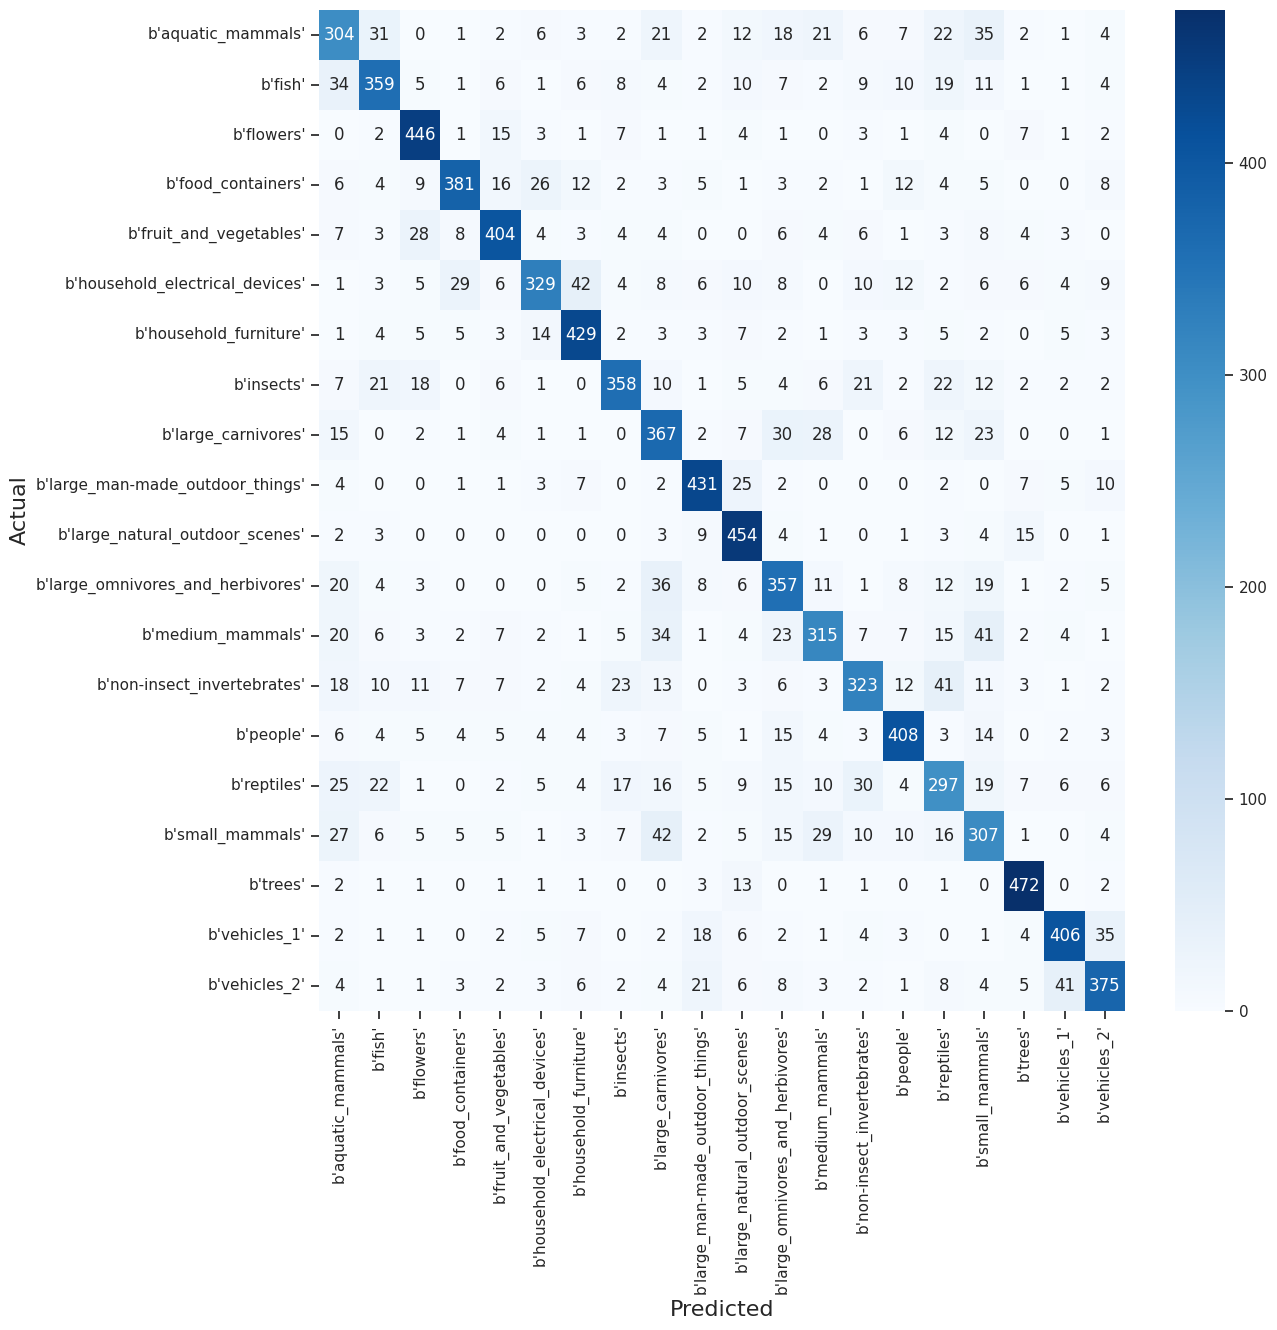


Final model (coarse) test_accuracy (Top-1 accuracy):  79.65

Final model (coarse) test_loss:  0.7096987730026245


In [ ]:
test_loss2, test_accuracy2, wrong_samples2, wrong_preds2, actual_preds2, class_dict2 = eval(finetune_coarse,criterion,testloader_coarse,'Final Model',printHM=True,classlabel=superclass_labels)
print('\nFinal model (coarse) test_accuracy (Top-1 accuracy): ',test_accuracy2)
print('\nFinal model (coarse) test_loss: ',test_loss2)

In [ ]:
displayLowestF1(class_dict2,classes=20)

b'reptiles' {'precision': 0.644887983706721, 'recall': 0.634, 'f1-score': 0.6393945509586277, 'support': 500}
b'small_mammals' {'precision': 0.6481226053639846, 'recall': 0.674, 'f1-score': 0.6607827788649706, 'support': 500}
b'aquatic_mammals' {'precision': 0.671980198019802, 'recall': 0.678, 'f1-score': 0.6749751243781095, 'support': 500}
b'medium_mammals' {'precision': 0.7826696832579186, 'recall': 0.71, 'f1-score': 0.7399898089171974, 'support': 500}
b'large_carnivores' {'precision': 0.7027586206896552, 'recall': 0.804, 'f1-score': 0.7496296296296296, 'support': 500}
b'non-insect_invertebrates' {'precision': 0.8040909090909091, 'recall': 0.716, 'f1-score': 0.7572340425531914, 'support': 500}
b'large_omnivores_and_herbivores' {'precision': 0.7487072243346007, 'recall': 0.784, 'f1-score': 0.7659064327485379, 'support': 500}
b'household_electrical_devices' {'precision': 0.8704866180048662, 'recall': 0.728, 'f1-score': 0.7922832052689353, 'support': 500}
b'fish' {'precision': 0.8202061

### 5.2) Error Analysis

Fine label wrongly predicted values

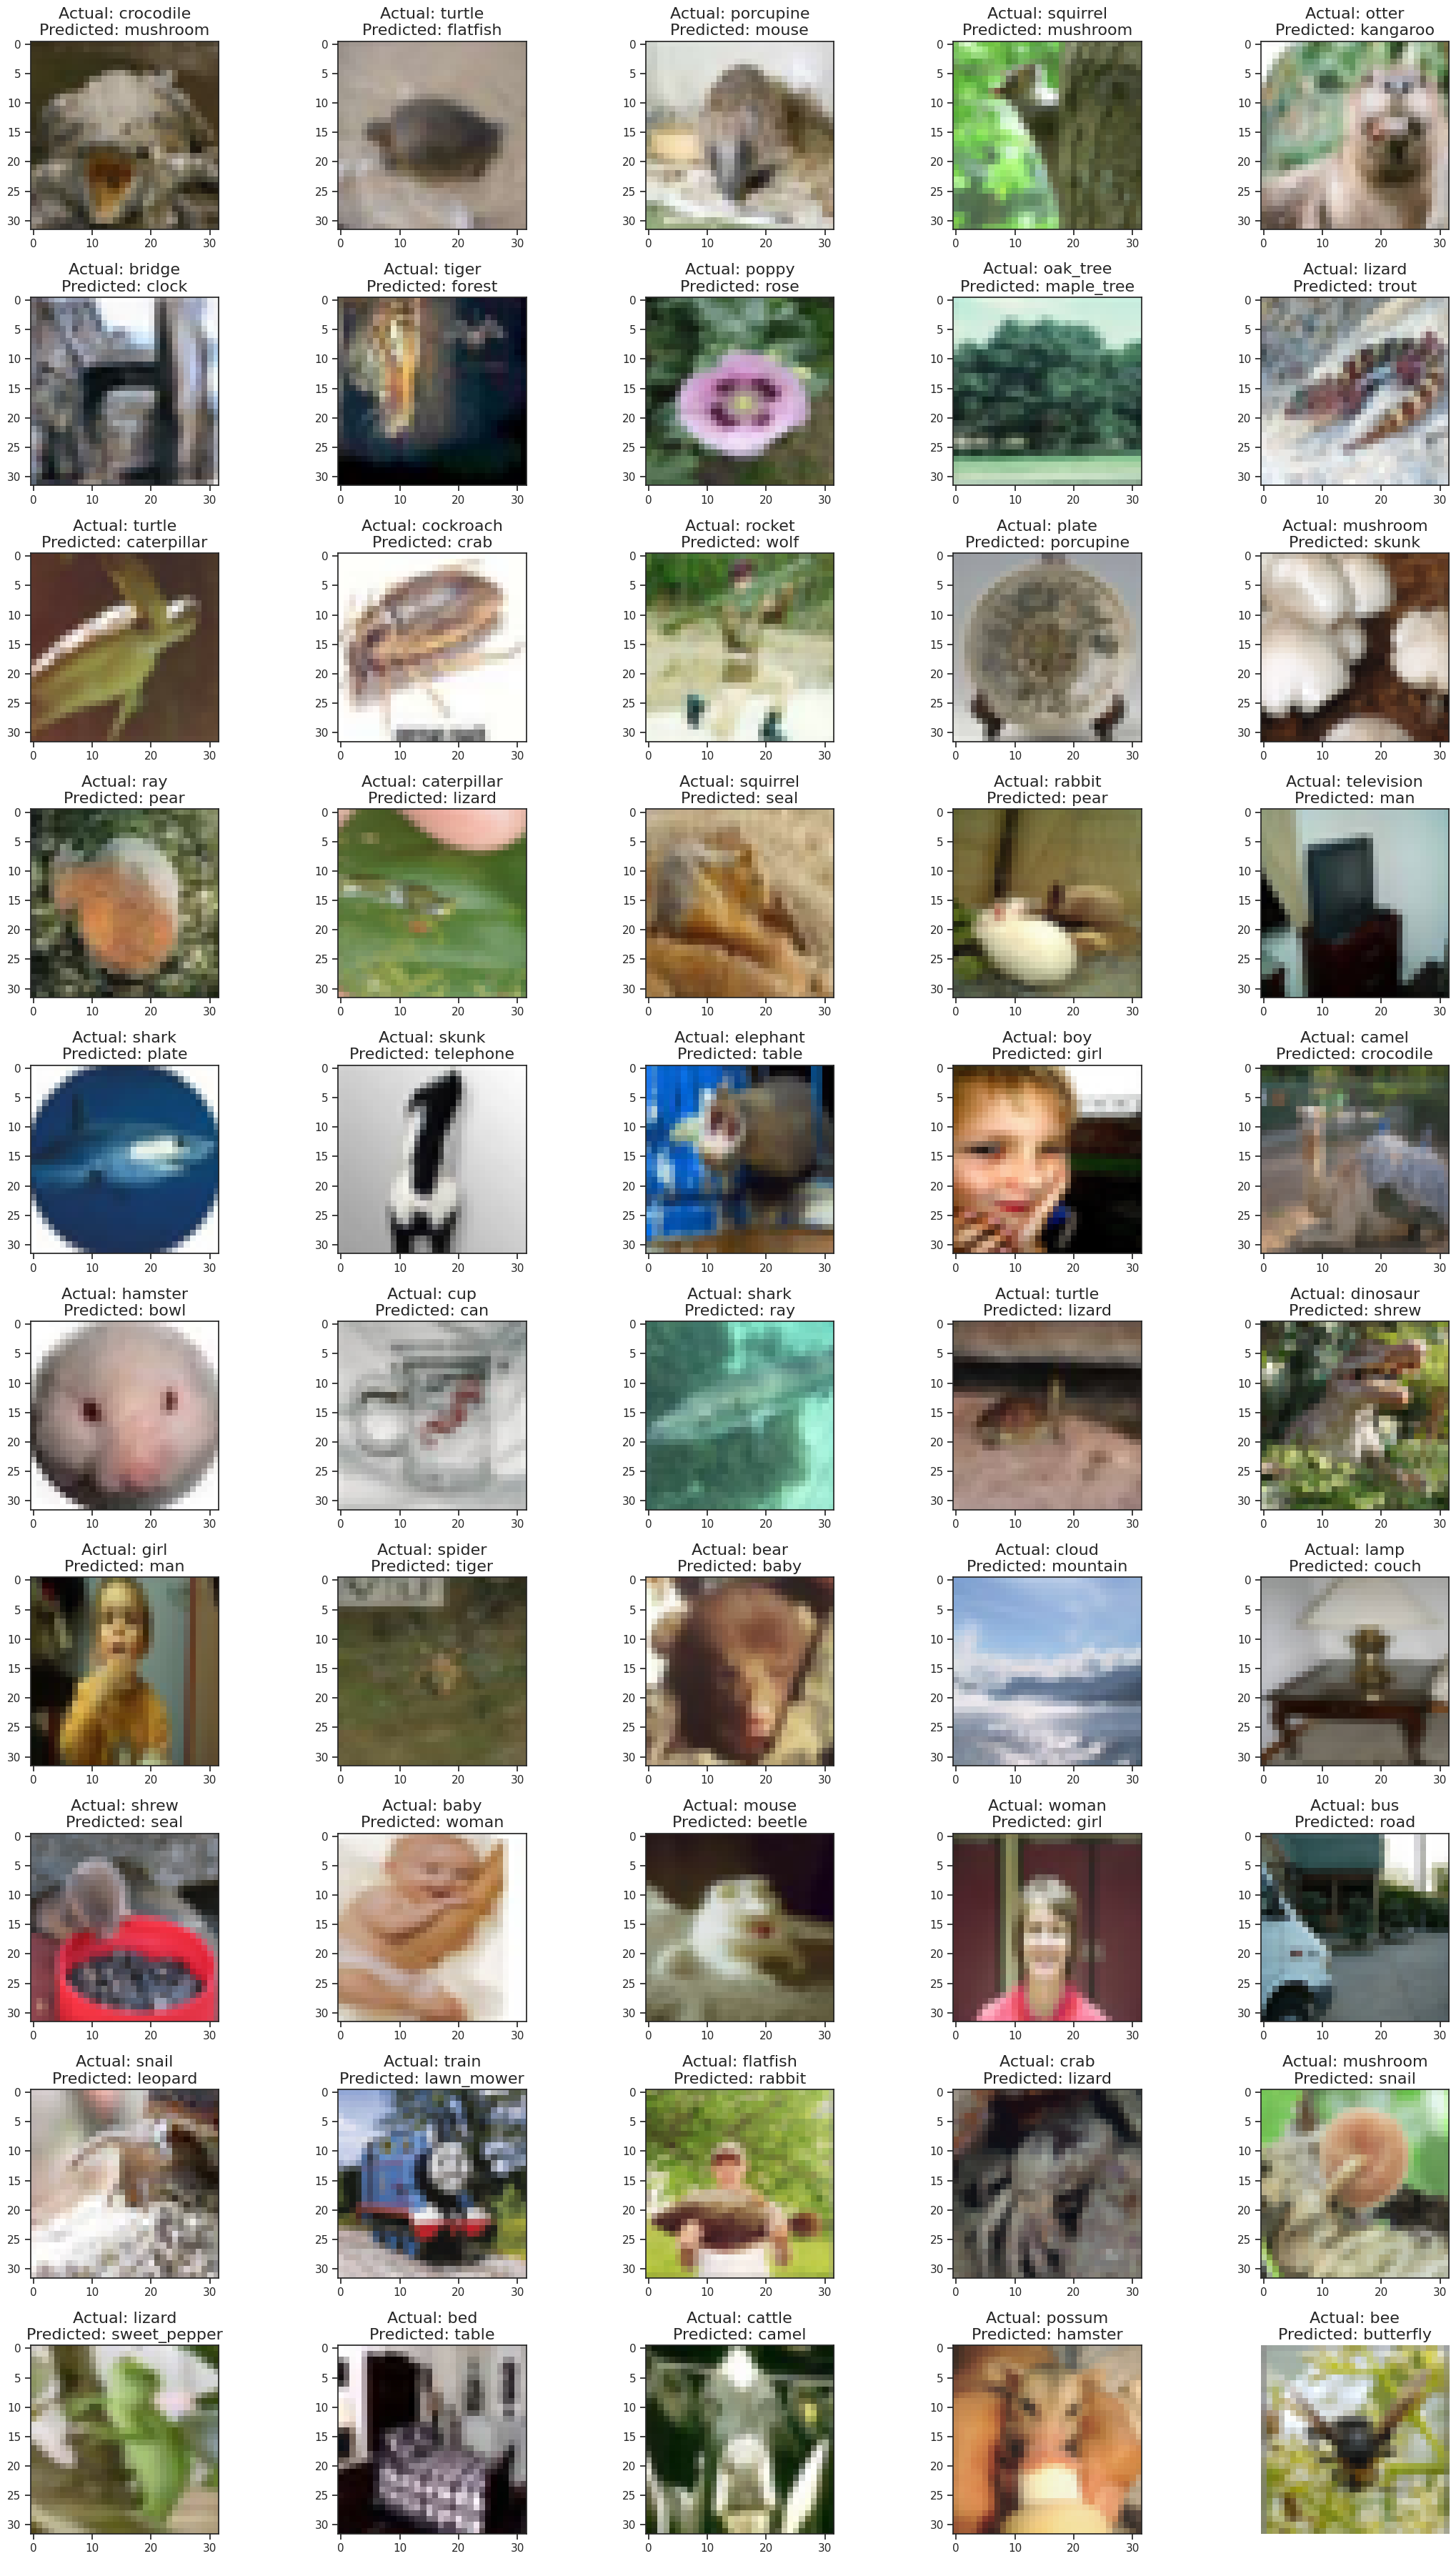

In [ ]:
random_idxs = np.random.choice(wrong_preds.shape[0], 50, replace=False)

fig, ax = plt.subplots(10, 5, figsize=(22, 36))
plt.axis("off")

for idx, subplot in zip(random_idxs, ax.ravel()):
    pred = class_labels[wrong_preds.type('torch.LongTensor')[idx]]
    actual = class_labels[actual_preds.type('torch.LongTensor')[idx]]
    subplot.imshow(img4np(wrong_samples.cpu())[idx])
    subplot.set_title(f"Actual: {actual}\nPredicted: {pred}",fontsize=16)
plt.tight_layout()

Coarse label wrongly predicted labels

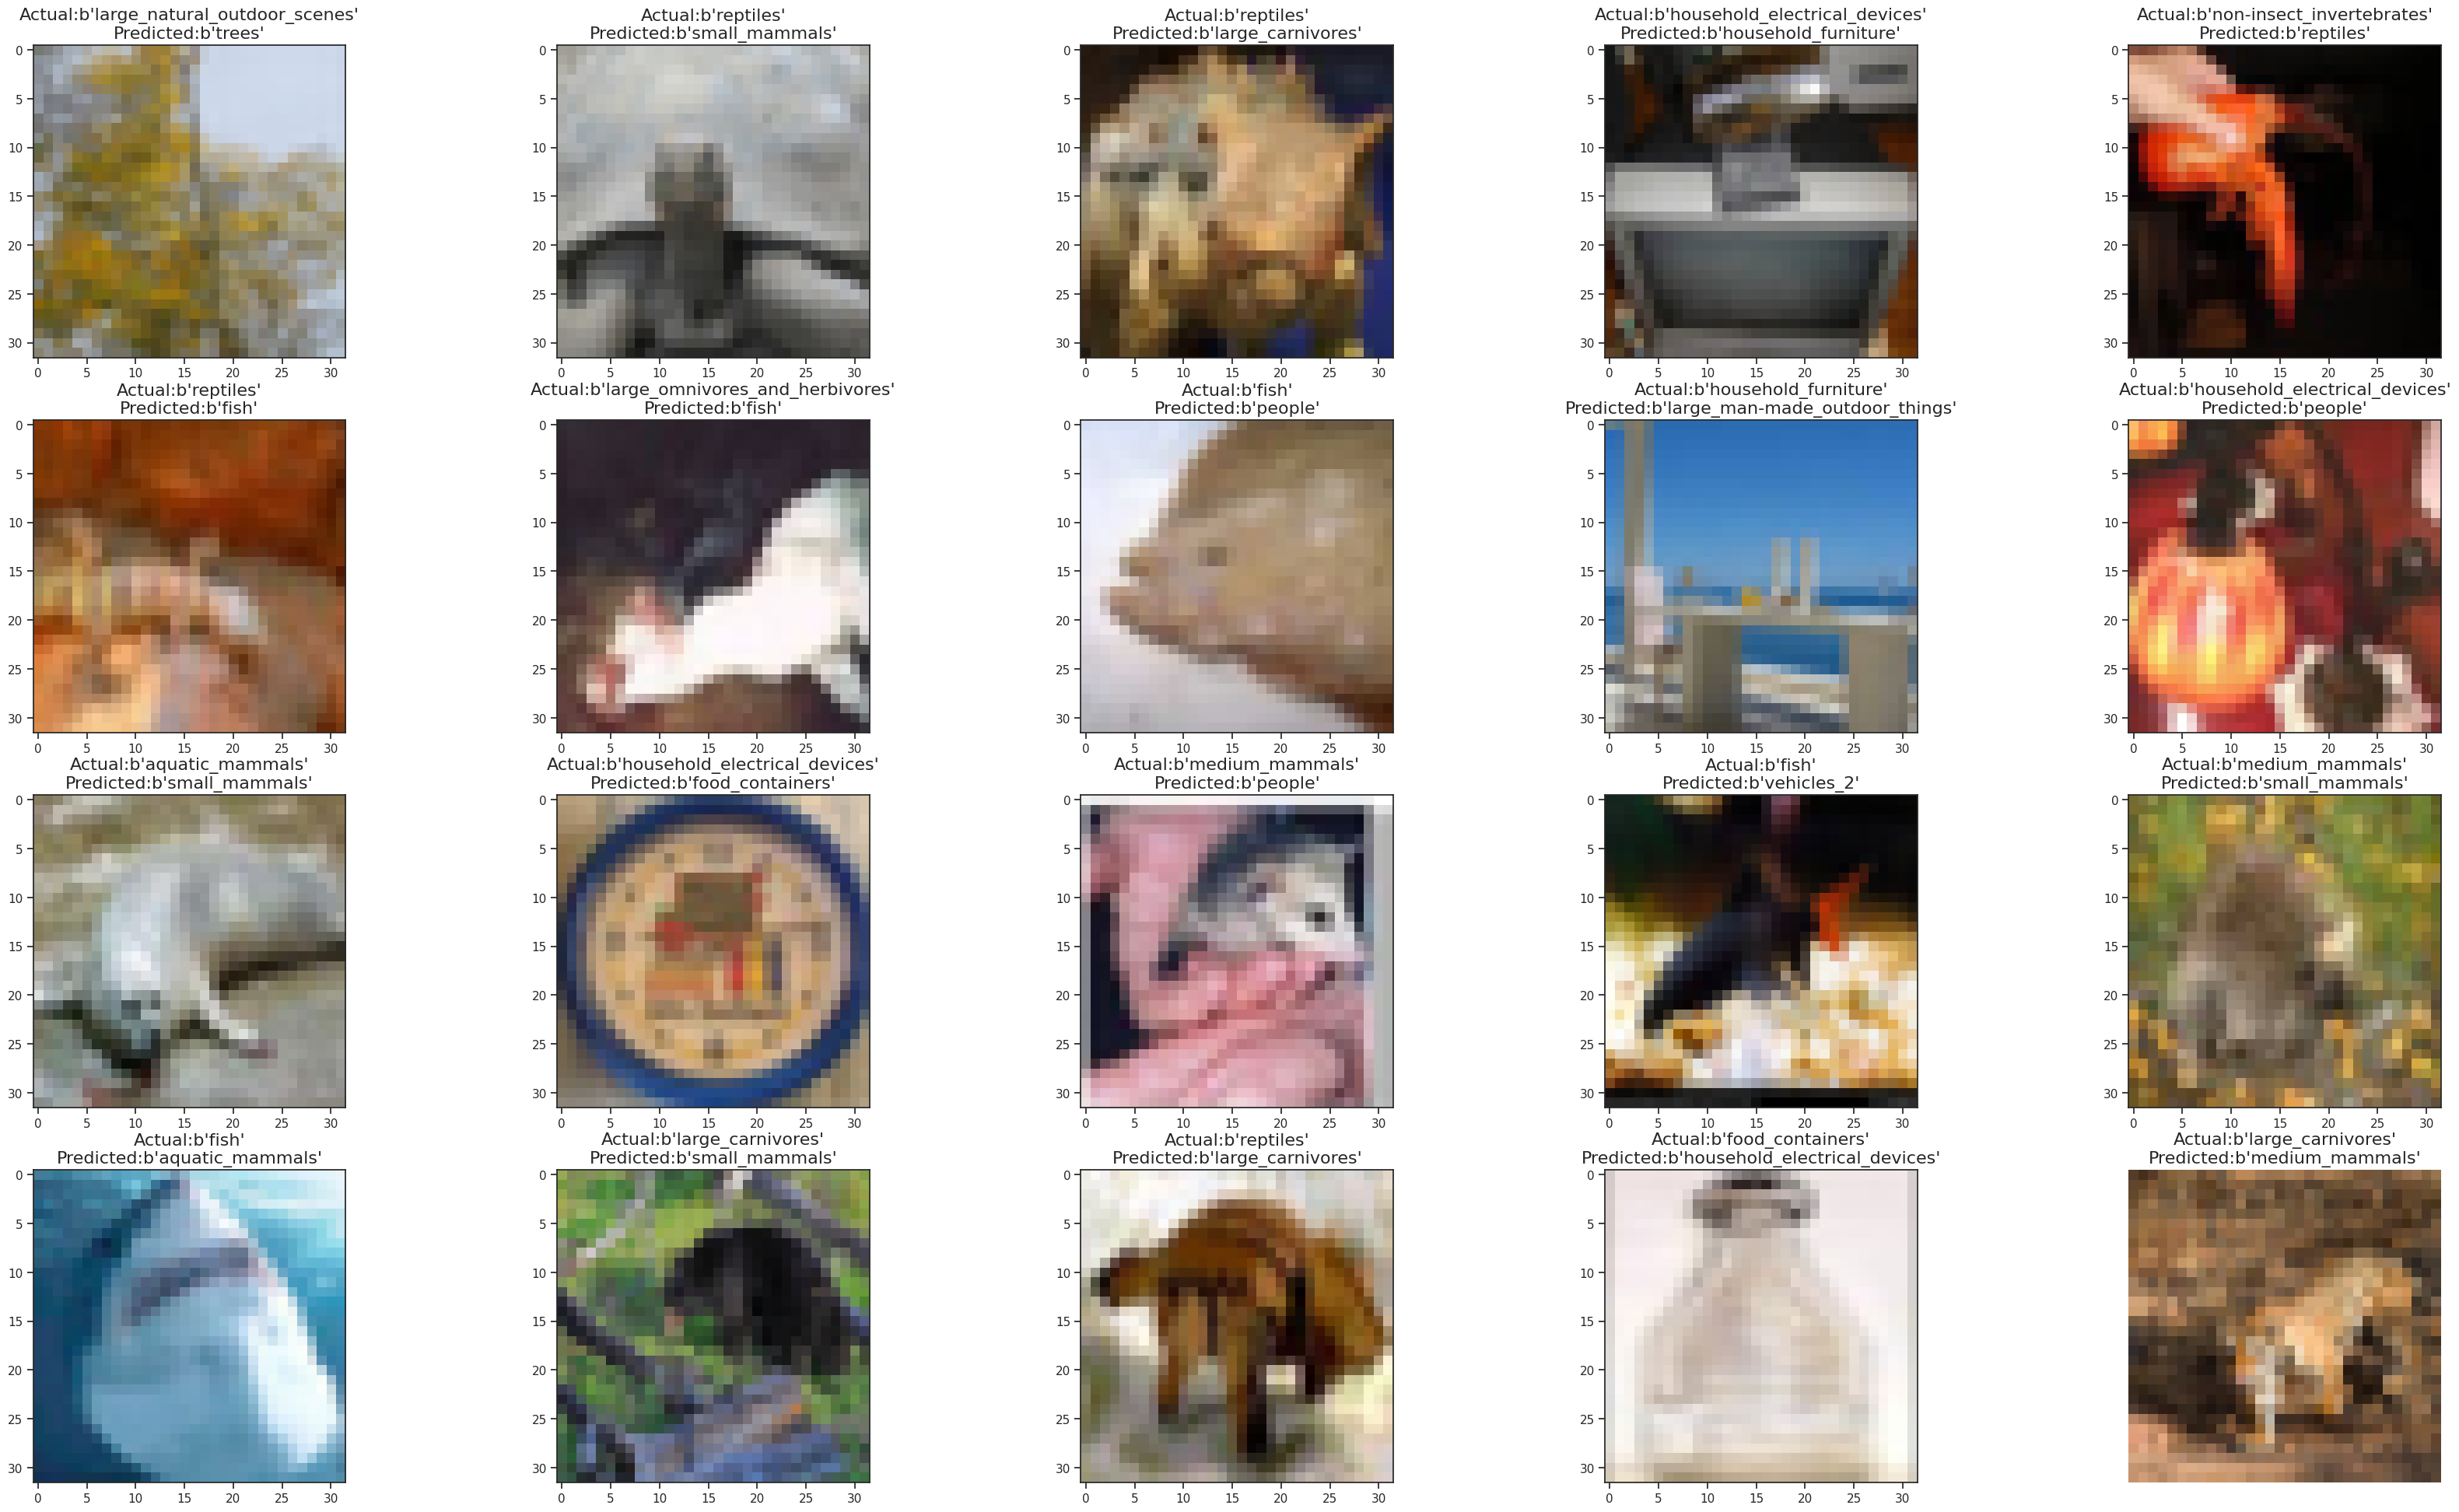

In [ ]:
random_idxs = np.random.choice(wrong_preds2.shape[0], 25, replace=False)

fig, ax = plt.subplots(4, 5, figsize=(42, 24))
plt.axis("off")

for idx, subplot in zip(random_idxs, ax.ravel()):
    pred = superclass_labels[wrong_preds2.type('torch.LongTensor')[idx]]
    actual = superclass_labels[actual_preds2.type('torch.LongTensor')[idx]]
    subplot.imshow(img4np(wrong_samples2.cpu())[idx])
    subplot.set_title(f"Actual:{actual}\nPredicted:{pred}",fontsize=16)
# plt.tight_layout()

Fine label feature mapping: Showing only fine model feature mapping as it will almost be the same as our coarse model feature map...since I did transfer learning from my fine model, during model improvement.

In [ ]:
layers = []
for parm in finalmodel_fine.parameters():
    layers.append(parm)

First layer has [64 output, 3 input channels, 3 kernel width, 3 kernel height]

In [ ]:
layers[0].shape

torch.Size([64, 3, 3, 3])

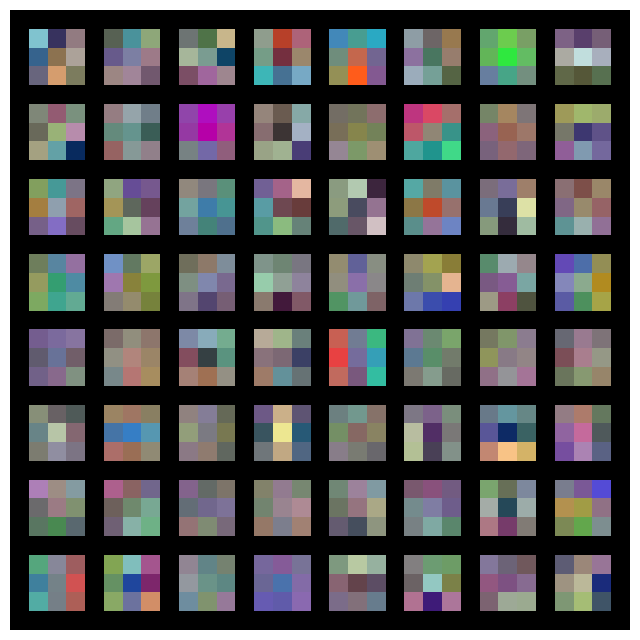

In [ ]:
from torchvision import utils

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

filter = layers[0].data.cpu().clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

Unlike in Part A, the weights of the filters are far harder to comprehen as there are now 3 colors with very differenting shades to display.

In [ ]:
def featureMap(conv,image_input,plotX=8,plotY=8):
    image_np = image_input.cpu().numpy()
    cuda0 = torch.device('cuda:0')
#     image_map = F.conv2d(image_input.to(cuda0), convWeights.data.to(cuda0), padding=1)
    image_map = conv(image_input.to(cuda0))
    image_map = image_map.cpu().detach().numpy()[0]
#     print(image_map.shape)
    fig, ax = plt.subplots(plotY, plotX, figsize=(20, 20))
    for i, subplot in enumerate(ax.ravel()):
        image = image_map[i]
        subplot.imshow(image,cmap='gray')
        subplot.set_title(f"Filter {i+1}")
        subplot.axis("off")
    plt.show()

My first layer of my final model

In [ ]:
finalmodel_fine.module.s0[0][0]

Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

First layer of our model, with activation function

In [ ]:
finalmodel_fine.module.s0[0]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): GELU(approximate='none')
)

Original

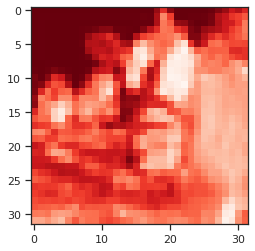

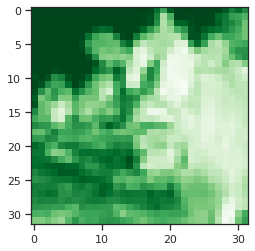

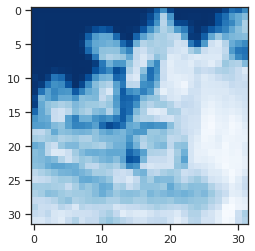

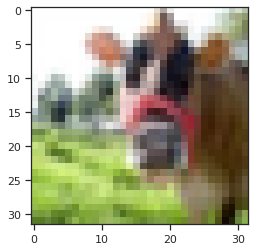

In [ ]:
plt.imshow(traindata_input[0].numpy()[0],cmap='Reds')
plt.show()
plt.imshow(traindata_input[0].numpy()[1],cmap='Greens')
plt.show()
plt.imshow(traindata_input[0].numpy()[2],cmap='Blues')
plt.show()
plt.imshow(img4np(torch.unsqueeze(traindata_input[0], dim=0))[0])
plt.show()

Feature map of cattle (Layer1 before activation function)


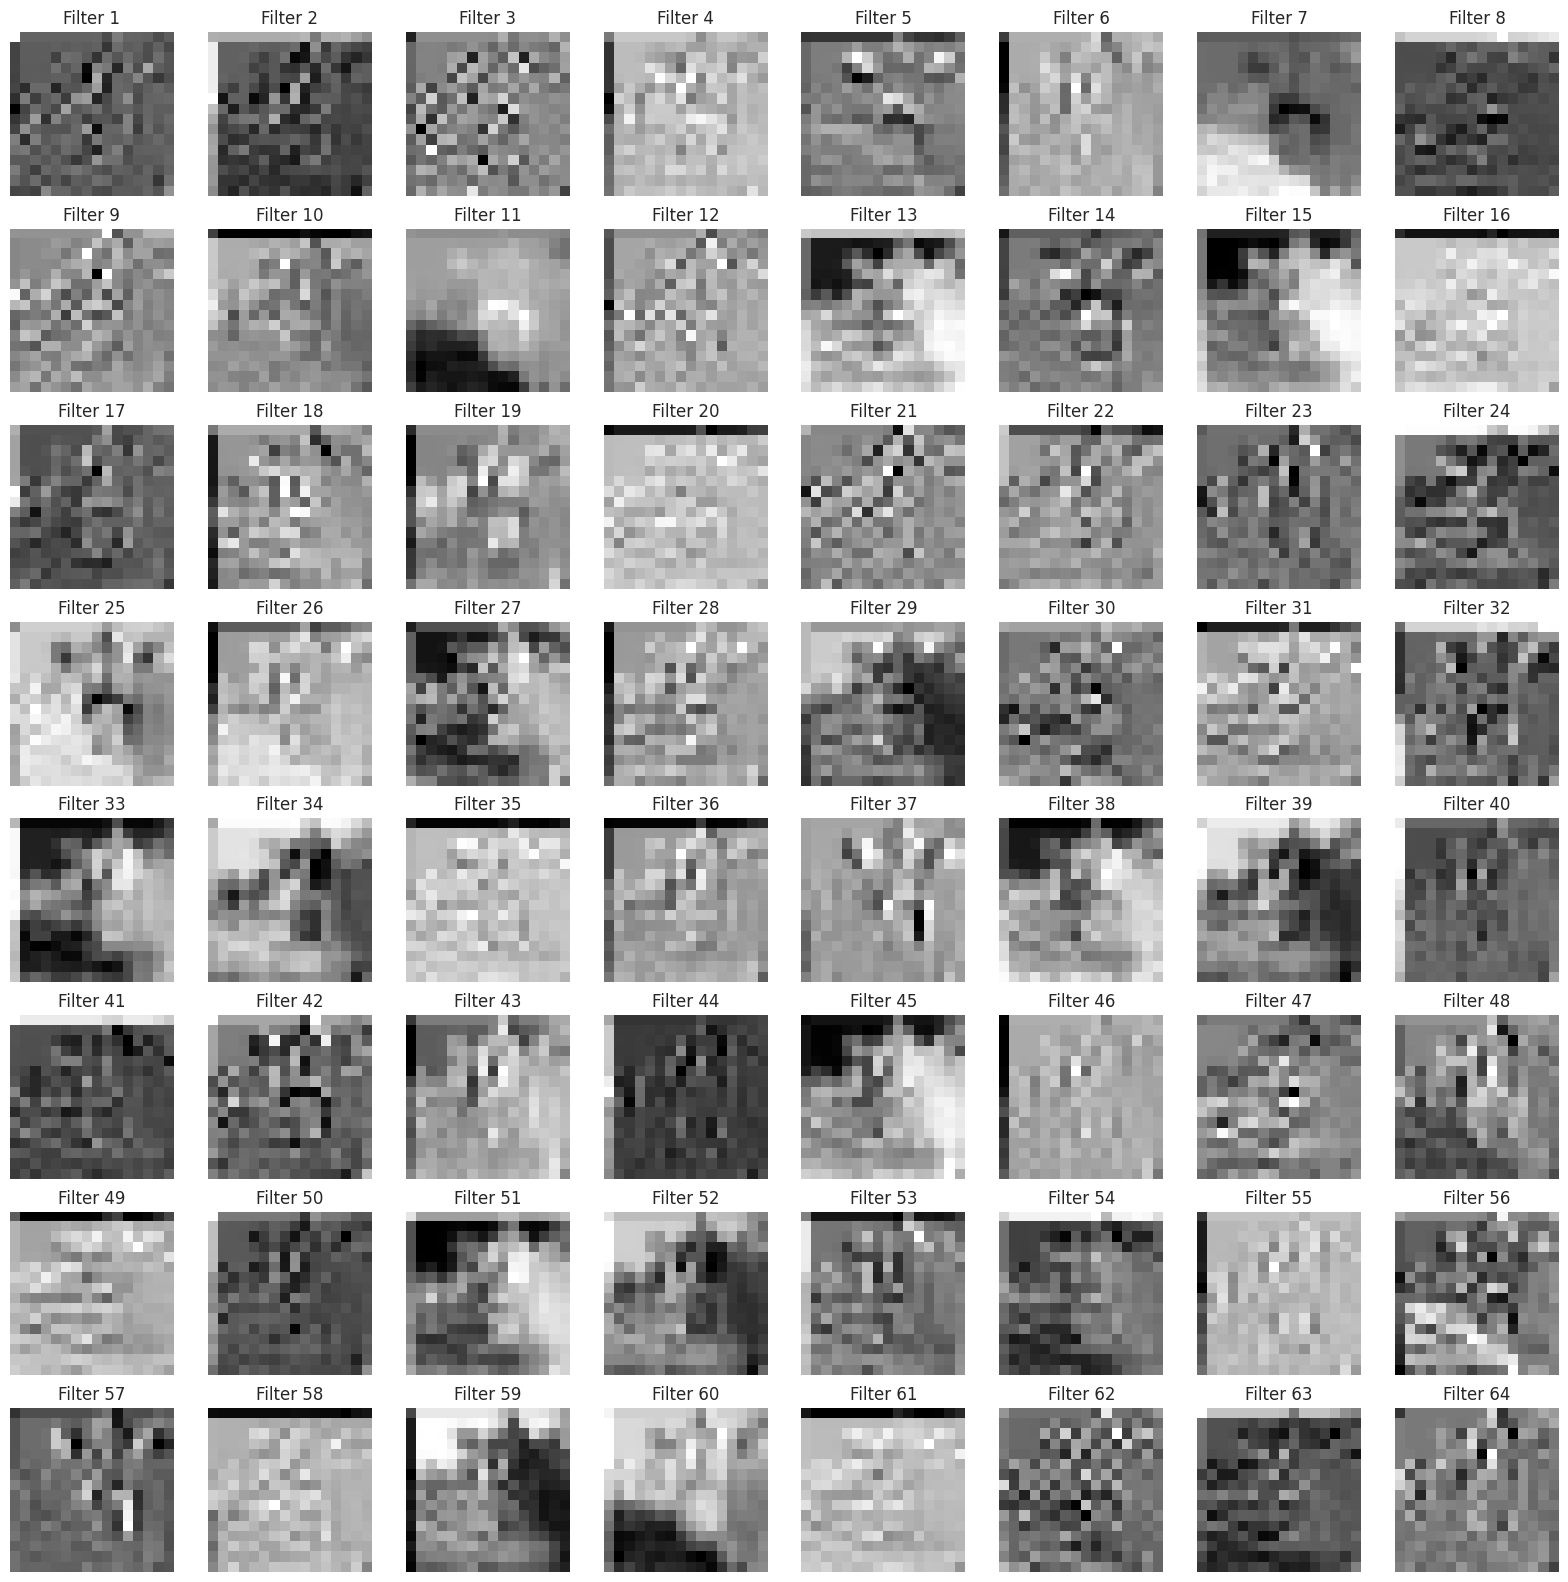

Feature map of cattle (Layer1 after activation function)


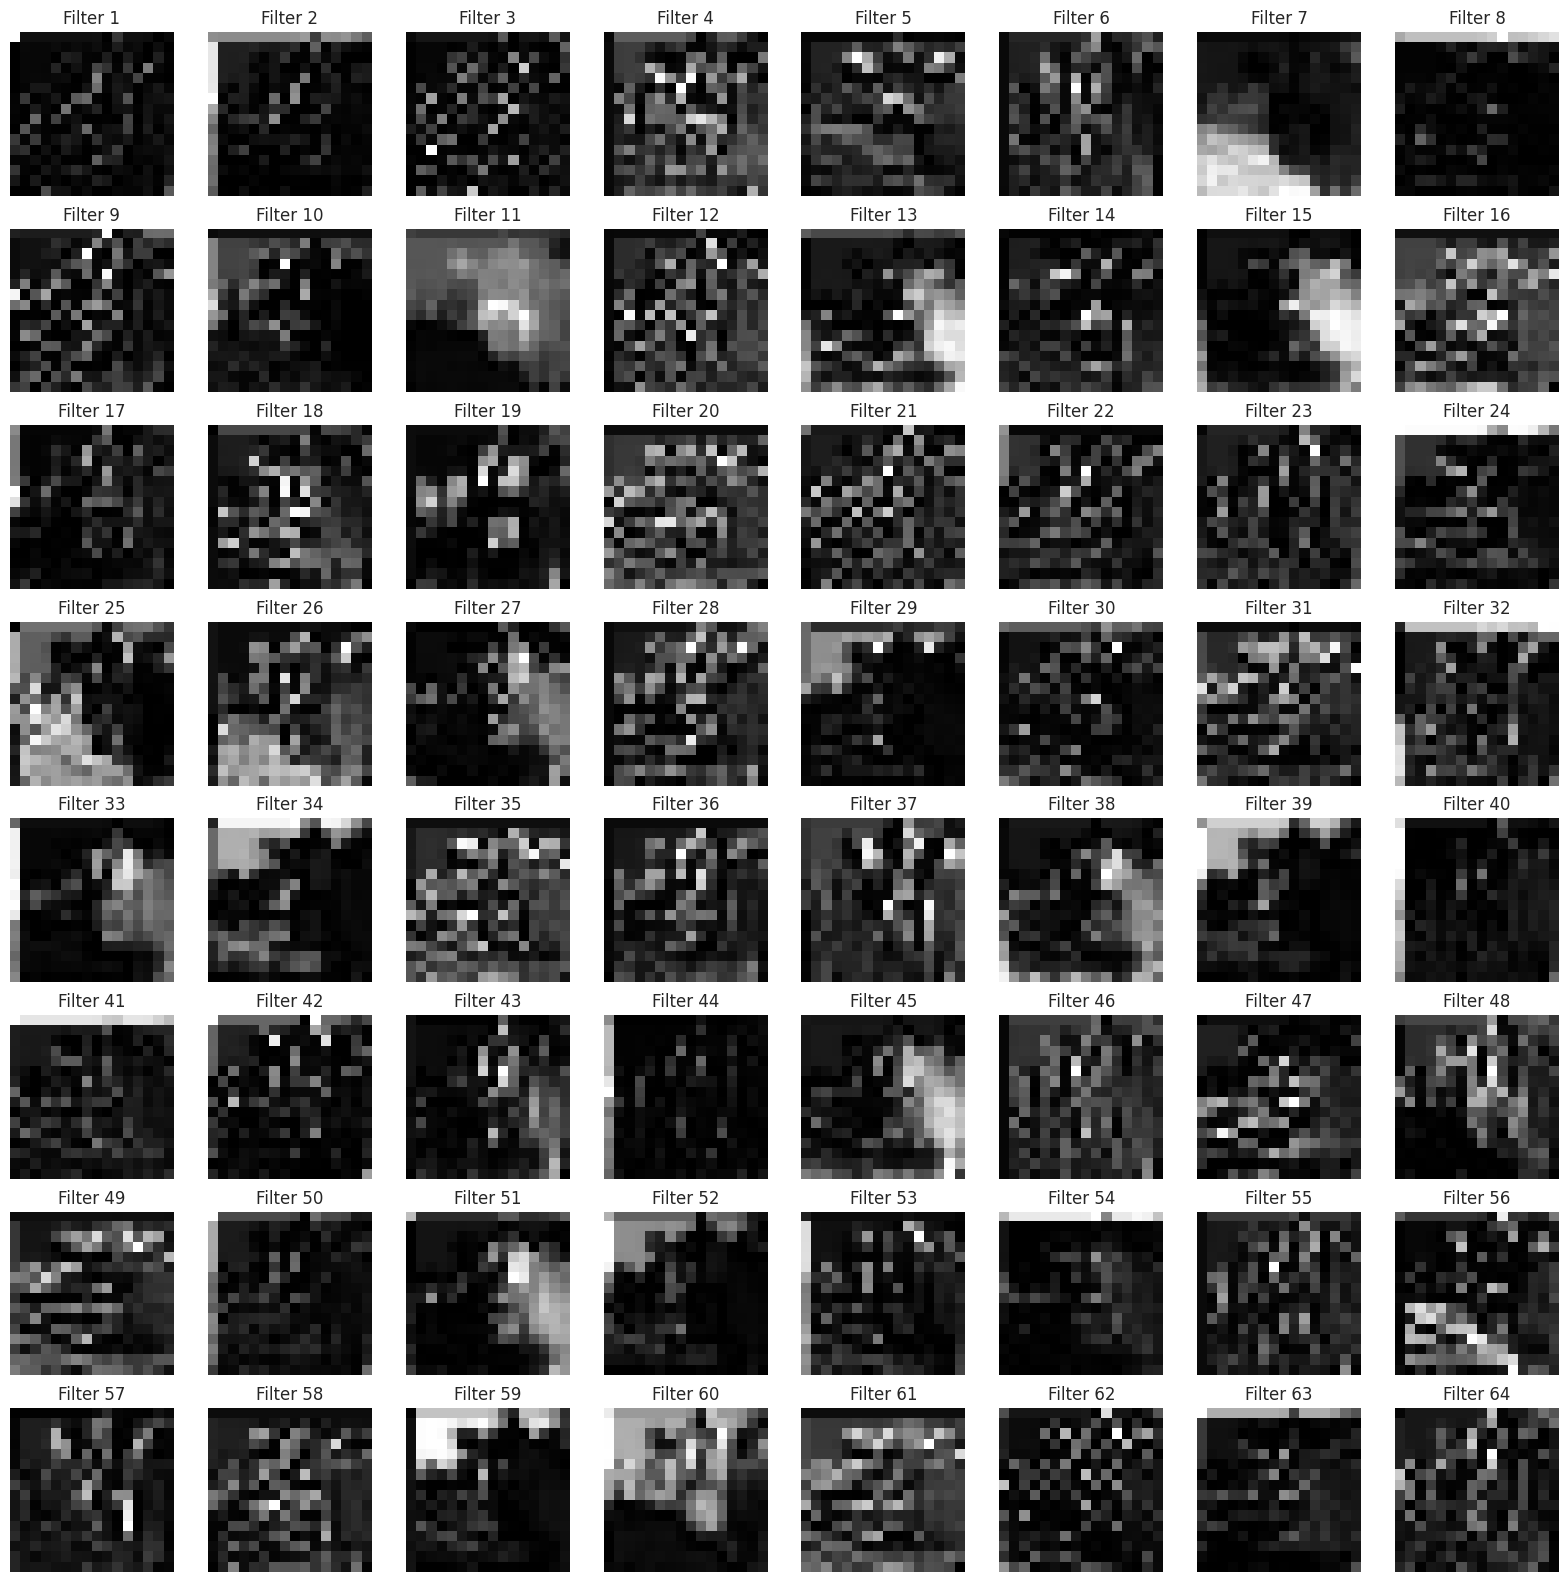

In [ ]:
print('Feature map of cattle (Layer1 before activation function)')
featureMap(finalmodel_fine.module.s0[0][0],torch.unsqueeze(traindata_input[0], dim=0),8,8)

print('Feature map of cattle (Layer1 after activation function)')
featureMap(finalmodel_fine.module.s0[0],torch.unsqueeze(traindata_input[0], dim=0),8,8)

In [ ]:
torch.save(finalmodel_fine,'finalmodel_fine')
torch.save(finalmodel_coarse,'finalmodel_coarse')

`You have reach the end of Part B :))`